# Retrieving Simulator Logs from Log Analytics for Analysis

This notebook shows you how to access the logs from your simulators, and provides a few sample analyses. Episode level and iteration level logs during training and assessment are stored on [Log Anlytics](https://docs.microsoft.com/en-us/azure/azure-monitor/platform/data-platform-logs). The logs on Azure Monitor can be accessed using the query language [KQL](https://docs.microsoft.com/en-us/sharepoint/dev/general-development/keyword-query-language-kql-syntax-reference). 

The notebook uses the jupyter extension [`Kqlmagic`](https://github.com/Microsoft/jupyter-Kqlmagic), to automatically query the data directly within the notebook. More info + more complete functionality on the ` Kqlmagic` extension is available on its official [docs](https://docs.microsoft.com/en-us/azure/data-explorer/kqlmagic).

## Description

Simulator logs are enabled by default for brains trained during assessment. For training they must be enabled via the CLI command [bonsai brain version start-logging](https://docs.microsoft.com/en-us/bonsai/cli/brain/version/start-logging).

## Prerequisites

1. Install requirements: an [enviroment.yml](https://gist.github.com/akzaidi/ed687b492b0f9e77682b0a0a83397659/) is provided with a complete description of the packages needed to run this notebook using Anaconda. Please install Anaconda (or miniconda) and run `conda env update -f environment.yml` in the folder where you download the linked `environment.yml` file.
2. If your azure subscription has not yet been registered to allow Log Analytics workspace resource provider, it needs to be registered manually using the azure-cli:
    1. Determine if registering is required. <SUBCRIPTION_ID> can be found on preview.bons.ai by clicking on id/Workspace info. 
    ```
    az provider show --namespace 'Microsoft.OperationalInsights' -o table --subscription <SUBCRIPTION_ID>
    ```
    2.  If the registrationState is `Registered`, you can skip this step. If not registered, we will need to register it. This is a one-time step per subscription and user will need owner-level permission. If you don't have the appropriate permission, work with your IT admin to execute that step.

    ```
    az login
    az provider register --namespace 'Microsoft.OperationalInsights' --subscription <SUBCRIPTION_ID>
    ```
### Note

A Log Analytics workspace will get created on Azure if it does not already exist in the provisioned Bonsai workspace.
 
## Usage

1. Start a simulator instance for Brain training: 
    1. For managed simulators
        1. Add the simulator instance to your inkling using the `package` statement, or start training and select the simulator instance using the web
        2. _or_ use the CLI: [`bonsai brain version start-training --simulator-package-name`](https://docs.microsoft.com/en-us/bonsai/cli/brain/version/start-training)
    2. For unmanaged simulators:
        1. register a sim by launching your sim. For example `python main.py`
        2. start brain training `bonsai brain version start-training --name <BRAIN_NAME>`
        3. connect your registered sim to a brain `bonsai simulator unmanaged connect --simulator-name <SIM_NAME> --brain-name <BRAIN_NAME> --version <VERSION_#> --action Train --concept-name <CONCEPT_NAME>`
        4. Find the `session-id` of un-managed sim using Bonsai CLI: `bonsai simulator unmanaged list`
2. Enable logging using the CLI:
    1. For managed simulators, add the `-m` parameter for managed simulator logging and the number of instances to log:
        `bonsai brain version start-logging -m -s <NUM_INSTANCES> -n <BRAIN_NAME>`
        You can also optionally request for system logs with the `-l` parameter.
    2. For unmanaged simulators, you should specify the `session-id`: 
        `bonsai brain version start-logging -n <BRAIN_NAME> --session-id <SESSION_ID>`
3. Logs will start populating the Log Analytics workspace 3-5 minutes after starting logging
4. Obtain your KQL workspace-id by navigating to the KQL resource in the Azure Portal:
    ![log-analytics-azure-portal](log-analytics-id.png)

## Getting Started

### Load Kqlmagic Extension

The following cell loads the `Kqlmagic` extension into your notebook and sets the maximum number of rows to display in the output to five (the result will not be truncated however, other than by KQL's [query limit](https://docs.microsoft.com/en-us/azure/data-explorer/kusto/concepts/querylimits)). Whenever you want to use `KQL` in a cell, prepend that cell with the statem `%%kql`.

In [214]:
%reload_ext Kqlmagic
%config Kqlmagic.display_limit = 5 #limiting the number of rows displayed (full rows will still be stored)

### Login to the log analytics workspace

Retrieve the `LOG_ANALYTICS_WORKSPACE_ID` using the instructions provided above. Please **note**, the log analytics workspace-id is the `workspace-id` of the log analytics workspace, **not** your Bonsai workspace!


In [259]:
LOG_ANALYTICS_WORKSPACE_ID = "ea345eb0-8961-48c2-8656-be7a73f0df32"
ALIAS = 'jomcdowe' # could be anything, but should not be empty
%kql loganalytics://code;workspace=LOG_ANALYTICS_WORKSPACE_ID;alias=ALIAS

In [ ]:
# Enes "9e69f3b2-b326-4165-9dae-95bbb3e19244" 
# Hossein "149ae47e-aac6-495a-812c-2c3dd3018f20"
# Journey "ea345eb0-8961-48c2-8656-be7a73f0df32"

## Iteration and Episode Level Logs

There are four tables generated by the Bonsai service and sent to your Log Analytics workspace. These are:

1. `EpisodeLog_CL` which contains your episode-level logs, such as information about the starting simulator configuration of your episodes, your aggregate goal metrics, etc.
2. `IterationLog_CL` which contains the interation-level logs of your simulator, including the actions received from the platform, and the states emitted from your simulators.
3. `ContainerEvent_CL` (**only for managed simulators that were logged with system logs**): container event logs such as image pull time, build time, etc.
4. `ContainerInstanceLog_CL` (**only for managed simulators that were logged with system logs**): system logs from your simulators.

Let's extract both iteration (`IterationLog_CL`) and episode-level (`EpisodeLog_CL`) logs and join them together via a KQL query. We then export the query results to a pandas dataframe which we can then manipulate and analyze.

**Note**: if this is the first time you're using logging you may need to wait for the first episode to finish so that episode-level logs are created and filled with at least 1 row of data.

### Specify Query Variables and Query

In order to make our query specific to a brain version and brain name, we can create variables containing those values. The following cell does exactly that, and in addition specific a max number of rows to query.

<div class="alert alert-block alert-danger">
<b>WARNING: KQL queries are case-sensitive and the data stored in your analytics workspace is saved as lowercase strings. Brain name and assessment name must be set as lowercase or the query options noted below will fail to find any data.
</div>

In [260]:
number_of_rows = 100000
brain_name = "scg-fun".lower()
brain_version = 48

#### Query

Here is our `KQL` query. Observe that we first filter the `EpisodeLog_CL` table to the brain name and brain version we defined above, and then join it with the `IterationLog_CL` table using the unique `EpisodeId_g` index. Finally, we select (using `project`) a set of columns we want to retain in our resulting dataframe.

In [261]:
%%kql
let _number_of_rows = number_of_rows;
let _brain_name = brain_name;
let _brain_version = brain_version;
EpisodeLog_CL
  | where BrainName_s == _brain_name and BrainVersion_d == _brain_version
  | where  TimeGenerated > ago(60d)
  | join kind=inner (
      IterationLog_CL
      | sort by Timestamp_t desc
      ) on EpisodeId_g
  | take _number_of_rows
  | project 
      Timestamp = Timestamp_t,
      SessionIndex = SessionId_s,
      EpisodeIndex = EpisodeIndex_d,
      IterationIndex = IterationIndex_d,
      EpisodeType_s = EpisodeType_s,
      BrainName = BrainName_s,
      BrainVersion = BrainVersion_d,
      SimState = parse_json(SimState_s),
      SimAction = parse_json(SimAction_s),
      SimConfig = parse_json(SimConfig_s),
      Reward = Reward_d,
      CumulativeReward = CumulativeReward_d,
      Terminal = Terminal_b,
      LessonIndex = LessonIndex_d,
      GoalMetrics = parse_json(GoalMetrics_s),
      EpisodeType = EpisodeType_s,
      FinishReason = FinishReason_s
  | order by SessionIndex, EpisodeIndex asc, IterationIndex asc

[{'Timestamp': datetime.datetime(2021, 10, 1, 17, 6, 48, 8000, tzinfo=tzutc()), 'SessionIndex': '713619439_10.244.42.136', 'EpisodeIndex': 15, 'IterationIndex': 16, 'EpisodeType_s': 'Training', 'BrainName': 'scg-fun', 'BrainVersion': 48, 'SimState': {'deltaMI_201': -0.2020945324800376, 'deltaMI_201_past': -0.2890259924800378, 'deltaMI_221': -1.31373810164988, 'deltaMI_221_past': -0.43422510164988015, 'C2': 55500, 'BR_201': 55, 'BR_221': 45, 'Density_221': 0.949492, 'current_H2_201': 0.3672006907457541, 'current_H2_221': 0.0232872813940048, 'current_C4_221': 0.5699500000000001, 'deltaPressure': 0.4935714285714286, 'MI_201': 112.354466, 'MI_221': 0.053876, 'MI_201_target_range_low': 132.66864587200564, 'MI_201_target_range_high': 152.66864587200564, 'MI_221_target_range_low': 0.4167887005499601, 'MI_221_target_range_high': 0.56678870054996, 'C2_target_range': [55490, 55510], 'BR_201_target_range': [55, 55], 'BR_221_target_range': [45, 45], 'action_range_H2_201': [0, 62.916], 'action_range_H2_221': [0, 5], 'action_range_C2': [30000, 57000], 'action_range_C4_241': [0, 500], 'action_range_C4_221': [0, 1200], 'action_range_BR_201': [0, 100], 'action_range_BR_241': [0, 100], 'action_range_BR_221': [0, 100], 'sim_action_H2_201': 23.102798658959863, 'sim_action_H2_221': 0.116436406970024, 'sim_action_BR_201': 55, 'sim_action_BR_221': 45, 'sim_action_BR_241': 0, 'sim_action_C2': 55500, 'sim_action_C4_221': 683.94, 'sim_action_C4_241': 0, 'obs_range_MI_201': [0, 900], 'obs_range_MI_221': [0, 2], 'obs_range_C2': [30000, 57000], 'obs_range_BR_201': [0, 100], 'obs_range_BR_221': [0, 100], 'obs_range_Density_221': [0.935, 0.968], 'pressure_error': False, 'step_count': 15, 'max_iteration': 20, 'sim_time': 60, 'sim_error': False, 'reward_value': 0.8012903494276412, 'terminal_value': False}, 'SimAction': {'H2_201': 0.7499785423278809, 'H2_221': -0.48836207389831543}, 'SimConfig': {'training_grade': 1, 'sigma': 5}, 'Reward': 0.801290392875671, 'CumulativeReward': 17.5024948120117, 'Terminal': False, 'LessonIndex': 1, 'GoalMetrics': {}, 'EpisodeType': 'Training', 'FinishReason': 'Interrupted'},
 {'Timestamp': datetime.datetime(2021, 10, 1, 17, 12, 17, 240000, tzinfo=tzutc()), 'SessionIndex': '713619439_10.244.42.136', 'EpisodeIndex': 15, 'IterationIndex': 17, 'EpisodeType_s': 'Training', 'BrainName': 'scg-fun', 'BrainVersion': 48, 'SimState': {'deltaMI_201': 0.017690827519962316, 'deltaMI_201_past': -0.2020945324800376, 'deltaMI_221': -1.04255310164988, 'deltaMI_221_past': -1.31373810164988, 'C2': 55500, 'BR_201': 55, 'BR_221': 45, 'Density_221': 0.950933, 'current_H2_201': 0.6642043771738242, 'current_H2_221': 0.3385796397924423, 'current_C4_221': 0.5699500000000001, 'deltaPressure': 0.8150000000000001, 'MI_201': 145.32227, 'MI_221': 0.144271, 'MI_201_target_range_low': 132.66864587200564, 'MI_201_target_range_high': 152.66864587200564, 'MI_221_target_range_low': 0.4167887005499601, 'MI_221_target_range_high': 0.56678870054996, 'C2_target_range': [55490, 55510], 'BR_201_target_range': [55, 55], 'BR_221_target_range': [45, 45], 'action_range_H2_201': [0, 62.916], 'action_range_H2_221': [0, 5], 'action_range_C2': [30000, 57000], 'action_range_C4_241': [0, 500], 'action_range_C4_221': [0, 1200], 'action_range_BR_201': [0, 100], 'action_range_BR_241': [0, 100], 'action_range_BR_221': [0, 100], 'sim_action_H2_201': 41.78908259426832, 'sim_action_H2_221': 1.6928981989622116, 'sim_action_BR_201': 55, 'sim_action_BR_221': 45, 'sim_action_BR_241': 0, 'sim_action_C2': 55500, 'sim_action_C4_221': 683.94, 'sim_action_C4_241': 0, 'obs_range_MI_201': [0, 900], 'obs_range_MI_221': [0, 2], 'obs_range_C2': [30000, 57000], 'obs_range_BR_201': [0, 100], 'obs_range_BR_221': [0, 100], 'obs_range_Density_221': [0.935, 0.968], 'pressure_error': False, 'step_count': 16, 'max_iteration': 20, 'sim_time': 60, 'sim_error': False, 'reward_value': 0.8404785353469982, 'terminal_value': False}, 'SimAction': {'H2_221': 0.9458770751953124, 'H2_201': 0.8910110592842102}, 'SimConf

### Magic

Magically, the output of the result is saved to a new python variable called `_kql_raw_result`. We can convert this to a pandas dataframe:

In [245]:
# convert query results in a dataframe
iter_df = _kql_raw_result_.to_dataframe()
iter_df.head(5)

Timestamp             SessionIndex  EpisodeIndex  \
0 2021-10-07 18:25:57.601000+00:00  616526458_10.244.36.191           1.0   
1 2021-10-07 18:29:06.149000+00:00  616526458_10.244.36.191           1.0   
2 2021-10-07 18:31:52.598000+00:00  616526458_10.244.36.191           1.0   
3 2021-10-07 18:32:22.275000+00:00  616526458_10.244.36.191           2.0   
4 2021-10-07 18:35:32.115000+00:00  616526458_10.244.36.191           2.0   

   IterationIndex EpisodeType_s BrainName  BrainVersion  \
0             1.0    Assessment   scg-fun          48.0   
1             2.0    Assessment   scg-fun          48.0   
2             3.0    Assessment   scg-fun          48.0   
3             1.0    Assessment   scg-fun          48.0   
4             2.0    Assessment   scg-fun          48.0   

                                            SimState  \
0  {'deltaMI_201': 2.456118118736714, 'deltaMI_20...   
1  {'deltaMI_201': 0.6249284854033796, 'deltaMI_2...   
2  {'deltaMI_201': 0.0192431054033797, 'deltaMI_2...   
3  {'deltaMI_201': 2.471122295236658, 'deltaMI_20...   
4  {'deltaMI_201': 0.639934868569991, 'deltaMI_20...   

                                           SimAction  \
0                                               None   
1       {'H2_201': -1, 'H2_221': 0.5566816926002502}   
2  {'H2_201': -0.19491571187973025, 'H2_221': -0....   
3                                               None   
4        {'H2_201': -1, 'H2_221': 0.555738091468811}   

                           SimConfig     Reward  CumulativeReward  Terminal  \
0  {'training_grade': 1, 'sigma': 5}   0.000000         56.347504     False   
1  {'training_grade': 1, 'sigma': 5}   0.847502         56.347504     False   
2  {'training_grade': 1, 'sigma': 5}  55.500000         56.347504      True   
3  {'sigma': 5, 'training_grade': 1}   0.000000         56.340061     False   
4  {'sigma': 5, 'training_grade': 1}   0.840062         56.340061     False   

   LessonIndex GoalMetrics EpisodeType FinishReason  
0          0.0          {}  Assessment  Interrupted  
1          0.0          {}  Assessment  Interrupted  
2          0.0          {}  Assessment  Interrupted  
3          0.0          {}  Assessment  Interrupted  
4          0.0          {}  Assessment  Interrupted

In [246]:
iter_df.describe()

EpisodeIndex  IterationIndex  BrainVersion        Reward  \
count  36131.000000     36131.00000       36131.0  36131.000000   
mean      82.530182         2.58036          48.0     13.291464   
std       47.170040         1.21196           0.0     22.251249   
min        1.000000         1.00000          48.0     -1.000000   
25%       44.000000         2.00000          48.0      0.743052   
50%       77.000000         3.00000          48.0      0.887055   
75%      114.000000         4.00000          48.0      0.985709   
max      208.000000         9.00000          48.0     55.500000   

       CumulativeReward   LessonIndex  
count      36131.000000  36131.000000  
mean          53.930755      0.986411  
std            1.681469      0.115781  
min           -0.235645      0.000000  
25%           54.205029      1.000000  
50%           54.263603      1.000000  
75%           54.296783      1.000000  
max           56.388103      1.000000

In [ ]:
df = iter_df[iter_df['SessionIndex'] == "149204247_10.244.8.228"]
df = df[df['EpisodeIndex']==5]

In [ ]:
df.head(50)

## Converting Nested Array Into New Columns

Notice that the array-data as stored in `SimState`, `SimAction` and `SimConfig` are dictionaries. You can cast them into new columns using the operations below:

In [262]:
import pandas as pd
def format_kql_logs(df: pd.DataFrame) -> pd.DataFrame:
    ''' Function to format a dataframe obtained from KQL query.
        Output format: keeps only selected columns, and flatten nested columns [SimAction, SimState, SimConfig]

        Parameters
        ----------
        df : DataFrame
            dataframe obtained from running KQL query then exporting `_kql_raw_result_.to_dataframe()`
    '''
    selected_columns = ["Timestamp","EpisodeIndex", "IterationIndex", "Reward", "Terminal", "SimState", "SimAction", "SimConfig", "SessionIndex"]
    nested_columns =  [ "SimState", "SimAction", "SimConfig"]
    df_selected_columns = df[selected_columns]
    series_lst = []
    ordered_columns = ["Timestamp","EpisodeIndex", "IterationIndex", "Reward", "Terminal", "IterationSpeed_s", "SessionIndex"]
    for i in nested_columns:
        new_series = df_selected_columns[i].apply(pd.Series)
        column_names = new_series.columns.values.tolist()
        series_lst.append(new_series)
        if len(column_names) > 0:
            ordered_columns.extend(column_names)
        del(df_selected_columns[i])

    series_lst.append(df_selected_columns)
    formated_df = pd.concat(series_lst, axis=1)
    formated_df = formated_df.sort_values(by='Timestamp',ascending=True) # reorder df based on Timestamp
    formated_df.index = range(len(formated_df)) # re-index
    formated_df['Timestamp']=pd.to_datetime(formated_df['Timestamp']) # convert Timestamp to datetime
    formated_df['IterationSpeed_s']=formated_df['Timestamp'].diff().dt.total_seconds() # convert Timestamp to datetime

    formated_df = formated_df[ordered_columns]
    
    return formated_df.sort_values(by=["EpisodeIndex", "IterationIndex"])


In [283]:
df = format_kql_logs(iter_df)

In [284]:
df.describe()

EpisodeIndex  IterationIndex        Reward  IterationSpeed_s  \
count  36131.000000     36131.00000  36131.000000      36130.000000   
mean      82.530182         2.58036     13.291464         12.261633   
std       47.170040         1.21196     22.251249       1793.366943   
min        1.000000         1.00000     -1.000000          0.000000   
25%       44.000000         2.00000      0.743052          0.484000   
50%       77.000000         3.00000      0.887055          1.209000   
75%      114.000000         4.00000      0.985709          2.440000   
max      208.000000         9.00000     55.500000     340563.124000   

        deltaMI_201  deltaMI_201_past   deltaMI_221  deltaMI_221_past  \
count  36131.000000      36131.000000  36131.000000      36131.000000   
mean       0.861264          1.458693     -0.511973         -0.833250   
std        0.970772          1.011005      0.594122          0.578554   
min       -0.215208         -0.206713     -1.379671         -1.379671   
25%        0.045703          0.380038     -1.150535         -1.304026   
50%        0.409371          1.388697     -0.463626         -1.099481   
75%        1.537601          2.450624      0.015595         -0.423995   
max        2.561138          2.561138      1.495352          1.495352   

                 C2        BR_201  ...  sim_action_C4_221  sim_action_C4_241  \
count  36131.000000  36131.000000  ...       3.613100e+04            36131.0   
mean   54766.253356     53.654798  ...       6.839400e+02                0.0   
std     1289.535505      2.364148  ...       1.136884e-13                0.0   
min    52500.000000     49.500000  ...       6.839400e+02                0.0   
25%    55500.000000     55.000000  ...       6.839400e+02                0.0   
50%    55500.000000     55.000000  ...       6.839400e+02                0.0   
75%    55500.000000     55.000000  ...       6.839400e+02                0.0   
max    55500.000000     55.000000  ...       6.839400e+02                0.0   

        step_count  max_iteration  sim_time  reward_value        H2_201  \
count  36131.00000        36131.0   36131.0  36131.000000  27294.000000   
mean       1.58036           20.0      60.0     13.445430     -0.237991   
std        1.21196            0.0       0.0     22.160738      0.460039   
min        0.00000           20.0      60.0     -1.000000     -1.000000   
25%        1.00000           20.0      60.0      0.743052     -0.637028   
50%        2.00000           20.0      60.0      0.887055     -0.169746   
75%        3.00000           20.0      60.0      0.985709      0.130628   
max        8.00000           20.0      60.0     55.500000      0.975266   

             H2_221  training_grade    sigma  
count  27294.000000         36131.0  36131.0  
mean       0.160479             1.0      5.0  
std        0.309966             0.0      0.0  
min       -0.780908             1.0      5.0  
25%       -0.073193             1.0      5.0  
50%        0.093531             1.0      5.0  
75%        0.424656             1.0      5.0  
max        1.000000             1.0      5.0  

[8 rows x 38 columns]

In [ ]:
len(df['SessionIndex'].unique())

In [ ]:
df.sort_values(by=["EpisodeIndex", "IterationIndex"])

In [ ]:
# per step reward
df.hist(column='reward_value', bins=10)

In [ ]:
df_last = pd.DataFrame({})
for sess in iter_df['SessionIndex'].unique():
    df_sess = iter_df[iter_df['SessionIndex']==sess]
    for ep in range(1, int(iter_df['EpisodeIndex'].max()+1)):
        last_iter = df_sess[ (df_sess['EpisodeIndex']==ep) & (df_sess['IterationIndex'] == len(df_sess[df_sess['EpisodeIndex']==ep]))]
        df_last = pd.concat([df_last, last_iter], sort=False)

In [ ]:
df_last = format_kql_logs(df_last)

In [ ]:
# episode return reward
df_last.hist(column='reward_value', bins=10)

# Ranges through # of samples

In [310]:
df_review = pd.DataFrame({})

cols = [
    'SessionIndex',
    'EpisodeIndex',
    'IterationIndex',
    'Terminal',
    'deltaMI_201',
    'deltaMI_221',
    'current_H2_201',
    'current_H2_221',
    'deltaPressure',
    'MI_201',
    'MI_221',
    'C2',
    'BR_201',
    'BR_221',
    #'Density_221',
    'MI_201_target_range_low',
    'MI_201_target_range_high',
    'MI_221_target_range_low',
    'MI_221_target_range_high',
    'step_count',
    'pressure_error',
    'sim_error',
    'sim_action_H2_201',
    'sim_action_H2_221',
    'sim_action_C2',
    'sim_action_C4_241',
    'sim_action_C4_221',
    'sim_action_BR_201',
    'sim_action_BR_241',
    'sim_action_BR_221',
    'H2_201',
    'H2_221',
    'sigma',
    'training_grade'
]

state_cols = [
    'deltaMI_201',
    'deltaMI_221',
    'current_H2_201',
    'current_H2_221',
    'deltaPressure',
    'MI_201',
    'MI_221',
    'C2',
    'BR_201',
    'BR_221',
    #'Density_221',
    'MI_201_target_range_low',
    'MI_201_target_range_high',
    'MI_221_target_range_low',
    'MI_221_target_range_high',
    'step_count',
    'pressure_error',
    'sim_error',
    'sim_action_H2_201',
    'sim_action_H2_221',
    'sim_action_C2',
    'sim_action_C4_241',
    'sim_action_C4_221',
    'sim_action_BR_201',
    'sim_action_BR_241',
    'sim_action_BR_221',
]

action_cols = [
    'H2_201',
    'H2_221',
]

config_cols = [
    'sigma',
    'training_grade'
]

for sess in iter_df['SessionIndex'].unique():
#for sess in ['149204247_10.244.8.228']:
    print("doing sess {}".format(sess))
    df_session = iter_df[iter_df['SessionIndex'] == sess]
    df_session = format_kql_logs(df_session)
    df_session.sort_values(by=["EpisodeIndex", "IterationIndex"])
    for ep in range(1, int(max(df_session['EpisodeIndex']))+1):
    #for ep in range(5, 6):
        print("doing ep {}".format(ep))
        df_flat = df_session[df_session['EpisodeIndex'] == ep]
        if len(df_flat) > 1:
            if df_flat['IterationIndex'].iloc[1] == 1:
                print('Truncating ep because duplicate')
            elif df_flat['IterationIndex'].iloc[0] == 1:
                df_flat = df_flat[cols]
                df_review = pd.concat([df_review, df_flat])
                df_review['pressure_error'] = df_review['pressure_error'].map(int)
                df_review['sim_error'] = df_review['sim_error'].map(int)
            else:
                print('Truncating ep because did not start at IterationIndex=1')
        else:
            print('Empty episode')

doing sess 616526458_10.244.36.191
doing ep 1
doing ep 2
doing sess 616522209_10.244.36.191
doing ep 1
doing ep 2
doing sess 616517690_10.244.36.191
doing ep 1
doing ep 2
doing sess 616505188_10.244.36.191
doing ep 1
doing sess 170600119_10.244.10.43
doing ep 1
doing ep 2
doing sess 1575438888_10.244.93.231
doing ep 1
doing ep 2
doing sess 1546570221_10.244.92.46
doing ep 1
Truncating ep because did not start at IterationIndex=1
doing ep 2
doing sess 1546539914_10.244.92.46
doing ep 1
Truncating ep because did not start at IterationIndex=1
doing sess 1546528783_10.244.92.46
doing ep 1
Truncating ep because did not start at IterationIndex=1
doing ep 2
doing sess 15260059_10.244.0.232
doing ep 1
Empty episode
doing ep 2
Truncating ep because did not start at IterationIndex=1
doing ep 3
Empty episode
doing ep 4
Empty episode
doing ep 5
Empty episode
doing ep 6
Empty episode
doing ep 7
Empty episode
doing ep 8
Truncating ep because did not start at IterationIndex=1
doing ep 9
doing ep 10
d

doing ep 1
Empty episode
doing ep 2
Empty episode
doing ep 3
Empty episode
doing ep 4
Truncating ep because did not start at IterationIndex=1
doing ep 5
Empty episode
doing ep 6
Empty episode
doing ep 7
Empty episode
doing ep 8
Truncating ep because did not start at IterationIndex=1
doing ep 9
Empty episode
doing ep 10
Empty episode
doing ep 11
Empty episode
doing ep 12
Empty episode
doing ep 13
Truncating ep because did not start at IterationIndex=1
doing ep 14
doing ep 15
doing ep 16
doing ep 17
doing ep 18
doing ep 19
doing ep 20
doing ep 21
doing ep 22
doing ep 23
doing ep 24
doing ep 25
doing ep 26
doing ep 27
doing ep 28
doing ep 29
doing ep 30
doing ep 31
doing ep 32
doing ep 33
doing ep 34
doing ep 35
Truncating ep because did not start at IterationIndex=1
doing ep 36
doing ep 37
Empty episode
doing ep 38
Empty episode
doing ep 39
Empty episode
doing ep 40
Empty episode
doing ep 41
Empty episode
doing ep 42
Empty episode
doing ep 43
Empty episode
doing ep 44
Empty episode
doing

doing ep 106
doing ep 107
doing ep 108
doing ep 109
doing ep 110
doing ep 111
doing ep 112
doing ep 113
doing ep 114
doing ep 115
doing ep 116
doing ep 117
doing ep 118
doing ep 119
doing ep 120
doing ep 121
doing ep 122
doing ep 123
doing ep 124
doing ep 125
doing ep 126
doing ep 127
Empty episode
doing ep 128
Empty episode
doing ep 129
Empty episode
doing ep 130
Empty episode
doing ep 131
Empty episode
doing ep 132
Empty episode
doing ep 133
Empty episode
doing ep 134
Empty episode
doing ep 135
Empty episode
doing ep 136
Empty episode
doing ep 137
doing ep 138
doing ep 139
doing ep 140
doing ep 141
doing ep 142
doing ep 143
doing ep 144
doing ep 145
doing ep 146
doing ep 147
doing ep 148
doing ep 149
doing ep 150
doing ep 151
doing ep 152
doing ep 153
doing ep 154
doing ep 155
doing ep 156
doing ep 157
doing ep 158
doing ep 159
doing ep 160
doing ep 161
doing ep 162
doing ep 163
doing ep 164
doing ep 165
doing ep 166
doing ep 167
doing ep 168
doing ep 169
doing ep 170
doing ep 171
do

doing ep 35
Empty episode
doing ep 36
Empty episode
doing ep 37
Empty episode
doing ep 38
Empty episode
doing ep 39
Empty episode
doing ep 40
Empty episode
doing ep 41
Empty episode
doing ep 42
Empty episode
doing ep 43
Empty episode
doing ep 44
Empty episode
doing ep 45
Empty episode
doing ep 46
Empty episode
doing ep 47
Empty episode
doing ep 48
Empty episode
doing ep 49
Truncating ep because did not start at IterationIndex=1
doing ep 50
doing ep 51
doing ep 52
doing ep 53
doing ep 54
doing ep 55
doing ep 56
doing ep 57
doing ep 58
doing ep 59
doing ep 60
doing ep 61
doing ep 62
doing ep 63
doing ep 64
doing ep 65
doing ep 66
doing ep 67
doing ep 68
doing ep 69
doing ep 70
doing ep 71
doing ep 72
doing ep 73
doing ep 74
doing ep 75
doing ep 76
doing ep 77
Empty episode
doing ep 78
Empty episode
doing ep 79
Empty episode
doing ep 80
Empty episode
doing ep 81
Empty episode
doing ep 82
Empty episode
doing ep 83
Empty episode
doing ep 84
Empty episode
doing ep 85
Empty episode
doing ep 8

doing ep 179
doing ep 180
doing ep 181
doing ep 182
doing ep 183
doing ep 184
doing ep 185
doing ep 186
doing ep 187
Empty episode
doing sess 15243757_10.244.0.232
doing ep 1
Empty episode
doing ep 2
Empty episode
doing ep 3
doing ep 4
Empty episode
doing ep 5
Empty episode
doing ep 6
Empty episode
doing ep 7
Empty episode
doing ep 8
Empty episode
doing ep 9
Empty episode
doing ep 10
doing ep 11
doing ep 12
doing ep 13
doing ep 14
doing ep 15
doing ep 16
doing ep 17
doing ep 18
doing ep 19
doing ep 20
doing ep 21
doing ep 22
doing ep 23
Truncating ep because did not start at IterationIndex=1
doing ep 24
Truncating ep because did not start at IterationIndex=1
doing ep 25
doing ep 26
Empty episode
doing ep 27
Empty episode
doing ep 28
Empty episode
doing ep 29
Empty episode
doing ep 30
Empty episode
doing ep 31
Empty episode
doing ep 32
Empty episode
doing ep 33
Empty episode
doing ep 34
Empty episode
doing ep 35
Empty episode
doing ep 36
Truncating ep because did not start at IterationI

Empty episode
doing ep 39
Empty episode
doing ep 40
Empty episode
doing ep 41
Empty episode
doing ep 42
Empty episode
doing ep 43
Empty episode
doing ep 44
Empty episode
doing ep 45
Empty episode
doing ep 46
Empty episode
doing ep 47
Empty episode
doing ep 48
Truncating ep because did not start at IterationIndex=1
doing ep 49
doing ep 50
doing ep 51
doing ep 52
doing ep 53
doing ep 54
doing ep 55
doing ep 56
doing ep 57
doing ep 58
doing ep 59
doing ep 60
doing ep 61
doing ep 62
doing ep 63
doing ep 64
doing ep 65
doing ep 66
doing ep 67
doing ep 68
doing ep 69
doing ep 70
doing ep 71
doing ep 72
doing ep 73
doing ep 74
doing ep 75
doing ep 76
doing ep 77
Empty episode
doing ep 78
Empty episode
doing ep 79
Empty episode
doing ep 80
Empty episode
doing ep 81
Empty episode
doing ep 82
Empty episode
doing ep 83
Empty episode
doing ep 84
Empty episode
doing ep 85
Empty episode
doing ep 86
Empty episode
doing ep 87
Empty episode
doing ep 88
Empty episode
doing ep 89
doing ep 90
doing ep 91


doing ep 96
doing ep 97
doing ep 98
doing ep 99
doing ep 100
doing ep 101
doing ep 102
doing ep 103
doing ep 104
doing ep 105
doing ep 106
doing ep 107
doing ep 108
doing ep 109
doing ep 110
doing ep 111
doing ep 112
doing ep 113
doing ep 114
doing ep 115
doing ep 116
doing ep 117
doing ep 118
doing ep 119
doing ep 120
doing ep 121
doing ep 122
doing ep 123
doing ep 124
doing ep 125
doing ep 126
doing ep 127
doing ep 128
doing ep 129
Truncating ep because did not start at IterationIndex=1
doing ep 130
Empty episode
doing ep 131
Empty episode
doing ep 132
Empty episode
doing ep 133
Empty episode
doing ep 134
Empty episode
doing ep 135
Empty episode
doing ep 136
Empty episode
doing ep 137
Empty episode
doing ep 138
Empty episode
doing ep 139
Truncating ep because did not start at IterationIndex=1
doing ep 140
doing ep 141
doing ep 142
doing ep 143
doing ep 144
doing ep 145
doing ep 146
doing ep 147
doing ep 148
doing ep 149
doing ep 150
doing ep 151
doing ep 152
doing ep 153
doing ep 154

doing ep 64
doing ep 65
doing ep 66
doing ep 67
doing ep 68
doing ep 69
doing ep 70
doing ep 71
doing ep 72
doing ep 73
doing ep 74
doing ep 75
doing ep 76
doing ep 77
doing ep 78
doing ep 79
doing ep 80
doing ep 81
doing ep 82
doing ep 83
doing ep 84
doing ep 85
Empty episode
doing ep 86
Empty episode
doing ep 87
Empty episode
doing ep 88
Empty episode
doing ep 89
Empty episode
doing ep 90
Empty episode
doing ep 91
doing ep 92
doing ep 93
doing ep 94
doing ep 95
doing ep 96
doing ep 97
doing ep 98
doing ep 99
doing ep 100
doing ep 101
doing ep 102
doing ep 103
doing ep 104
doing ep 105
doing ep 106
doing ep 107
doing ep 108
doing ep 109
doing ep 110
doing ep 111
doing ep 112
doing ep 113
doing ep 114
doing ep 115
doing ep 116
doing ep 117
doing ep 118
doing ep 119
doing ep 120
doing sess 1522777686_10.244.90.195
doing ep 1
Empty episode
doing ep 2
Empty episode
doing ep 3
Empty episode
doing ep 4
Empty episode
doing ep 5
Empty episode
doing ep 6
Empty episode
doing ep 7
Empty episode


doing ep 37
doing ep 38
doing ep 39
doing ep 40
doing ep 41
doing ep 42
doing ep 43
doing ep 44
doing ep 45
doing ep 46
doing ep 47
doing ep 48
doing ep 49
doing ep 50
doing ep 51
doing ep 52
doing ep 53
Empty episode
doing ep 54
Empty episode
doing ep 55
Empty episode
doing ep 56
Empty episode
doing ep 57
Empty episode
doing ep 58
Empty episode
doing ep 59
Empty episode
doing ep 60
Truncating ep because did not start at IterationIndex=1
doing ep 61
doing ep 62
doing ep 63
doing ep 64
doing ep 65
doing ep 66
doing ep 67
doing ep 68
doing ep 69
doing ep 70
doing ep 71
doing ep 72
doing ep 73
doing ep 74
doing ep 75
doing ep 76
doing ep 77
doing ep 78
doing ep 79
doing ep 80
doing ep 81
doing ep 82
doing ep 83
doing ep 84
doing ep 85
Empty episode
doing ep 86
Empty episode
doing ep 87
Empty episode
doing ep 88
Empty episode
doing ep 89
Empty episode
doing ep 90
Empty episode
doing ep 91
doing ep 92
doing ep 93
doing ep 94
doing ep 95
doing ep 96
doing ep 97
doing ep 98
doing ep 99
doing 

doing ep 42
doing ep 43
doing ep 44
doing ep 45
doing ep 46
doing ep 47
doing ep 48
doing ep 49
doing ep 50
doing ep 51
doing ep 52
doing ep 53
Empty episode
doing ep 54
Empty episode
doing ep 55
Empty episode
doing ep 56
Empty episode
doing ep 57
Empty episode
doing ep 58
Empty episode
doing ep 59
Empty episode
doing ep 60
Truncating ep because did not start at IterationIndex=1
doing ep 61
doing ep 62
doing ep 63
doing ep 64
doing ep 65
doing ep 66
doing ep 67
doing ep 68
doing ep 69
doing ep 70
doing ep 71
doing ep 72
doing ep 73
doing ep 74
doing ep 75
doing ep 76
doing ep 77
doing ep 78
doing ep 79
doing ep 80
doing ep 81
doing ep 82
doing ep 83
doing ep 84
Empty episode
doing ep 85
Empty episode
doing ep 86
Empty episode
doing ep 87
Empty episode
doing ep 88
Empty episode
doing ep 89
Empty episode
doing ep 90
Truncating ep because did not start at IterationIndex=1
doing ep 91
doing ep 92
doing ep 93
doing ep 94
doing ep 95
doing ep 96
doing ep 97
doing ep 98
doing ep 99
doing ep 1

doing ep 95
doing ep 96
doing ep 97
doing ep 98
doing ep 99
doing ep 100
doing ep 101
doing ep 102
doing ep 103
doing ep 104
doing ep 105
doing ep 106
doing ep 107
doing ep 108
doing ep 109
doing ep 110
doing ep 111
doing ep 112
doing ep 113
doing ep 114
doing ep 115
doing ep 116
doing ep 117
doing ep 118
doing ep 119
doing ep 120
doing ep 121
doing ep 122
doing ep 123
doing ep 124
doing ep 125
doing ep 126
doing ep 127
doing ep 128
doing ep 129
Empty episode
doing ep 130
Empty episode
doing ep 131
Empty episode
doing ep 132
Empty episode
doing ep 133
Empty episode
doing ep 134
Empty episode
doing ep 135
Empty episode
doing ep 136
Empty episode
doing ep 137
Empty episode
doing ep 138
doing ep 139
doing ep 140
doing ep 141
doing ep 142
doing ep 143
doing ep 144
doing ep 145
doing ep 146
doing ep 147
doing ep 148
doing ep 149
doing ep 150
doing ep 151
doing ep 152
doing ep 153
doing ep 154
doing ep 155
doing ep 156
doing ep 157
doing ep 158
doing ep 159
doing ep 160
doing ep 161
doing ep

doing ep 95
doing ep 96
doing ep 97
doing ep 98
doing ep 99
doing ep 100
doing ep 101
doing ep 102
doing ep 103
doing ep 104
doing ep 105
doing ep 106
doing ep 107
doing ep 108
doing ep 109
doing ep 110
doing ep 111
doing ep 112
doing ep 113
doing ep 114
doing ep 115
doing ep 116
doing ep 117
doing ep 118
doing ep 119
doing sess 1522757143_10.244.90.195
doing ep 1
Empty episode
doing ep 2
Empty episode
doing ep 3
Empty episode
doing ep 4
Empty episode
doing ep 5
Empty episode
doing ep 6
Empty episode
doing ep 7
Empty episode
doing ep 8
Empty episode
doing ep 9
Truncating ep because did not start at IterationIndex=1
doing ep 10
doing ep 11
doing ep 12
doing ep 13
doing ep 14
doing ep 15
doing ep 16
doing ep 17
doing ep 18
doing ep 19
doing ep 20
doing ep 21
doing ep 22
doing ep 23
doing ep 24
Truncating ep because did not start at IterationIndex=1
doing ep 25
Empty episode
doing ep 26
Empty episode
doing ep 27
Empty episode
doing ep 28
Empty episode
doing ep 29
Empty episode
doing ep 30

doing ep 41
doing ep 42
doing ep 43
doing ep 44
doing ep 45
doing ep 46
doing ep 47
doing ep 48
doing ep 49
doing ep 50
doing ep 51
doing ep 52
doing ep 53
doing ep 54
doing ep 55
doing ep 56
doing ep 57
Truncating ep because did not start at IterationIndex=1
doing ep 58
Empty episode
doing ep 59
Empty episode
doing ep 60
Empty episode
doing ep 61
Empty episode
doing ep 62
Empty episode
doing ep 63
Empty episode
doing ep 64
Empty episode
doing ep 65
Empty episode
doing ep 66
Empty episode
doing ep 67
Truncating ep because did not start at IterationIndex=1
doing ep 68
doing ep 69
doing ep 70
doing ep 71
doing ep 72
doing ep 73
doing ep 74
doing ep 75
doing ep 76
doing ep 77
doing ep 78
doing ep 79
doing ep 80
doing ep 81
doing ep 82
doing ep 83
doing ep 84
doing ep 85
doing ep 86
doing ep 87
doing ep 88
doing ep 89
doing ep 90
doing ep 91
doing ep 92
doing ep 93
doing ep 94
Truncating ep because did not start at IterationIndex=1
doing ep 95
Empty episode
doing ep 96
Empty episode
doing 

doing ep 108
doing ep 109
doing ep 110
doing ep 111
doing ep 112
doing ep 113
doing ep 114
doing ep 115
doing ep 116
doing ep 117
doing ep 118
doing ep 119
doing ep 120
doing ep 121
doing ep 122
doing ep 123
doing ep 124
doing ep 125
doing ep 126
doing ep 127
Empty episode
doing ep 128
Empty episode
doing ep 129
Empty episode
doing ep 130
Empty episode
doing ep 131
Empty episode
doing ep 132
Empty episode
doing ep 133
Empty episode
doing ep 134
Empty episode
doing ep 135
Empty episode
doing ep 136
Truncating ep because did not start at IterationIndex=1
doing ep 137
doing ep 138
doing ep 139
doing ep 140
doing ep 141
doing ep 142
doing ep 143
doing ep 144
doing ep 145
doing ep 146
doing ep 147
doing ep 148
doing ep 149
doing ep 150
doing ep 151
doing ep 152
doing ep 153
doing ep 154
doing ep 155
doing ep 156
doing ep 157
doing ep 158
doing ep 159
doing ep 160
doing ep 161
doing ep 162
doing ep 163
doing ep 164
doing ep 165
doing ep 166
doing ep 167
doing ep 168
doing ep 169
doing ep 170

Empty episode
doing ep 89
Empty episode
doing ep 90
Empty episode
doing ep 91
Empty episode
doing ep 92
Empty episode
doing ep 93
doing ep 94
doing ep 95
doing ep 96
doing ep 97
doing ep 98
doing ep 99
doing ep 100
doing ep 101
doing ep 102
doing ep 103
doing ep 104
doing ep 105
doing ep 106
doing ep 107
doing ep 108
doing ep 109
doing ep 110
doing ep 111
doing ep 112
doing ep 113
doing ep 114
doing ep 115
doing ep 116
doing ep 117
doing ep 118
doing ep 119
doing ep 120
doing ep 121
doing ep 122
doing ep 123
doing ep 124
doing ep 125
doing ep 126
doing ep 127
doing ep 128
doing ep 129
Truncating ep because did not start at IterationIndex=1
doing ep 130
Empty episode
doing ep 131
Empty episode
doing ep 132
Empty episode
doing ep 133
Empty episode
doing ep 134
Empty episode
doing ep 135
Empty episode
doing ep 136
Empty episode
doing ep 137
Empty episode
doing ep 138
Empty episode
doing ep 139
Empty episode
doing ep 140
doing ep 141
doing ep 142
doing ep 143
doing ep 144
doing ep 145
doin

doing ep 45
Truncating ep because did not start at IterationIndex=1
doing ep 46
doing ep 47
Empty episode
doing ep 48
Empty episode
doing ep 49
Truncating ep because did not start at IterationIndex=1
doing sess 1522590676_10.244.90.192
doing ep 1
Empty episode
doing ep 2
Empty episode
doing ep 3
Empty episode
doing ep 4
Empty episode
doing ep 5
Empty episode
doing ep 6
Empty episode
doing ep 7
Empty episode
doing ep 8
Empty episode
doing ep 9
Empty episode
doing ep 10
Empty episode
doing ep 11
Empty episode
doing ep 12
Empty episode
doing ep 13
Empty episode
doing ep 14
Empty episode
doing ep 15
Empty episode
doing ep 16
Empty episode
doing ep 17
Empty episode
doing ep 18
Empty episode
doing ep 19
Empty episode
doing ep 20
Empty episode
doing ep 21
Empty episode
doing ep 22
Empty episode
doing ep 23
Empty episode
doing ep 24
Empty episode
doing ep 25
Empty episode
doing ep 26
Empty episode
doing ep 27
Empty episode
doing ep 28
Empty episode
doing ep 29
Empty episode
doing ep 30
Empty e

doing ep 67
doing ep 68
doing ep 69
doing ep 70
doing ep 71
Empty episode
doing ep 72
Truncating ep because did not start at IterationIndex=1
doing ep 73
Truncating ep because did not start at IterationIndex=1
doing sess 1522583976_10.244.90.192
doing ep 1
Empty episode
doing ep 2
Empty episode
doing ep 3
Empty episode
doing ep 4
Empty episode
doing ep 5
Empty episode
doing ep 6
Empty episode
doing ep 7
Empty episode
doing ep 8
Empty episode
doing ep 9
Empty episode
doing ep 10
Empty episode
doing ep 11
Empty episode
doing ep 12
Empty episode
doing ep 13
Empty episode
doing ep 14
Empty episode
doing ep 15
Empty episode
doing ep 16
Empty episode
doing ep 17
Empty episode
doing ep 18
Empty episode
doing ep 19
Empty episode
doing ep 20
Empty episode
doing ep 21
Empty episode
doing ep 22
Empty episode
doing ep 23
Empty episode
doing ep 24
Empty episode
doing ep 25
Empty episode
doing ep 26
Empty episode
doing ep 27
Empty episode
doing ep 28
Empty episode
doing ep 29
Empty episode
doing ep 

doing ep 50
doing ep 51
doing ep 52
Empty episode
doing ep 53
doing sess 1522574158_10.244.90.192
doing ep 1
Empty episode
doing ep 2
Empty episode
doing ep 3
Empty episode
doing ep 4
Empty episode
doing ep 5
Empty episode
doing ep 6
Empty episode
doing ep 7
Empty episode
doing ep 8
Empty episode
doing ep 9
Empty episode
doing ep 10
Empty episode
doing ep 11
Empty episode
doing ep 12
Empty episode
doing ep 13
Empty episode
doing ep 14
Empty episode
doing ep 15
Empty episode
doing ep 16
Empty episode
doing ep 17
Empty episode
doing ep 18
Empty episode
doing ep 19
Empty episode
doing ep 20
Empty episode
doing ep 21
Empty episode
doing ep 22
Empty episode
doing ep 23
Empty episode
doing ep 24
Empty episode
doing ep 25
Empty episode
doing ep 26
Empty episode
doing ep 27
Empty episode
doing ep 28
Empty episode
doing ep 29
Empty episode
doing ep 30
Empty episode
doing ep 31
Empty episode
doing ep 32
Empty episode
doing ep 33
Empty episode
doing ep 34
Empty episode
doing ep 35
Empty episode
d

doing ep 74
doing ep 75
Truncating ep because did not start at IterationIndex=1
doing ep 76
Empty episode
doing ep 77
Truncating ep because did not start at IterationIndex=1
doing ep 78
Empty episode
doing ep 79
doing sess 1522555566_10.244.90.192
doing ep 1
Empty episode
doing ep 2
Empty episode
doing ep 3
Empty episode
doing ep 4
Empty episode
doing ep 5
Empty episode
doing ep 6
Empty episode
doing ep 7
Empty episode
doing ep 8
Empty episode
doing ep 9
Empty episode
doing ep 10
Empty episode
doing ep 11
Empty episode
doing ep 12
Empty episode
doing ep 13
Empty episode
doing ep 14
Empty episode
doing ep 15
Empty episode
doing ep 16
Empty episode
doing ep 17
Empty episode
doing ep 18
Empty episode
doing ep 19
Empty episode
doing ep 20
Empty episode
doing ep 21
Empty episode
doing ep 22
Empty episode
doing ep 23
Empty episode
doing ep 24
Empty episode
doing ep 25
Empty episode
doing ep 26
Empty episode
doing ep 27
Empty episode
doing ep 28
Empty episode
doing ep 29
Empty episode
doing e

doing ep 1
Empty episode
doing ep 2
Empty episode
doing ep 3
Empty episode
doing ep 4
Empty episode
doing ep 5
Empty episode
doing ep 6
Empty episode
doing ep 7
Empty episode
doing ep 8
Empty episode
doing ep 9
Empty episode
doing ep 10
Empty episode
doing ep 11
Empty episode
doing ep 12
Empty episode
doing ep 13
Empty episode
doing ep 14
Empty episode
doing ep 15
Empty episode
doing ep 16
Empty episode
doing ep 17
Empty episode
doing ep 18
Empty episode
doing ep 19
Empty episode
doing ep 20
Empty episode
doing ep 21
Empty episode
doing ep 22
Empty episode
doing ep 23
Empty episode
doing ep 24
Empty episode
doing ep 25
Empty episode
doing ep 26
Empty episode
doing ep 27
Empty episode
doing ep 28
Empty episode
doing ep 29
Empty episode
doing ep 30
Empty episode
doing ep 31
Empty episode
doing ep 32
Empty episode
doing ep 33
Empty episode
doing ep 34
Empty episode
doing ep 35
Empty episode
doing ep 36
Empty episode
doing ep 37
Empty episode
doing ep 38
Empty episode
doing ep 39
Empty epi

doing ep 37
doing ep 38
doing ep 39
doing ep 40
doing ep 41
doing ep 42
doing ep 43
doing ep 44
doing ep 45
doing ep 46
doing ep 47
doing ep 48
doing ep 49
doing ep 50
doing ep 51
doing ep 52
doing ep 53
doing ep 54
doing ep 55
Truncating ep because did not start at IterationIndex=1
doing ep 56
Empty episode
doing ep 57
Empty episode
doing ep 58
Empty episode
doing ep 59
Empty episode
doing ep 60
Empty episode
doing ep 61
Empty episode
doing ep 62
Empty episode
doing ep 63
Empty episode
doing ep 64
doing ep 65
doing ep 66
doing ep 67
doing ep 68
doing ep 69
doing ep 70
doing ep 71
doing ep 72
doing ep 73
doing ep 74
doing ep 75
doing ep 76
doing ep 77
doing ep 78
doing ep 79
doing ep 80
doing ep 81
doing ep 82
doing ep 83
doing ep 84
doing ep 85
doing ep 86
doing ep 87
Truncating ep because did not start at IterationIndex=1
doing ep 88
Empty episode
doing ep 89
Empty episode
doing ep 90
Empty episode
doing ep 91
Empty episode
doing ep 92
Empty episode
doing ep 93
Empty episode
doing ep

doing ep 1
Empty episode
doing ep 2
Truncating ep because did not start at IterationIndex=1
doing ep 3
doing ep 4
Empty episode
doing ep 5
Empty episode
doing ep 6
Empty episode
doing ep 7
Empty episode
doing ep 8
Empty episode
doing ep 9
Truncating ep because did not start at IterationIndex=1
doing ep 10
doing ep 11
doing ep 12
doing ep 13
doing ep 14
doing ep 15
doing ep 16
doing ep 17
doing ep 18
doing ep 19
doing ep 20
doing ep 21
doing ep 22
doing ep 23
doing ep 24
Truncating ep because did not start at IterationIndex=1
doing ep 25
doing ep 26
Empty episode
doing ep 27
Empty episode
doing ep 28
Empty episode
doing ep 29
Empty episode
doing ep 30
Empty episode
doing ep 31
Empty episode
doing ep 32
Empty episode
doing ep 33
Empty episode
doing ep 34
Empty episode
doing ep 35
Empty episode
doing ep 36
Truncating ep because did not start at IterationIndex=1
doing ep 37
doing ep 38
doing ep 39
doing ep 40
doing ep 41
doing ep 42
doing ep 43
doing ep 44
doing ep 45
doing ep 46
doing ep 

doing ep 97
doing ep 98
doing ep 99
doing ep 100
doing ep 101
doing ep 102
doing ep 103
doing ep 104
doing ep 105
doing ep 106
doing ep 107
doing ep 108
doing ep 109
doing ep 110
doing ep 111
doing ep 112
doing ep 113
doing ep 114
doing ep 115
doing ep 116
doing ep 117
doing ep 118
doing ep 119
doing ep 120
doing ep 121
doing ep 122
doing ep 123
doing ep 124
Truncating ep because did not start at IterationIndex=1
doing ep 125
Empty episode
doing ep 126
Empty episode
doing ep 127
Empty episode
doing ep 128
Empty episode
doing ep 129
Empty episode
doing ep 130
Empty episode
doing ep 131
Empty episode
doing ep 132
Empty episode
doing ep 133
Truncating ep because did not start at IterationIndex=1
doing ep 134
doing ep 135
doing ep 136
doing ep 137
doing ep 138
doing ep 139
doing ep 140
doing ep 141
doing ep 142
doing ep 143
doing ep 144
doing ep 145
doing ep 146
doing ep 147
doing ep 148
doing ep 149
doing ep 150
doing ep 151
doing ep 152
doing ep 153
doing ep 154
doing ep 155
doing ep 156

doing ep 68
doing ep 69
doing ep 70
doing ep 71
doing ep 72
doing ep 73
doing ep 74
doing ep 75
doing ep 76
doing ep 77
doing ep 78
doing ep 79
doing ep 80
doing ep 81
doing ep 82
doing ep 83
doing ep 84
doing ep 85
doing ep 86
doing ep 87
Empty episode
doing ep 88
Empty episode
doing ep 89
Empty episode
doing ep 90
Empty episode
doing ep 91
Empty episode
doing ep 92
Empty episode
doing ep 93
Truncating ep because did not start at IterationIndex=1
doing ep 94
doing ep 95
doing ep 96
doing ep 97
doing ep 98
doing ep 99
doing ep 100
doing ep 101
doing ep 102
doing ep 103
doing ep 104
doing ep 105
doing ep 106
doing ep 107
doing ep 108
doing ep 109
doing ep 110
doing ep 111
doing ep 112
doing ep 113
doing ep 114
doing ep 115
doing ep 116
doing ep 117
doing ep 118
doing ep 119
doing ep 120
doing ep 121
doing ep 122
doing sess 1491912673_10.244.88.236
doing ep 1
Empty episode
doing ep 2
Empty episode
doing ep 3
Truncating ep because did not start at IterationIndex=1
doing ep 4
doing ep 5
Em

doing ep 111
doing ep 112
doing ep 113
doing ep 114
doing ep 115
doing ep 116
doing ep 117
Empty episode
doing sess 1491905882_10.244.88.236
doing ep 1
Empty episode
doing ep 2
Empty episode
doing ep 3
Truncating ep because did not start at IterationIndex=1
doing ep 4
Empty episode
doing ep 5
Empty episode
doing ep 6
Empty episode
doing ep 7
Empty episode
doing ep 8
Empty episode
doing ep 9
doing ep 10
doing ep 11
doing ep 12
doing ep 13
doing ep 14
doing ep 15
doing ep 16
doing ep 17
doing ep 18
doing ep 19
doing ep 20
doing ep 21
doing ep 22
doing ep 23
Truncating ep because did not start at IterationIndex=1
doing ep 24
Empty episode
doing ep 25
Empty episode
doing ep 26
Empty episode
doing ep 27
Empty episode
doing ep 28
Empty episode
doing ep 29
Empty episode
doing ep 30
Empty episode
doing ep 31
Empty episode
doing ep 32
Empty episode
doing ep 33
Empty episode
doing ep 34
Truncating ep because did not start at IterationIndex=1
doing ep 35
doing ep 36
doing ep 37
doing ep 38
doing 

doing ep 12
doing ep 13
doing ep 14
doing ep 15
doing ep 16
doing ep 17
doing ep 18
doing ep 19
doing ep 20
Truncating ep because did not start at IterationIndex=1
doing ep 21
Truncating ep because did not start at IterationIndex=1
doing ep 22
doing ep 23
Empty episode
doing ep 24
Empty episode
doing ep 25
Empty episode
doing ep 26
Empty episode
doing ep 27
Empty episode
doing ep 28
Empty episode
doing ep 29
Empty episode
doing ep 30
Empty episode
doing ep 31
Empty episode
doing ep 32
Truncating ep because did not start at IterationIndex=1
doing ep 33
doing ep 34
doing ep 35
doing ep 36
doing ep 37
doing ep 38
doing ep 39
doing ep 40
doing ep 41
doing ep 42
doing ep 43
doing ep 44
doing ep 45
doing ep 46
doing ep 47
doing ep 48
doing ep 49
doing ep 50
Truncating ep because did not start at IterationIndex=1
doing ep 51
Empty episode
doing ep 52
Empty episode
doing ep 53
Empty episode
doing ep 54
Empty episode
doing ep 55
Empty episode
doing ep 56
Empty episode
doing ep 57
Empty episode


doing ep 39
doing ep 40
doing ep 41
doing ep 42
doing ep 43
doing ep 44
doing ep 45
doing ep 46
doing ep 47
doing ep 48
doing ep 49
doing ep 50
doing ep 51
doing ep 52
doing ep 53
doing ep 54
doing ep 55
Empty episode
doing ep 56
Empty episode
doing ep 57
Empty episode
doing ep 58
Empty episode
doing ep 59
Empty episode
doing ep 60
Empty episode
doing ep 61
Empty episode
doing ep 62
Truncating ep because did not start at IterationIndex=1
doing ep 63
doing ep 64
doing ep 65
doing ep 66
doing ep 67
doing ep 68
doing ep 69
doing ep 70
doing ep 71
doing ep 72
doing ep 73
doing ep 74
doing ep 75
doing ep 76
doing ep 77
doing ep 78
doing ep 79
doing ep 80
doing ep 81
doing ep 82
doing ep 83
doing ep 84
doing ep 85
Empty episode
doing ep 86
Empty episode
doing ep 87
Empty episode
doing ep 88
Empty episode
doing ep 89
Empty episode
doing ep 90
Empty episode
doing ep 91
Truncating ep because did not start at IterationIndex=1
doing ep 92
doing ep 93
doing ep 94
doing ep 95
doing ep 96
doing ep 9

doing ep 72
doing ep 73
doing ep 74
doing ep 75
doing ep 76
doing ep 77
doing ep 78
doing ep 79
doing ep 80
doing ep 81
doing ep 82
doing ep 83
doing ep 84
doing ep 85
doing ep 86
doing ep 87
doing ep 88
doing ep 89
doing ep 90
doing ep 91
doing ep 92
doing ep 93
doing ep 94
doing ep 95
Empty episode
doing ep 96
Empty episode
doing ep 97
Empty episode
doing ep 98
Empty episode
doing ep 99
Empty episode
doing ep 100
Empty episode
doing ep 101
Empty episode
doing ep 102
Empty episode
doing ep 103
doing ep 104
doing ep 105
doing ep 106
doing ep 107
doing ep 108
doing ep 109
doing ep 110
doing ep 111
doing ep 112
doing ep 113
doing ep 114
doing ep 115
doing ep 116
doing ep 117
doing ep 118
doing ep 119
doing ep 120
doing ep 121
doing ep 122
doing ep 123
doing ep 124
doing ep 125
doing ep 126
doing ep 127
doing ep 128
doing ep 129
doing ep 130
doing ep 131
doing ep 132
doing ep 133
doing ep 134
doing ep 135
doing ep 136
doing ep 137
Empty episode
doing sess 1491875322_10.244.88.236
doing ep

doing ep 93
doing ep 94
doing ep 95
doing ep 96
doing ep 97
doing ep 98
doing ep 99
doing ep 100
doing ep 101
doing ep 102
doing ep 103
doing ep 104
doing ep 105
doing ep 106
doing ep 107
doing ep 108
doing ep 109
doing ep 110
doing ep 111
doing ep 112
doing ep 113
doing ep 114
doing ep 115
doing ep 116
doing ep 117
doing ep 118
doing ep 119
Empty episode
doing sess 1491867451_10.244.88.236
doing ep 1
Empty episode
doing ep 2
Empty episode
doing ep 3
doing ep 4
Empty episode
doing ep 5
Empty episode
doing ep 6
Empty episode
doing ep 7
Empty episode
doing ep 8
Empty episode
doing ep 9
Empty episode
doing ep 10
Truncating ep because did not start at IterationIndex=1
doing ep 11
doing ep 12
doing ep 13
doing ep 14
doing ep 15
doing ep 16
doing ep 17
doing ep 18
doing ep 19
doing ep 20
doing ep 21
doing ep 22
doing ep 23
doing ep 24
doing ep 25
doing ep 26
doing ep 27
doing ep 28
doing ep 29
doing ep 30
doing ep 31
Truncating ep because did not start at IterationIndex=1
doing ep 32
doing e

doing ep 78
doing ep 79
Empty episode
doing ep 80
Empty episode
doing ep 81
Empty episode
doing ep 82
Empty episode
doing ep 83
Empty episode
doing ep 84
Empty episode
doing ep 85
Empty episode
doing ep 86
Empty episode
doing ep 87
Empty episode
doing ep 88
Empty episode
doing ep 89
Empty episode
doing ep 90
Empty episode
doing ep 91
doing ep 92
doing ep 93
doing ep 94
doing ep 95
doing ep 96
doing ep 97
doing ep 98
doing ep 99
doing ep 100
doing ep 101
doing ep 102
doing ep 103
doing ep 104
doing ep 105
doing ep 106
doing ep 107
doing ep 108
doing ep 109
doing ep 110
doing ep 111
doing ep 112
doing ep 113
doing ep 114
doing ep 115
doing ep 116
doing ep 117
doing ep 118
doing ep 119
doing ep 120
doing ep 121
doing ep 122
doing ep 123
doing ep 124
doing ep 125
doing ep 126
doing ep 127
doing ep 128
Empty episode
doing ep 129
Empty episode
doing ep 130
Empty episode
doing ep 131
Empty episode
doing ep 132
Empty episode
doing ep 133
Empty episode
doing ep 134
Empty episode
doing ep 135
Em

doing ep 45
Truncating ep because did not start at IterationIndex=1
doing ep 46
doing ep 47
Empty episode
doing ep 48
Truncating ep because did not start at IterationIndex=1
doing ep 49
Truncating ep because did not start at IterationIndex=1
doing sess 1473835736_10.244.87.216
doing ep 1
Empty episode
doing ep 2
Empty episode
doing ep 3
Empty episode
doing ep 4
Empty episode
doing ep 5
Empty episode
doing ep 6
Empty episode
doing ep 7
Empty episode
doing ep 8
Empty episode
doing ep 9
Empty episode
doing ep 10
Empty episode
doing ep 11
Empty episode
doing ep 12
Empty episode
doing ep 13
Empty episode
doing ep 14
Empty episode
doing ep 15
Empty episode
doing ep 16
Empty episode
doing ep 17
Empty episode
doing ep 18
Empty episode
doing ep 19
Empty episode
doing ep 20
Empty episode
doing ep 21
Empty episode
doing ep 22
Empty episode
doing ep 23
Empty episode
doing ep 24
Empty episode
doing ep 25
Empty episode
doing ep 26
Empty episode
doing ep 27
Empty episode
doing ep 28
Empty episode
doi

doing sess 1473818166_10.244.87.216
doing ep 1
Empty episode
doing ep 2
Empty episode
doing ep 3
Empty episode
doing ep 4
Empty episode
doing ep 5
Empty episode
doing ep 6
Empty episode
doing ep 7
Empty episode
doing ep 8
Empty episode
doing ep 9
Empty episode
doing ep 10
Empty episode
doing ep 11
Empty episode
doing ep 12
Empty episode
doing ep 13
Empty episode
doing ep 14
Empty episode
doing ep 15
Empty episode
doing ep 16
Empty episode
doing ep 17
Empty episode
doing ep 18
Empty episode
doing ep 19
Empty episode
doing ep 20
Empty episode
doing ep 21
Empty episode
doing ep 22
Empty episode
doing ep 23
Empty episode
doing ep 24
Empty episode
doing ep 25
Empty episode
doing ep 26
Empty episode
doing ep 27
Empty episode
doing ep 28
Empty episode
doing ep 29
Empty episode
doing ep 30
Empty episode
doing ep 31
Empty episode
doing ep 32
Empty episode
doing ep 33
Empty episode
doing ep 34
Empty episode
doing ep 35
Empty episode
doing ep 36
Truncating ep because did not start at IterationInd

Empty episode
doing ep 28
Empty episode
doing ep 29
Empty episode
doing ep 30
Empty episode
doing ep 31
Empty episode
doing ep 32
Empty episode
doing ep 33
Empty episode
doing ep 34
Empty episode
doing ep 35
Empty episode
doing ep 36
Empty episode
doing ep 37
Empty episode
doing ep 38
Empty episode
doing ep 39
Empty episode
doing ep 40
Empty episode
doing ep 41
Empty episode
doing ep 42
Empty episode
doing ep 43
Truncating ep because did not start at IterationIndex=1
doing ep 44
Empty episode
doing ep 45
Empty episode
doing ep 46
Empty episode
doing ep 47
Empty episode
doing ep 48
Empty episode
doing ep 49
Empty episode
doing ep 50
Empty episode
doing ep 51
Empty episode
doing ep 52
Empty episode
doing ep 53
Empty episode
doing ep 54
Empty episode
doing ep 55
Empty episode
doing ep 56
Empty episode
doing ep 57
Empty episode
doing ep 58
Empty episode
doing ep 59
Empty episode
doing ep 60
Empty episode
doing ep 61
Empty episode
doing ep 62
Empty episode
doing ep 63
doing ep 64
doing ep 6

doing ep 71
doing sess 1473794413_10.244.87.216
doing ep 1
Empty episode
doing ep 2
Empty episode
doing ep 3
Empty episode
doing ep 4
Empty episode
doing ep 5
Empty episode
doing ep 6
Empty episode
doing ep 7
Empty episode
doing ep 8
Empty episode
doing ep 9
Empty episode
doing ep 10
Empty episode
doing ep 11
Empty episode
doing ep 12
Empty episode
doing ep 13
Empty episode
doing ep 14
Empty episode
doing ep 15
Empty episode
doing ep 16
Empty episode
doing ep 17
Empty episode
doing ep 18
Empty episode
doing ep 19
Empty episode
doing ep 20
Empty episode
doing ep 21
Empty episode
doing ep 22
Empty episode
doing ep 23
Empty episode
doing ep 24
Empty episode
doing ep 25
Empty episode
doing ep 26
Empty episode
doing ep 27
Empty episode
doing ep 28
Empty episode
doing ep 29
Truncating ep because did not start at IterationIndex=1
doing ep 30
Empty episode
doing ep 31
Empty episode
doing ep 32
Empty episode
doing ep 33
Empty episode
doing ep 34
Empty episode
doing ep 35
Empty episode
doing ep 

Empty episode
doing ep 49
Empty episode
doing ep 50
Empty episode
doing ep 51
Empty episode
doing ep 52
Empty episode
doing ep 53
Empty episode
doing ep 54
Empty episode
doing ep 55
Empty episode
doing ep 56
Empty episode
doing ep 57
Empty episode
doing ep 58
Empty episode
doing ep 59
Empty episode
doing ep 60
Empty episode
doing ep 61
Empty episode
doing ep 62
Empty episode
doing ep 63
Empty episode
doing ep 64
Empty episode
doing ep 65
Empty episode
doing ep 66
Empty episode
doing ep 67
Empty episode
doing ep 68
Empty episode
doing ep 69
Empty episode
doing ep 70
Empty episode
doing ep 71
Empty episode
doing ep 72
Truncating ep because did not start at IterationIndex=1
doing ep 73
doing ep 74
doing ep 75
doing ep 76
doing ep 77
Truncating ep because did not start at IterationIndex=1
doing ep 78
doing ep 79
doing sess 1473783493_10.244.87.216
doing ep 1
Empty episode
doing ep 2
Empty episode
doing ep 3
Empty episode
doing ep 4
Empty episode
doing ep 5
Empty episode
doing ep 6
Empty ep

doing ep 8
Empty episode
doing ep 9
Empty episode
doing ep 10
Empty episode
doing ep 11
Empty episode
doing ep 12
Empty episode
doing ep 13
Empty episode
doing ep 14
Empty episode
doing ep 15
Empty episode
doing ep 16
Empty episode
doing ep 17
Empty episode
doing ep 18
Empty episode
doing ep 19
Empty episode
doing ep 20
Empty episode
doing ep 21
Empty episode
doing ep 22
Empty episode
doing ep 23
Empty episode
doing ep 24
Empty episode
doing ep 25
Empty episode
doing ep 26
Empty episode
doing ep 27
Empty episode
doing ep 28
Empty episode
doing ep 29
Empty episode
doing ep 30
Empty episode
doing ep 31
Empty episode
doing ep 32
Empty episode
doing ep 33
Empty episode
doing ep 34
Empty episode
doing ep 35
Empty episode
doing ep 36
Empty episode
doing ep 37
Empty episode
doing ep 38
Empty episode
doing ep 39
Empty episode
doing ep 40
Empty episode
doing ep 41
Empty episode
doing ep 42
Truncating ep because did not start at IterationIndex=1
doing ep 43
doing ep 44
Empty episode
doing ep 45


doing ep 90
doing ep 91
doing ep 92
doing ep 93
doing ep 94
doing ep 95
doing ep 96
doing ep 97
doing ep 98
doing ep 99
doing ep 100
doing ep 101
doing ep 102
doing ep 103
doing ep 104
doing ep 105
doing ep 106
doing ep 107
doing ep 108
doing ep 109
doing ep 110
doing ep 111
doing ep 112
doing ep 113
doing ep 114
doing ep 115
doing ep 116
doing ep 117
doing sess 1416879752_10.244.84.115
doing ep 1
Empty episode
doing ep 2
Truncating ep because did not start at IterationIndex=1
doing ep 3
Empty episode
doing ep 4
Empty episode
doing ep 5
Empty episode
doing ep 6
Empty episode
doing ep 7
Empty episode
doing ep 8
Truncating ep because did not start at IterationIndex=1
doing ep 9
doing ep 10
doing ep 11
Truncating ep because duplicate
doing ep 12
doing ep 13
doing ep 14
doing ep 15
doing ep 16
doing ep 17
doing ep 18
doing ep 19
doing ep 20
doing ep 21
doing ep 22
doing ep 23
Empty episode
doing ep 24
Empty episode
doing ep 25
Empty episode
doing ep 26
Empty episode
doing ep 27
Empty episo

In [266]:
for col in state_cols:
    print(df_review[col].describe())

count    33997.000000
mean         0.882872
std          0.977370
min         -0.215208
25%          0.050225
50%          0.583078
75%          2.408341
max          2.561138
Name: deltaMI_201, dtype: float64
count    33997.000000
mean        -0.525791
std          0.594658
min         -1.379671
25%         -1.238407
50%         -0.528815
75%          0.011507
max          1.495352
Name: deltaMI_221, dtype: float64
count    33997.000000
mean         0.314474
std          0.131579
min          0.000000
25%          0.211053
50%          0.272358
75%          0.513314
max          0.711685
Name: current_H2_201, dtype: float64
count    33997.000000
mean         0.200784
std          0.081818
min          0.039419
25%          0.072802
50%          0.229790
75%          0.254587
max          0.443891
Name: current_H2_221, dtype: float64
count    33997.000000
mean         0.434709
std          0.119189
min         -0.085000
25%          0.340143
50%          0.405429
75%          0.602857


In [311]:
#ranges_to_eval = [5000, 20000, 40000, 80000]
#ranges_to_eval = [5000, 10000, 20000, 36228]
ranges_to_eval = [-1]
df_dict = {}
for i in range(len(ranges_to_eval)):
    rng_to_slice = int(1.2 * ranges_to_eval[i])
    df_dict[str(ranges_to_eval[i])] = df_review[:rng_to_slice]

In [ ]:
def plot_ranges(ranges_to_eval, state_cols, dfs):
    import matplotlib.pyplot as plt
    col_maxes = pd.DataFrame({})
    col_mins = pd.DataFrame({})
    for key, df in dfs.items():
        temp_max_df = {}
        temp_min_df = {}
        for col in state_cols:
            temp_max_df[col] = [df[col].describe()["max"]]
            temp_min_df[col] = [df[col].describe()["min"]]
        col_maxes = pd.concat([col_maxes, pd.DataFrame(temp_max_df)])
        col_mins = pd.concat([col_mins, pd.DataFrame(temp_min_df)])
    
    for col in state_cols:
        fig, ax = plt.subplots(1, 1)
        ax.plot(ranges_to_eval, col_maxes[col], marker='*', label=str(col)+'_max')
        ax.plot(ranges_to_eval, col_mins[col], marker='*', label=str(col)+'_min')
        
        ax.legend()
        plt.show()

In [ ]:
plot_ranges(ranges_to_eval, state_cols, df_dict)

# Convert subset to NeuralSim Dev tool

In [312]:
num_samples = -1
df_to_convert = df_dict[str(num_samples)]

In [315]:
import os
import numpy as np
import random

isdir = os.path.isdir("training")
if isdir:
    pass
else:
    os.makedirs("training")
    
isdir = os.path.isdir("validation")
if isdir:
    pass
else:
    os.makedirs("validation")

In [316]:
for sess in df_to_convert['SessionIndex'].unique():
    print("doing sess {}".format(sess))
    df_session = df_to_convert[df_to_convert['SessionIndex'] == sess]
    df_session.sort_values(by=["EpisodeIndex", "IterationIndex"])
    for ep in df_session['EpisodeIndex'].unique():
        print("doing ep {}".format(ep))
        df_flat = df_session[df_session['EpisodeIndex'] == ep]
        df_flat = df_flat[cols]
        df_ep = pd.DataFrame({})
        df_ep['EpisodeIndex'] = '"' + sess + '_ep_' +df_flat['EpisodeIndex'].map(str) + '"'
        df_ep['IterationIndex'] = df_flat['IterationIndex'].astype(int)
        df_ep['is_initial_state'] = df_flat.eval("IterationIndex == 1")
        df_ep['is_terminal_state'] = df_flat['Terminal']
        df_ep['is_initial_state'] = df_ep['is_initial_state'].replace(True, 'true')
        df_ep['is_initial_state'] = df_ep['is_initial_state'].replace(False, 'false')
        df_ep['is_terminal_state'] = df_ep['is_terminal_state'].replace(True, 'true')
        df_ep['is_terminal_state'] = df_ep['is_terminal_state'].replace(False, 'false')
        df_ep['state'] = df_flat[state_cols].to_numpy().tolist()
        df_ep['action'] = df_flat[action_cols].to_numpy().tolist()
        df_ep['action'].iloc[0] = []
        df_ep['config'] = df_flat[config_cols].to_numpy().tolist()
        # since empty config, need 0
        #df_ep['config'] = df_ep['config'].apply(lambda x: x if x else 0)
        if np.random.uniform(0, 1) <= 0.1:
            df_ep.to_csv('./validation/{}_ep_{}.csv'.format(sess, int(ep)), index=False, header=False)
        else:
            df_ep.to_csv('./training/{}_ep_{}.csv'.format(sess, int(ep)), index=False, header=False)

doing sess 616526458_10.244.36.191
doing ep 1.0
doing ep 2.0
doing sess 616522209_10.244.36.191
doing ep 1.0
doing ep 2.0
doing sess 616517690_10.244.36.191
doing ep 1.0
doing ep 2.0
doing sess 616505188_10.244.36.191

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC


doing ep 1.0
doing sess 170600119_10.244.10.43
doing ep 1.0
doing ep 2.0
doing sess 1575438888_10.244.93.231
doing ep 1.0
doing ep 2.0
doing sess 1546570221_10.244.92.46
doing ep 2.0

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC


doing sess 1546528783_10.244.92.46
doing ep 2.0
doing sess 15260059_10.244.0.232
doing ep 9.0
doing ep 10.0
doing ep 11.0
doing ep 12.0
doing ep 13.0
doing ep 14.0

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC


doing ep 15.0
doing ep 16.0
doing ep 17.0
doing ep 18.0
doing ep 19.0
doing ep 20.0
doing ep 21.0
doing ep 22.0
doing ep 23.0

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC


doing ep 34.0
doing ep 35.0
doing ep 36.0
doing ep 37.0
doing ep 38.0
doing ep 39.0
doing ep 40.0
doing ep 41.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 42.0
doing ep 43.0
doing ep 44.0
doing ep 45.0
doing ep 46.0
doing ep 47.0
doing ep 48.0
doing ep 49.0
doing ep 50.0

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC


doing ep 51.0
doing ep 59.0
doing ep 60.0
doing ep 61.0
doing ep 62.0
doing ep 63.0
doing ep 64.0
doing ep 65.0
doing ep 66.0

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC


doing ep 67.0
doing ep 68.0
doing ep 69.0
doing ep 70.0
doing ep 71.0
doing ep 72.0
doing ep 73.0
doing ep 74.0
doing ep 75.0

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC


doing ep 76.0
doing ep 77.0
doing ep 78.0
doing ep 79.0
doing ep 80.0
doing ep 81.0
doing ep 89.0

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC


doing ep 90.0
doing ep 91.0
doing ep 92.0
doing ep 93.0
doing ep 94.0
doing ep 95.0
doing ep 96.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 97.0
doing ep 98.0
doing ep 99.0
doing ep 100.0
doing ep 101.0
doing ep 102.0
doing ep 103.0
doing ep 104.0
doing ep 105.0

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC


doing ep 106.0
doing ep 107.0
doing ep 108.0
doing ep 109.0
doing ep 110.0
doing ep 111.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 112.0
doing ep 113.0
doing ep 114.0
doing ep 115.0
doing ep 116.0
doing ep 117.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing sess 15259589_10.244.0.232
doing ep 3.0
doing ep 10.0
doing ep 11.0
doing ep 12.0
doing ep 13.0
doing ep 14.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 15.0
doing ep 16.0
doing ep 17.0
doing ep 18.0
doing ep 19.0
doing ep 20.0
doing ep 21.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 22.0
doing ep 23.0
doing ep 24.0
doing ep 25.0
doing ep 26.0
doing ep 27.0
doing ep 28.0

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC


doing ep 39.0
doing ep 40.0
doing ep 41.0
doing ep 42.0
doing ep 43.0
doing ep 44.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 45.0
doing ep 46.0
doing ep 47.0
doing ep 48.0
doing ep 49.0
doing ep 50.0
doing ep 51.0
doing ep 52.0
doing ep 53.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 54.0
doing ep 55.0
doing ep 56.0
doing ep 67.0
doing ep 68.0
doing ep 69.0
doing ep 70.0
doing ep 71.0

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC


doing ep 72.0
doing ep 73.0
doing ep 74.0
doing ep 75.0
doing ep 76.0
doing ep 77.0
doing ep 78.0

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC


doing ep 79.0
doing ep 80.0
doing ep 81.0
doing ep 82.0
doing ep 83.0
doing ep 84.0
doing ep 85.0
doing ep 86.0
doing ep 87.0

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC


doing ep 88.0
doing ep 89.0
doing ep 90.0
doing ep 98.0
doing ep 99.0
doing ep 100.0
doing ep 101.0
doing ep 102.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 103.0
doing ep 104.0
doing ep 105.0
doing ep 106.0
doing ep 107.0
doing ep 108.0
doing ep 109.0
doing ep 110.0
doing ep 111.0
doing ep 112.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 113.0
doing ep 114.0
doing ep 115.0
doing ep 116.0
doing ep 117.0
doing ep 118.0
doing ep 119.0
doing ep 120.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 121.0
doing ep 122.0
doing ep 123.0
doing ep 124.0
doing ep 125.0
doing ep 126.0
doing ep 127.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 128.0
doing ep 129.0
doing sess 15259480_10.244.0.232
doing ep 4.0
doing ep 14.0
doing ep 15.0
doing ep 16.0
doing ep 17.0
doing ep 18.0
doing ep 19.0

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC


doing ep 20.0
doing ep 21.0
doing ep 22.0
doing ep 23.0
doing ep 24.0
doing ep 25.0
doing ep 26.0
doing ep 27.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 28.0
doing ep 29.0
doing ep 30.0
doing ep 31.0
doing ep 32.0
doing ep 33.0
doing ep 34.0
doing ep 35.0
doing ep 36.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 38.0
doing ep 54.0
doing ep 55.0
doing ep 56.0
doing ep 57.0
doing ep 58.0
doing ep 59.0
doing ep 60.0
doing ep 61.0
doing ep 62.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 63.0
doing ep 64.0
doing ep 65.0
doing ep 66.0
doing ep 67.0
doing ep 68.0
doing ep 69.0
doing ep 70.0
doing ep 71.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 72.0
doing ep 73.0
doing ep 74.0
doing ep 75.0
doing ep 76.0
doing ep 77.0
doing ep 78.0
doing ep 80.0
doing ep 93.0

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC


doing ep 94.0
doing ep 95.0
doing ep 96.0
doing ep 97.0
doing ep 98.0
doing ep 99.0
doing ep 100.0
doing ep 101.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 102.0
doing ep 103.0
doing ep 104.0
doing ep 105.0
doing ep 106.0
doing ep 107.0
doing ep 108.0
doing ep 109.0
doing ep 110.0
doing ep 111.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 112.0
doing ep 113.0
doing ep 114.0
doing ep 115.0
doing ep 116.0
doing ep 117.0
doing ep 118.0
doing ep 119.0
doing ep 120.0
doing ep 121.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 122.0
doing ep 123.0
doing ep 124.0
doing ep 125.0
doing ep 126.0
doing ep 127.0
doing ep 140.0
doing ep 141.0
doing ep 142.0
doing ep 143.0

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC


doing ep 144.0
doing ep 145.0
doing ep 146.0
doing ep 147.0
doing ep 148.0
doing ep 149.0
doing ep 150.0
doing ep 151.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 152.0
doing ep 153.0
doing ep 154.0
doing ep 155.0
doing ep 156.0
doing ep 157.0
doing ep 158.0
doing ep 159.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 160.0
doing ep 161.0
doing ep 162.0
doing ep 163.0
doing ep 164.0
doing ep 165.0
doing ep 166.0
doing ep 167.0
doing ep 168.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 169.0
doing ep 170.0
doing ep 171.0
doing ep 172.0
doing ep 173.0
doing ep 174.0
doing ep 175.0
doing ep 176.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 177.0
doing ep 178.0
doing ep 179.0
doing ep 180.0
doing ep 181.0
doing ep 182.0
doing ep 183.0
doing sess 15258498_10.244.0.232
doing ep 14.0
doing ep 15.0

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC


doing ep 16.0
doing ep 17.0
doing ep 18.0
doing ep 19.0
doing ep 20.0
doing ep 21.0
doing ep 22.0
doing ep 23.0
doing ep 24.0
doing ep 25.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 26.0
doing ep 27.0
doing ep 28.0
doing ep 29.0
doing ep 30.0
doing ep 31.0
doing ep 32.0
doing ep 33.0
doing ep 34.0
doing ep 36.0
doing ep 51.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 52.0
doing ep 53.0
doing ep 54.0
doing ep 55.0
doing ep 56.0
doing ep 57.0
doing ep 58.0
doing ep 59.0
doing ep 60.0
doing ep 61.0
doing ep 62.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 63.0
doing ep 64.0
doing ep 65.0
doing ep 66.0
doing ep 67.0
doing ep 68.0
doing ep 69.0
doing ep 70.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 71.0
doing ep 72.0
doing ep 73.0
doing ep 86.0
doing ep 87.0
doing ep 88.0
doing ep 89.0
doing ep 90.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 91.0
doing ep 92.0
doing ep 93.0
doing ep 94.0
doing ep 95.0
doing ep 96.0
doing ep 97.0
doing ep 98.0
doing ep 99.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 100.0
doing ep 101.0
doing ep 102.0
doing ep 103.0
doing ep 104.0
doing ep 105.0
doing ep 106.0
doing ep 107.0
doing ep 108.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 109.0
doing ep 110.0
doing ep 111.0
doing ep 112.0
doing ep 113.0
doing ep 114.0
doing ep 115.0
doing ep 116.0
doing ep 117.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 118.0
doing ep 126.0
doing ep 127.0
doing ep 128.0
doing ep 129.0
doing ep 130.0
doing ep 131.0
doing ep 132.0
doing ep 133.0
doing ep 134.0
doing ep 135.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 136.0
doing ep 137.0
doing ep 138.0
doing ep 139.0
doing ep 140.0
doing ep 141.0
doing ep 142.0
doing ep 143.0
doing ep 144.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 145.0
doing ep 146.0
doing ep 147.0
doing ep 148.0
doing ep 149.0
doing ep 150.0
doing ep 151.0
doing ep 152.0
doing ep 153.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 154.0
doing ep 155.0
doing ep 156.0
doing ep 157.0
doing ep 158.0
doing ep 159.0
doing sess 15257850_10.244.0.232
doing ep 4.0
doing ep 9.0
doing ep 14.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 15.0
doing ep 16.0
doing ep 17.0
doing ep 18.0
doing ep 19.0
doing ep 20.0
doing ep 21.0
doing ep 22.0
doing ep 23.0
doing ep 24.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 25.0
doing ep 26.0
doing ep 27.0
doing ep 28.0
doing ep 29.0
doing ep 30.0
doing ep 31.0
doing ep 32.0
doing ep 33.0
doing ep 34.0
doing ep 35.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 37.0
doing ep 54.0
doing ep 55.0
doing ep 56.0
doing ep 57.0
doing ep 58.0
doing ep 59.0
doing ep 60.0
doing ep 61.0
doing ep 62.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 63.0
doing ep 64.0
doing ep 65.0
doing ep 66.0
doing ep 67.0
doing ep 68.0
doing ep 69.0
doing ep 70.0
doing ep 71.0
doing ep 72.0
doing ep 73.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 74.0
doing ep 75.0
doing ep 76.0
doing ep 77.0
doing ep 78.0
doing ep 79.0
doing ep 93.0
doing ep 94.0
doing ep 95.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 96.0
doing ep 97.0
doing ep 98.0
doing ep 99.0
doing ep 100.0
doing ep 101.0
doing ep 102.0
doing ep 103.0
doing ep 104.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 105.0
doing ep 106.0
doing ep 107.0
doing ep 108.0
doing ep 109.0
doing ep 110.0
doing ep 111.0
doing ep 112.0
doing ep 113.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 114.0
doing ep 115.0
doing ep 116.0
doing ep 117.0
doing ep 118.0
doing ep 119.0
doing ep 120.0
doing ep 121.0
doing ep 122.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 123.0
doing ep 124.0
doing ep 125.0
doing ep 126.0
doing ep 137.0
doing ep 138.0
doing ep 139.0
doing ep 140.0
doing ep 141.0
doing ep 142.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 143.0
doing ep 144.0
doing ep 145.0
doing ep 146.0
doing ep 147.0
doing ep 148.0
doing ep 149.0
doing ep 150.0
doing ep 151.0
doing ep 152.0

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC


doing ep 153.0
doing ep 154.0
doing ep 155.0
doing ep 156.0
doing ep 157.0
doing ep 158.0
doing ep 159.0
doing ep 160.0
doing ep 161.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 162.0
doing ep 163.0
doing ep 164.0
doing ep 165.0
doing ep 166.0
doing ep 167.0
doing ep 168.0
doing ep 169.0
doing ep 170.0
doing ep 171.0

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC


doing ep 172.0
doing ep 173.0
doing ep 174.0
doing ep 175.0
doing ep 176.0
doing ep 177.0
doing ep 178.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 179.0
doing sess 15255574_10.244.0.232
doing ep 4.0
doing ep 14.0
doing ep 15.0
doing ep 16.0
doing ep 17.0
doing ep 18.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 19.0
doing ep 20.0
doing ep 21.0
doing ep 22.0
doing ep 23.0
doing ep 24.0
doing ep 25.0
doing ep 26.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 27.0
doing ep 28.0
doing ep 29.0
doing ep 30.0
doing ep 31.0
doing ep 32.0
doing ep 34.0
doing ep 50.0
doing ep 51.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 52.0
doing ep 53.0
doing ep 54.0
doing ep 55.0
doing ep 56.0
doing ep 57.0
doing ep 58.0
doing ep 59.0
doing ep 60.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 61.0
doing ep 62.0
doing ep 63.0
doing ep 64.0
doing ep 65.0
doing ep 66.0
doing ep 67.0
doing ep 68.0
doing ep 69.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 70.0
doing ep 71.0
doing ep 72.0
doing ep 73.0
doing ep 74.0
doing ep 75.0
doing ep 76.0
doing ep 77.0
doing ep 91.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 92.0
doing ep 93.0
doing ep 94.0
doing ep 95.0
doing ep 96.0
doing ep 97.0
doing ep 98.0
doing ep 99.0
doing ep 100.0

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC


doing ep 101.0
doing ep 102.0
doing ep 103.0
doing ep 104.0
doing ep 105.0
doing ep 106.0
doing ep 107.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 108.0
doing ep 109.0
doing ep 110.0
doing ep 111.0
doing ep 112.0
doing ep 113.0
doing ep 114.0
doing ep 115.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 116.0
doing ep 117.0
doing ep 118.0
doing ep 119.0
doing ep 120.0
doing ep 121.0
doing ep 122.0
doing ep 123.0

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC


doing ep 124.0
doing ep 125.0
doing ep 126.0
doing ep 137.0
doing ep 138.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 139.0
doing ep 140.0
doing ep 141.0
doing ep 142.0
doing ep 143.0
doing ep 144.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 145.0
doing ep 146.0
doing ep 147.0
doing ep 148.0
doing ep 149.0
doing ep 150.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 151.0
doing ep 152.0
doing ep 153.0
doing ep 154.0
doing ep 155.0
doing ep 156.0
doing ep 157.0
doing ep 158.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 159.0
doing ep 160.0
doing ep 161.0
doing ep 162.0
doing ep 163.0
doing ep 164.0
doing ep 165.0
doing ep 166.0
doing ep 167.0
doing ep 168.0

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC


doing ep 169.0
doing ep 170.0
doing ep 171.0
doing ep 172.0
doing ep 173.0
doing ep 174.0
doing ep 175.0
doing ep 176.0
doing ep 177.0

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC


doing ep 178.0
doing ep 179.0
doing ep 180.0
doing ep 181.0
doing sess 15254746_10.244.0.232
doing ep 4.0
doing ep 8.0
doing ep 9.0
doing ep 14.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 15.0
doing ep 16.0
doing ep 17.0
doing ep 18.0
doing ep 19.0
doing ep 20.0
doing ep 21.0
doing ep 22.0
doing ep 23.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 24.0
doing ep 25.0
doing ep 26.0
doing ep 27.0
doing ep 28.0
doing ep 29.0
doing ep 30.0
doing ep 31.0
doing ep 32.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 34.0
doing ep 36.0
doing ep 52.0
doing ep 53.0
doing ep 54.0
doing ep 55.0
doing ep 56.0
doing ep 57.0
doing ep 58.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 59.0
doing ep 60.0
doing ep 61.0
doing ep 62.0
doing ep 63.0
doing ep 64.0
doing ep 65.0
doing ep 66.0
doing ep 67.0

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC


doing ep 68.0
doing ep 69.0
doing ep 70.0
doing ep 71.0
doing ep 72.0
doing ep 73.0
doing ep 74.0
doing ep 75.0
doing ep 76.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 77.0
doing ep 78.0
doing ep 79.0
doing ep 91.0
doing ep 92.0
doing ep 93.0
doing ep 94.0
doing ep 95.0
doing ep 96.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 97.0
doing ep 98.0
doing ep 99.0
doing ep 100.0
doing ep 101.0
doing ep 102.0
doing ep 103.0
doing ep 104.0
doing ep 105.0

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC


doing ep 106.0
doing ep 107.0
doing ep 108.0
doing ep 109.0
doing ep 110.0
doing ep 111.0
doing ep 112.0
doing ep 113.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 114.0
doing ep 115.0
doing ep 116.0
doing ep 117.0
doing ep 118.0
doing ep 119.0
doing ep 120.0
doing ep 121.0
doing ep 122.0

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC


doing ep 123.0
doing ep 124.0
doing ep 136.0
doing ep 137.0
doing ep 138.0
doing ep 139.0
doing ep 140.0
doing ep 141.0
doing ep 142.0
doing ep 143.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 144.0
doing ep 145.0
doing ep 146.0
doing ep 147.0
doing ep 148.0
doing ep 149.0
doing ep 150.0
doing ep 151.0
doing ep 152.0
doing ep 153.0

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC


doing ep 154.0
doing ep 155.0
doing ep 156.0
doing ep 157.0
doing ep 158.0
doing ep 159.0
doing ep 160.0
doing ep 161.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 162.0
doing ep 163.0
doing ep 164.0
doing ep 165.0
doing ep 166.0
doing ep 167.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 168.0
doing ep 169.0
doing ep 170.0
doing ep 171.0
doing ep 172.0
doing ep 173.0
doing ep 174.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 175.0
doing ep 176.0
doing ep 177.0
doing ep 178.0
doing sess 15252217_10.244.0.232
doing ep 9.0
doing ep 14.0
doing ep 15.0
doing ep 16.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 17.0
doing ep 18.0
doing ep 19.0
doing ep 20.0
doing ep 21.0
doing ep 22.0
doing ep 23.0
doing ep 24.0
doing ep 25.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 26.0
doing ep 27.0
doing ep 28.0
doing ep 29.0
doing ep 30.0
doing ep 31.0
doing ep 32.0
doing ep 33.0
doing ep 34.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 35.0
doing ep 37.0
doing ep 54.0
doing ep 55.0
doing ep 56.0
doing ep 57.0
doing ep 58.0
doing ep 59.0
doing ep 60.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 61.0
doing ep 62.0
doing ep 63.0
doing ep 64.0
doing ep 65.0
doing ep 66.0
doing ep 67.0
doing ep 68.0
doing ep 69.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 70.0
doing ep 71.0
doing ep 72.0
doing ep 73.0
doing ep 74.0
doing ep 75.0
doing ep 76.0
doing ep 77.0
doing ep 78.0
doing ep 79.0

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC


doing ep 80.0
doing ep 81.0
doing ep 95.0
doing ep 96.0
doing ep 97.0
doing ep 98.0
doing ep 99.0
doing ep 100.0
doing ep 101.0
doing ep 102.0

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC


doing ep 103.0
doing ep 104.0
doing ep 105.0
doing ep 106.0
doing ep 107.0
doing ep 108.0
doing ep 109.0
doing ep 110.0
doing ep 111.0
doing ep 112.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 113.0
doing ep 114.0
doing ep 115.0
doing ep 116.0
doing ep 117.0
doing ep 118.0
doing ep 119.0
doing ep 120.0
doing ep 121.0
doing ep 122.0
doing ep 123.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 124.0
doing ep 125.0
doing ep 126.0
doing ep 127.0
doing ep 128.0
doing ep 140.0
doing ep 141.0
doing ep 142.0
doing ep 143.0
doing ep 144.0
doing ep 145.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 146.0
doing ep 147.0
doing ep 148.0
doing ep 149.0
doing ep 150.0
doing ep 151.0
doing ep 152.0
doing ep 153.0
doing ep 154.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 155.0
doing ep 156.0
doing ep 157.0
doing ep 158.0
doing ep 159.0
doing ep 160.0
doing ep 161.0
doing ep 162.0
doing ep 163.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 164.0
doing ep 165.0
doing ep 166.0
doing ep 167.0
doing ep 168.0
doing ep 169.0
doing ep 170.0
doing ep 171.0
doing ep 172.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 173.0
doing ep 174.0
doing ep 175.0
doing ep 176.0
doing ep 177.0
doing ep 178.0
doing ep 179.0
doing ep 180.0
doing ep 181.0
doing ep 182.0

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC


doing ep 183.0
doing sess 15249433_10.244.0.232
doing ep 12.0
doing ep 13.0
doing ep 14.0
doing ep 15.0
doing ep 16.0
doing ep 17.0
doing ep 18.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 19.0
doing ep 20.0
doing ep 21.0
doing ep 22.0
doing ep 23.0
doing ep 24.0
doing ep 25.0
doing ep 26.0
doing ep 27.0
doing ep 28.0

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC


doing ep 29.0
doing ep 30.0
doing ep 31.0
doing ep 34.0
doing ep 50.0
doing ep 51.0
doing ep 52.0
doing ep 53.0
doing ep 54.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 55.0
doing ep 56.0
doing ep 57.0
doing ep 58.0
doing ep 59.0
doing ep 60.0
doing ep 61.0
doing ep 62.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 63.0
doing ep 64.0
doing ep 65.0
doing ep 66.0
doing ep 67.0
doing ep 68.0
doing ep 69.0
doing ep 70.0
doing ep 71.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 72.0
doing ep 73.0
doing ep 74.0
doing ep 75.0
doing ep 76.0
doing ep 90.0
doing ep 91.0
doing ep 92.0
doing ep 93.0
doing ep 94.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 95.0
doing ep 96.0
doing ep 97.0
doing ep 98.0
doing ep 99.0
doing ep 100.0
doing ep 101.0
doing ep 102.0
doing ep 103.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 104.0
doing ep 105.0
doing ep 106.0
doing ep 107.0
doing ep 108.0
doing ep 109.0
doing ep 110.0
doing ep 111.0
doing ep 112.0
doing ep 113.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 114.0
doing ep 115.0
doing ep 116.0
doing ep 117.0
doing ep 118.0
doing ep 119.0
doing ep 120.0
doing ep 121.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 122.0
doing ep 123.0
doing ep 134.0
doing ep 135.0
doing ep 136.0
doing ep 137.0
doing ep 138.0
doing ep 139.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 140.0
doing ep 141.0
doing ep 142.0
doing ep 143.0
doing ep 144.0
doing ep 145.0
doing ep 146.0
doing ep 147.0
doing ep 148.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 149.0
doing ep 150.0
doing ep 151.0
doing ep 152.0
doing ep 153.0
doing ep 154.0
doing ep 155.0
doing ep 156.0
doing ep 157.0
doing ep 158.0
doing ep 159.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 160.0
doing ep 161.0
doing ep 162.0
doing ep 163.0
doing ep 164.0
doing ep 165.0
doing ep 166.0
doing ep 167.0
doing ep 168.0
doing ep 169.0
doing ep 170.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 171.0
doing ep 172.0
doing ep 173.0
doing ep 174.0
doing ep 175.0
doing sess 15247903_10.244.0.232
doing ep 4.0
doing ep 11.0
doing ep 12.0
doing ep 13.0
doing ep 14.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 15.0
doing ep 16.0
doing ep 17.0
doing ep 18.0
doing ep 19.0
doing ep 20.0
doing ep 21.0
doing ep 22.0
doing ep 23.0
doing ep 24.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 25.0
doing ep 26.0
doing ep 27.0
doing ep 28.0
doing ep 29.0
doing ep 30.0
doing ep 31.0
doing ep 32.0
doing ep 33.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 48.0
doing ep 49.0
doing ep 50.0
doing ep 51.0
doing ep 52.0
doing ep 53.0
doing ep 54.0
doing ep 55.0
doing ep 56.0
doing ep 57.0
doing ep 58.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 59.0
doing ep 60.0
doing ep 61.0
doing ep 62.0
doing ep 63.0
doing ep 64.0
doing ep 65.0
doing ep 66.0
doing ep 67.0
doing ep 68.0
doing ep 69.0
doing ep 70.0
doing ep 71.0
doing ep 72.0
doing ep 73.0
doing ep 86.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 87.0
doing ep 88.0
doing ep 89.0
doing ep 90.0
doing ep 91.0
doing ep 92.0
doing ep 93.0
doing ep 94.0
doing ep 95.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 96.0
doing ep 97.0
doing ep 98.0
doing ep 99.0
doing ep 100.0
doing ep 101.0
doing ep 102.0
doing ep 103.0
doing ep 104.0
doing ep 105.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 106.0
doing ep 107.0
doing ep 108.0
doing ep 109.0
doing ep 110.0
doing ep 111.0
doing ep 112.0
doing ep 113.0
doing ep 114.0

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC


doing ep 115.0
doing ep 125.0
doing ep 126.0
doing ep 127.0
doing ep 128.0
doing ep 129.0
doing ep 130.0
doing ep 131.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 132.0
doing ep 133.0
doing ep 134.0
doing ep 135.0
doing ep 136.0
doing ep 137.0
doing ep 138.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 139.0
doing ep 140.0
doing ep 141.0
doing ep 142.0
doing ep 143.0
doing ep 144.0
doing ep 145.0
doing ep 146.0
doing ep 147.0

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC


doing ep 148.0
doing ep 149.0
doing ep 150.0
doing ep 151.0
doing ep 152.0
doing ep 153.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 154.0
doing ep 155.0
doing ep 156.0
doing ep 157.0
doing ep 158.0
doing ep 159.0

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC


doing ep 160.0
doing ep 161.0
doing ep 162.0
doing ep 163.0
doing ep 164.0
doing ep 165.0
doing ep 166.0

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC


doing sess 15246268_10.244.0.232
doing ep 4.0
doing ep 13.0
doing ep 14.0
doing ep 15.0
doing ep 16.0
doing ep 17.0
doing ep 18.0
doing ep 19.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 20.0
doing ep 21.0
doing ep 22.0
doing ep 23.0
doing ep 24.0
doing ep 25.0
doing ep 26.0
doing ep 27.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 28.0
doing ep 29.0
doing ep 30.0
doing ep 31.0
doing ep 32.0
doing ep 33.0
doing ep 35.0
doing ep 36.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 37.0
doing ep 54.0
doing ep 55.0
doing ep 56.0
doing ep 57.0
doing ep 58.0
doing ep 59.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 60.0
doing ep 61.0
doing ep 62.0
doing ep 63.0
doing ep 64.0
doing ep 65.0
doing ep 66.0
doing ep 67.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 68.0
doing ep 69.0
doing ep 70.0
doing ep 71.0
doing ep 72.0
doing ep 73.0
doing ep 74.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 75.0
doing ep 76.0
doing ep 77.0
doing ep 78.0
doing ep 79.0
doing ep 80.0
doing ep 81.0
doing ep 82.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 83.0
doing ep 84.0
doing ep 85.0
doing ep 98.0
doing ep 99.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 100.0
doing ep 101.0
doing ep 102.0
doing ep 103.0
doing ep 104.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 105.0
doing ep 106.0
doing ep 107.0
doing ep 108.0
doing ep 109.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 110.0
doing ep 111.0
doing ep 112.0
doing ep 113.0
doing ep 114.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 115.0
doing ep 116.0
doing ep 117.0
doing ep 118.0
doing ep 119.0
doing ep 120.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 121.0
doing ep 122.0
doing ep 123.0
doing ep 124.0
doing ep 125.0
doing ep 126.0
doing ep 127.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 128.0
doing ep 129.0
doing ep 130.0
doing ep 131.0
doing ep 132.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 133.0
doing ep 143.0
doing ep 144.0
doing ep 145.0
doing ep 146.0
doing ep 147.0
doing ep 148.0
doing ep 149.0

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC


doing ep 150.0
doing ep 151.0
doing ep 152.0
doing ep 153.0
doing ep 154.0
doing ep 155.0
doing ep 156.0
doing ep 157.0
doing ep 158.0

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC


doing ep 159.0
doing ep 160.0
doing ep 161.0
doing ep 162.0
doing ep 163.0
doing ep 164.0
doing ep 165.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 166.0
doing ep 167.0
doing ep 168.0
doing ep 169.0
doing ep 170.0
doing ep 171.0
doing ep 172.0
doing ep 173.0
doing ep 174.0

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC


doing ep 175.0
doing ep 176.0
doing ep 177.0
doing ep 178.0
doing ep 179.0
doing ep 180.0
doing ep 181.0
doing ep 182.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 183.0
doing ep 184.0
doing ep 185.0
doing ep 186.0
doing sess 15243757_10.244.0.232
doing ep 3.0
doing ep 10.0
doing ep 11.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 12.0
doing ep 13.0
doing ep 14.0
doing ep 15.0
doing ep 16.0
doing ep 17.0
doing ep 18.0
doing ep 19.0
doing ep 20.0

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC


doing ep 21.0
doing ep 22.0
doing ep 25.0
doing ep 37.0
doing ep 38.0
doing ep 39.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 40.0
doing ep 41.0
doing ep 42.0
doing ep 43.0
doing ep 44.0
doing ep 45.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 46.0
doing ep 47.0
doing ep 48.0
doing ep 49.0
doing ep 50.0
doing ep 51.0
doing ep 52.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 53.0
doing ep 54.0
doing ep 55.0
doing ep 65.0
doing ep 66.0
doing ep 67.0
doing ep 68.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 69.0
doing ep 70.0
doing ep 71.0
doing ep 72.0
doing ep 73.0
doing ep 74.0
doing ep 75.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 76.0
doing ep 77.0
doing ep 78.0
doing ep 79.0
doing ep 80.0
doing ep 81.0
doing ep 82.0
doing ep 83.0

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC


doing ep 84.0
doing ep 85.0
doing ep 86.0
doing ep 87.0
doing ep 95.0
doing ep 96.0
doing ep 97.0
doing ep 98.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 99.0
doing ep 100.0
doing ep 101.0
doing ep 102.0
doing ep 103.0
doing ep 104.0
doing ep 105.0
doing ep 106.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 107.0
doing ep 108.0
doing ep 109.0
doing ep 110.0
doing ep 111.0
doing ep 112.0

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy




doing ep 113.0
doing ep 114.0
doing ep 115.0
doing ep 116.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 117.0
doing ep 118.0
doing ep 119.0
doing ep 120.0
doing ep 121.0
doing ep 122.0
doing ep 123.0
doing ep 124.0
doing sess 15242448_10.244.0.232
doing ep 12.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 13.0
doing ep 14.0
doing ep 15.0
doing ep 16.0
doing ep 17.0
doing ep 18.0
doing ep 19.0
doing ep 20.0
doing ep 21.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 22.0
doing ep 23.0
doing ep 24.0
doing ep 25.0
doing ep 26.0
doing ep 27.0
doing ep 28.0
doing ep 29.0

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC


doing ep 30.0
doing ep 31.0
doing ep 50.0
doing ep 51.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 52.0
doing ep 53.0
doing ep 54.0
doing ep 55.0
doing ep 56.0
doing ep 57.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 58.0
doing ep 59.0
doing ep 60.0
doing ep 61.0
doing ep 62.0
doing ep 63.0

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC


doing ep 64.0
doing ep 65.0
doing ep 66.0
doing ep 67.0
doing ep 68.0
doing ep 69.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 70.0
doing ep 71.0
doing ep 72.0
doing ep 73.0
doing ep 74.0
doing ep 75.0
doing ep 76.0
doing ep 91.0
doing ep 92.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 93.0
doing ep 94.0
doing ep 95.0
doing ep 96.0
doing ep 97.0
doing ep 98.0
doing ep 99.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 100.0
doing ep 101.0
doing ep 102.0
doing ep 103.0
doing ep 104.0
doing ep 105.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 106.0
doing ep 107.0
doing ep 108.0
doing ep 109.0
doing ep 110.0
doing ep 111.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 112.0
doing ep 113.0
doing ep 114.0
doing ep 115.0
doing ep 116.0
doing ep 117.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 118.0
doing ep 119.0
doing ep 120.0
doing ep 121.0
doing ep 122.0
doing ep 123.0
doing ep 124.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 125.0
doing ep 126.0
doing ep 127.0
doing ep 137.0
doing ep 138.0
doing ep 139.0
doing ep 140.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 141.0
doing ep 142.0
doing ep 143.0
doing ep 144.0
doing ep 145.0
doing ep 146.0
doing ep 147.0
doing ep 148.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 149.0
doing ep 150.0
doing ep 151.0
doing ep 152.0
doing ep 153.0
doing ep 154.0
doing ep 155.0

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC


doing ep 156.0
doing ep 157.0
doing ep 158.0
doing ep 159.0
doing ep 160.0
doing ep 161.0
doing ep 162.0
doing ep 163.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 164.0
doing ep 165.0
doing ep 166.0
doing ep 167.0
doing ep 168.0
doing ep 169.0
doing ep 170.0
doing ep 171.0
doing ep 172.0

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC


doing ep 173.0
doing ep 174.0
doing ep 175.0
doing ep 176.0
doing ep 177.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 178.0
doing sess 15239197_10.244.0.232
doing ep 9.0
doing ep 10.0
doing ep 11.0
doing ep 12.0

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC


doing ep 13.0
doing ep 14.0
doing ep 15.0
doing ep 16.0
doing ep 17.0
doing ep 18.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 19.0
doing ep 20.0
doing ep 21.0
doing ep 22.0
doing ep 23.0
doing ep 24.0
doing ep 33.0

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC


doing ep 34.0
doing ep 35.0
doing ep 36.0
doing ep 37.0
doing ep 38.0
doing ep 39.0
doing ep 40.0

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC


doing ep 41.0
doing ep 42.0
doing ep 43.0
doing ep 44.0
doing ep 45.0
doing ep 46.0
doing ep 47.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 48.0
doing ep 49.0
doing ep 50.0
doing ep 59.0
doing ep 60.0
doing ep 61.0
doing ep 62.0

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC


doing ep 63.0
doing ep 64.0
doing ep 65.0
doing ep 66.0
doing ep 67.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 68.0
doing ep 69.0
doing ep 70.0
doing ep 71.0
doing ep 72.0
doing ep 73.0
doing ep 74.0
doing ep 75.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 76.0
doing ep 77.0
doing ep 78.0
doing ep 79.0
doing ep 80.0
doing ep 81.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 82.0
doing ep 84.0
doing ep 90.0
doing ep 91.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 92.0
doing ep 93.0
doing ep 94.0
doing ep 95.0
doing ep 96.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 97.0
doing ep 98.0
doing ep 99.0
doing ep 100.0
doing ep 101.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 102.0
doing ep 103.0
doing ep 104.0
doing ep 105.0
doing ep 106.0
doing ep 107.0
doing ep 108.0

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC


doing ep 109.0
doing ep 110.0
doing ep 111.0
doing ep 112.0
doing ep 113.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 114.0
doing ep 115.0
doing ep 116.0
doing ep 117.0
doing ep 118.0
doing sess 15238226_10.244.0.232
doing ep 4.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 12.0
doing ep 13.0
doing ep 14.0
doing ep 15.0
doing ep 16.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 17.0
doing ep 18.0
doing ep 19.0
doing ep 20.0
doing ep 21.0
doing ep 22.0
doing ep 23.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 24.0
doing ep 25.0
doing ep 26.0
doing ep 27.0
doing ep 28.0
doing ep 29.0
doing ep 30.0
doing ep 31.0
doing ep 33.0
doing ep 49.0

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC


doing ep 50.0
doing ep 51.0
doing ep 52.0
doing ep 53.0
doing ep 54.0
doing ep 55.0
doing ep 56.0
doing ep 57.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 58.0
doing ep 59.0
doing ep 60.0
doing ep 61.0
doing ep 62.0
doing ep 63.0
doing ep 64.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 65.0
doing ep 66.0
doing ep 67.0
doing ep 68.0
doing ep 69.0
doing ep 70.0
doing ep 71.0
doing ep 72.0

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC


doing ep 73.0
doing ep 74.0
doing ep 75.0
doing ep 76.0
doing ep 89.0
doing ep 90.0
doing ep 91.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 92.0
doing ep 93.0
doing ep 94.0
doing ep 95.0
doing ep 96.0
doing ep 97.0
doing ep 98.0
doing ep 99.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 100.0
doing ep 101.0
doing ep 102.0
doing ep 103.0
doing ep 104.0
doing ep 105.0
doing ep 106.0

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC


doing ep 107.0
doing ep 108.0
doing ep 109.0
doing ep 110.0
doing ep 111.0
doing ep 112.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 113.0
doing ep 114.0
doing ep 115.0
doing ep 116.0
doing ep 117.0
doing ep 118.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 119.0
doing ep 120.0
doing ep 121.0
doing ep 122.0
doing ep 133.0
doing ep 134.0
doing ep 135.0

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC


doing ep 136.0
doing ep 137.0
doing ep 138.0
doing ep 139.0
doing ep 140.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 141.0
doing ep 142.0
doing ep 143.0
doing ep 144.0
doing ep 145.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 146.0
doing ep 147.0
doing ep 148.0
doing ep 149.0
doing ep 150.0
doing ep 151.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 152.0
doing ep 153.0
doing ep 154.0
doing ep 155.0
doing ep 156.0
doing ep 157.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 158.0
doing ep 159.0
doing ep 160.0
doing ep 161.0
doing ep 162.0
doing ep 163.0

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC


doing ep 164.0
doing ep 165.0
doing ep 166.0
doing ep 167.0
doing ep 168.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 169.0
doing ep 170.0
doing ep 171.0
doing ep 172.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



doing ep 173.0
doing ep 174.0
doing ep 175.0
doing ep 176.0
doing ep 177.0
doing sess 15234693_10.244.0.232
doing ep 10.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 11.0
doing ep 12.0
doing ep 13.0
doing ep 14.0
doing ep 15.0
doing ep 16.0
doing ep 17.0
doing ep 18.0
doing ep 19.0

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC


doing ep 20.0
doing ep 21.0
doing ep 22.0
doing ep 24.0
doing ep 35.0
doing ep 36.0
doing ep 37.0
doing ep 38.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 39.0
doing ep 40.0
doing ep 41.0
doing ep 42.0
doing ep 43.0
doing ep 44.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 45.0
doing ep 46.0
doing ep 47.0
doing ep 48.0
doing ep 49.0
doing ep 50.0
doing ep 51.0
doing ep 52.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 62.0
doing ep 63.0
doing ep 64.0
doing ep 65.0
doing ep 66.0
doing ep 67.0
doing ep 68.0
doing ep 69.0

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC


doing ep 70.0
doing ep 71.0
doing ep 72.0
doing ep 73.0
doing ep 74.0
doing ep 75.0
doing ep 76.0
doing ep 77.0
doing ep 78.0

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC


doing ep 79.0
doing ep 80.0
doing ep 81.0
doing ep 82.0
doing ep 83.0
doing ep 84.0
doing ep 85.0
doing ep 86.0

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC


doing ep 94.0
doing ep 95.0
doing ep 96.0
doing ep 97.0
doing ep 98.0
doing ep 99.0
doing ep 100.0

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC


doing ep 101.0
doing ep 102.0
doing ep 103.0
doing ep 104.0
doing ep 105.0
doing ep 106.0
doing ep 107.0
doing ep 108.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 109.0
doing ep 110.0
doing ep 111.0
doing ep 112.0
doing ep 113.0
doing ep 114.0
doing ep 115.0
doing ep 116.0

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC


doing ep 117.0
doing ep 118.0
doing ep 119.0
doing ep 120.0
doing ep 121.0
doing ep 122.0

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC


doing ep 123.0
doing sess 15228949_10.244.0.232
doing ep 11.0
doing ep 12.0
doing ep 13.0
doing ep 14.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 15.0
doing ep 16.0
doing ep 17.0
doing ep 18.0
doing ep 19.0
doing ep 20.0
doing ep 21.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 22.0
doing ep 23.0
doing ep 24.0
doing ep 25.0
doing ep 39.0
doing ep 40.0
doing ep 41.0
doing ep 42.0
doing ep 43.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 44.0
doing ep 45.0
doing ep 46.0
doing ep 47.0
doing ep 48.0
doing ep 49.0
doing ep 50.0
doing ep 51.0
doing ep 52.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 53.0
doing ep 54.0
doing ep 55.0
doing ep 56.0
doing ep 57.0
doing ep 58.0
doing ep 67.0
doing ep 68.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 69.0
doing ep 70.0
doing ep 71.0
doing ep 72.0
doing ep 73.0
doing ep 74.0
doing ep 75.0
doing ep 76.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 77.0
doing ep 78.0
doing ep 79.0
doing ep 80.0
doing ep 81.0
doing ep 82.0
doing ep 83.0
doing ep 84.0

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC


doing ep 85.0
doing ep 86.0
doing ep 87.0
doing ep 88.0
doing ep 89.0
doing ep 90.0
doing ep 91.0

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC


doing ep 92.0
doing ep 93.0
doing ep 100.0
doing ep 101.0
doing ep 102.0
doing ep 103.0
doing ep 104.0
doing ep 105.0

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC


doing ep 106.0
doing ep 107.0
doing ep 108.0
doing ep 109.0
doing ep 110.0
doing ep 111.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 112.0
doing ep 113.0
doing ep 114.0
doing ep 115.0
doing ep 116.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 117.0
doing ep 118.0
doing ep 119.0
doing ep 120.0
doing ep 121.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 122.0
doing ep 123.0
doing ep 124.0
doing ep 125.0
doing ep 126.0

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC


doing ep 127.0
doing ep 128.0
doing ep 129.0
doing ep 130.0
doing sess 1522788986_10.244.90.195
doing ep 4.0
doing ep 14.0
doing ep 15.0

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC


doing ep 16.0
doing ep 17.0
doing ep 18.0
doing ep 19.0
doing ep 20.0
doing ep 21.0
doing ep 22.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 23.0
doing ep 24.0
doing ep 25.0
doing ep 26.0
doing ep 27.0
doing ep 28.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 29.0
doing ep 30.0
doing ep 31.0
doing ep 32.0
doing ep 33.0
doing ep 34.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 35.0
doing ep 37.0
doing ep 38.0
doing ep 54.0
doing ep 55.0
doing ep 56.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 57.0
doing ep 58.0
doing ep 59.0
doing ep 60.0
doing ep 61.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 62.0
doing ep 63.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 64.0
doing ep 65.0
doing ep 66.0
doing ep 67.0
doing ep 68.0
doing ep 69.0
doing ep 70.0
doing ep 71.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 72.0
doing ep 73.0
doing ep 74.0
doing ep 75.0
doing ep 76.0
doing ep 77.0
doing ep 78.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 79.0
doing ep 80.0
doing ep 94.0
doing ep 95.0
doing ep 96.0
doing ep 97.0
doing ep 98.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 99.0
doing ep 100.0
doing ep 101.0
doing ep 102.0
doing ep 103.0
doing ep 104.0
doing ep 105.0
doing ep 106.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 107.0
doing ep 108.0
doing ep 109.0
doing ep 110.0
doing ep 111.0
doing ep 112.0
doing ep 113.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 114.0
doing ep 115.0
doing ep 116.0
doing ep 117.0
doing ep 118.0
doing ep 119.0
doing ep 120.0
doing ep 121.0
doing ep 122.0
doing ep 123.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 124.0
doing ep 125.0
doing ep 126.0
doing ep 127.0
doing ep 128.0
doing ep 140.0
doing ep 141.0
doing ep 142.0
doing ep 143.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 144.0
doing ep 145.0
doing ep 146.0
doing ep 147.0
doing ep 148.0
doing ep 149.0
doing ep 150.0
doing ep 151.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 152.0
doing ep 153.0
doing ep 154.0
doing ep 155.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 156.0
doing ep 157.0
doing ep 158.0
doing ep 159.0
doing ep 160.0
doing ep 161.0
doing ep 162.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 163.0
doing ep 164.0
doing ep 165.0
doing ep 166.0
doing ep 167.0
doing ep 168.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 169.0
doing ep 170.0
doing ep 171.0
doing ep 172.0
doing ep 173.0
doing ep 174.0
doing ep 175.0

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC


doing ep 176.0
doing ep 177.0
doing ep 178.0
doing ep 179.0
doing ep 180.0
doing ep 181.0
doing ep 182.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 183.0
doing sess 1522784115_10.244.90.195
doing ep 9.0
doing ep 10.0
doing ep 11.0
doing ep 12.0
doing ep 13.0
doing ep 14.0
doing ep 15.0
doing ep 16.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 17.0
doing ep 18.0
doing ep 19.0
doing ep 20.0
doing ep 21.0
doing ep 35.0
doing ep 36.0

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC


doing ep 37.0
doing ep 38.0
doing ep 39.0
doing ep 40.0
doing ep 41.0
doing ep 42.0
doing ep 43.0
doing ep 44.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 45.0
doing ep 46.0
doing ep 47.0
doing ep 48.0
doing ep 49.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 50.0
doing ep 51.0
doing ep 61.0
doing ep 62.0
doing ep 63.0
doing ep 64.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 65.0
doing ep 66.0
doing ep 67.0
doing ep 68.0
doing ep 69.0
doing ep 70.0

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC


doing ep 71.0
doing ep 72.0
doing ep 73.0
doing ep 74.0
doing ep 75.0
doing ep 76.0
doing ep 77.0
doing ep 78.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 79.0
doing ep 80.0
doing ep 81.0
doing ep 82.0
doing ep 83.0
doing ep 91.0
doing ep 92.0
doing ep 93.0
doing ep 94.0
doing ep 95.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 96.0
doing ep 97.0
doing ep 98.0
doing ep 99.0
doing ep 100.0
doing ep 101.0
doing ep 102.0
doing ep 103.0
doing ep 104.0
doing ep 105.0
doing ep 106.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 107.0
doing ep 108.0
doing ep 109.0
doing ep 110.0
doing ep 111.0
doing ep 112.0
doing ep 113.0
doing ep 114.0
doing ep 115.0
doing ep 116.0
doing ep 117.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 118.0
doing sess 1522779486_10.244.90.195
doing ep 4.0
doing ep 13.0
doing ep 14.0
doing ep 15.0
doing ep 16.0
doing ep 17.0
doing ep 18.0
doing ep 19.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 20.0
doing ep 21.0
doing ep 22.0
doing ep 23.0
doing ep 24.0
doing ep 25.0
doing ep 26.0
doing ep 27.0
doing ep 28.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 29.0
doing ep 30.0
doing ep 31.0
doing ep 32.0
doing ep 33.0
doing ep 34.0
doing ep 36.0
doing ep 37.0
doing ep 57.0
doing ep 58.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 59.0
doing ep 60.0
doing ep 61.0
doing ep 62.0
doing ep 63.0
doing ep 64.0
doing ep 65.0
doing ep 66.0
doing ep 67.0
doing ep 68.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 69.0
doing ep 70.0
doing ep 71.0
doing ep 72.0
doing ep 73.0
doing ep 74.0
doing ep 75.0
doing ep 76.0
doing ep 77.0
doing ep 78.0
doing ep 79.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 80.0
doing ep 81.0
doing ep 82.0
doing ep 83.0
doing ep 84.0
doing ep 85.0
doing ep 86.0
doing ep 87.0
doing ep 104.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 105.0
doing ep 106.0
doing ep 107.0
doing ep 108.0
doing ep 109.0
doing ep 110.0
doing ep 111.0
doing ep 112.0

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC


doing ep 113.0
doing ep 114.0
doing ep 115.0
doing ep 116.0
doing ep 117.0
doing ep 118.0
doing ep 119.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 120.0
doing ep 121.0
doing ep 122.0
doing ep 123.0
doing ep 124.0
doing ep 125.0
doing ep 126.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 127.0
doing ep 128.0
doing ep 129.0
doing ep 130.0
doing ep 131.0
doing ep 132.0
doing ep 133.0
doing ep 134.0
doing ep 135.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 136.0
doing ep 137.0
doing ep 138.0
doing ep 139.0
doing ep 140.0
doing ep 141.0
doing ep 142.0
doing ep 143.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 144.0
doing ep 155.0
doing ep 156.0
doing ep 157.0
doing ep 158.0
doing ep 159.0
doing ep 160.0
doing ep 161.0
doing ep 162.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 163.0
doing ep 164.0
doing ep 165.0
doing ep 166.0
doing ep 167.0
doing ep 168.0
doing ep 169.0
doing ep 170.0
doing ep 171.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 172.0
doing ep 173.0
doing ep 174.0
doing ep 175.0
doing ep 176.0
doing ep 177.0
doing ep 178.0
doing ep 179.0
doing ep 180.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 181.0
doing ep 182.0
doing ep 183.0
doing ep 184.0
doing ep 185.0
doing ep 186.0
doing ep 187.0
doing ep 188.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 189.0
doing ep 190.0
doing ep 191.0
doing ep 192.0
doing ep 193.0
doing ep 194.0
doing ep 195.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 196.0
doing ep 197.0
doing ep 198.0
doing ep 199.0
doing ep 200.0
doing ep 201.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 202.0
doing ep 203.0
doing ep 204.0
doing ep 205.0
doing ep 206.0
doing sess 1522778520_10.244.90.195
doing ep 9.0
doing ep 10.0
doing ep 11.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 12.0
doing ep 13.0
doing ep 14.0
doing ep 15.0
doing ep 16.0
doing ep 17.0
doing ep 18.0
doing ep 19.0
doing ep 20.0
doing ep 21.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 22.0
doing ep 23.0
doing ep 24.0
doing ep 25.0
doing ep 37.0
doing ep 38.0
doing ep 39.0
doing ep 40.0
doing ep 41.0
doing ep 42.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 43.0
doing ep 44.0
doing ep 45.0
doing ep 46.0
doing ep 47.0
doing ep 48.0
doing ep 49.0
doing ep 50.0
doing ep 51.0
doing ep 52.0

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC


doing ep 53.0
doing ep 54.0
doing ep 63.0
doing ep 64.0
doing ep 65.0
doing ep 66.0
doing ep 67.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 68.0
doing ep 69.0
doing ep 70.0
doing ep 71.0
doing ep 72.0

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC


doing ep 73.0
doing ep 74.0
doing ep 75.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



doing ep 76.0
doing ep 77.0
doing ep 78.0
doing ep 79.0

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy




doing ep 80.0
doing ep 81.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



doing ep 82.0
doing ep 83.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 84.0
doing ep 91.0
doing ep 92.0
doing ep 93.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



doing ep 94.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



doing ep 95.0
doing ep 96.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



doing ep 97.0
doing ep 98.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



doing ep 99.0
doing ep 100.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



doing ep 101.0
doing ep 102.0
doing ep 103.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



doing ep 104.0
doing ep 105.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 106.0
doing ep 107.0
doing ep 108.0
doing ep 109.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 110.0
doing ep 111.0
doing ep 112.0
doing ep 113.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 114.0
doing ep 115.0
doing ep 116.0
doing ep 117.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



doing ep 118.0
doing ep 119.0
doing ep 120.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



doing sess 1522777686_10.244.90.195
doing ep 10.0
doing ep 11.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 12.0
doing ep 13.0
doing ep 14.0
doing ep 15.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 16.0
doing ep 17.0
doing ep 18.0
doing ep 19.0
doing ep 20.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 21.0
doing ep 22.0
doing ep 23.0
doing ep 25.0
doing ep 36.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 37.0
doing ep 38.0
doing ep 39.0
doing ep 40.0
doing ep 41.0
doing ep 42.0
doing ep 43.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 44.0
doing ep 45.0
doing ep 46.0
doing ep 47.0
doing ep 48.0
doing ep 49.0
doing ep 50.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 51.0
doing ep 52.0
doing ep 53.0
doing ep 54.0
doing ep 63.0
doing ep 64.0
doing ep 65.0
doing ep 66.0
doing ep 67.0
doing ep 68.0
doing ep 69.0
doing ep 70.0
doing ep 71.0
doing ep 72.0
doing ep 73.0
doing ep 74.0
doing ep 75.0
doing ep 76.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 77.0
doing ep 78.0
doing ep 79.0
doing ep 80.0
doing ep 81.0
doing ep 82.0
doing ep 83.0
doing ep 84.0
doing ep 85.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 94.0
doing ep 95.0
doing ep 96.0
doing ep 97.0
doing ep 98.0
doing ep 99.0
doing ep 100.0
doing ep 101.0
doing ep 102.0
doing ep 103.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 104.0
doing ep 105.0
doing ep 106.0
doing ep 107.0
doing ep 108.0
doing ep 109.0
doing ep 110.0
doing ep 111.0
doing ep 112.0
doing ep 113.0
doing ep 114.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 115.0
doing ep 116.0
doing ep 117.0
doing ep 118.0
doing ep 119.0
doing ep 120.0
doing ep 121.0
doing ep 122.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 123.0
doing ep 124.0
doing sess 1522776458_10.244.90.195
doing ep 3.0
doing ep 9.0
doing ep 10.0
doing ep 11.0
doing ep 12.0
doing ep 13.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 14.0
doing ep 15.0
doing ep 16.0
doing ep 17.0
doing ep 18.0
doing ep 19.0
doing ep 20.0
doing ep 21.0
doing ep 33.0
doing ep 34.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 35.0
doing ep 36.0
doing ep 37.0
doing ep 38.0
doing ep 39.0
doing ep 40.0
doing ep 41.0
doing ep 42.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 43.0
doing ep 44.0
doing ep 45.0
doing ep 46.0
doing ep 47.0
doing ep 48.0
doing ep 49.0
doing ep 50.0
doing ep 60.0
doing ep 61.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 62.0
doing ep 63.0
doing ep 64.0
doing ep 65.0
doing ep 66.0
doing ep 67.0
doing ep 68.0
doing ep 69.0
doing ep 70.0
doing ep 71.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 72.0
doing ep 73.0
doing ep 74.0
doing ep 75.0
doing ep 76.0
doing ep 77.0
doing ep 78.0
doing ep 79.0
doing ep 80.0
doing ep 81.0
doing ep 82.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 83.0
doing ep 90.0
doing ep 91.0
doing ep 92.0
doing ep 93.0
doing ep 94.0
doing ep 95.0
doing ep 96.0
doing ep 97.0
doing ep 98.0
doing ep 99.0
doing ep 100.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 101.0
doing ep 102.0
doing ep 103.0
doing ep 104.0
doing ep 105.0
doing ep 106.0
doing ep 107.0
doing ep 108.0
doing ep 109.0
doing ep 110.0
doing ep 111.0

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC


doing ep 112.0
doing ep 113.0
doing ep 114.0
doing ep 115.0
doing ep 116.0
doing ep 117.0
doing ep 118.0
doing ep 119.0
doing sess 1522774424_10.244.90.195
doing ep 3.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 9.0
doing ep 10.0
doing ep 11.0
doing ep 12.0
doing ep 13.0
doing ep 14.0
doing ep 15.0
doing ep 16.0
doing ep 17.0
doing ep 18.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 19.0
doing ep 20.0
doing ep 21.0
doing ep 35.0
doing ep 36.0
doing ep 37.0
doing ep 38.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 39.0
doing ep 40.0
doing ep 41.0
doing ep 42.0
doing ep 43.0
doing ep 44.0
doing ep 45.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 46.0
doing ep 47.0
doing ep 48.0
doing ep 49.0
doing ep 50.0
doing ep 51.0
doing ep 61.0
doing ep 62.0
doing ep 63.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 64.0
doing ep 65.0
doing ep 66.0
doing ep 67.0
doing ep 68.0
doing ep 69.0
doing ep 70.0
doing ep 71.0
doing ep 72.0
doing ep 73.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 74.0
doing ep 75.0
doing ep 76.0
doing ep 77.0
doing ep 78.0
doing ep 79.0
doing ep 80.0
doing ep 81.0
doing ep 82.0
doing ep 83.0
doing ep 90.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 91.0
doing ep 92.0
doing ep 93.0
doing ep 94.0
doing ep 95.0
doing ep 96.0
doing ep 97.0
doing ep 98.0
doing ep 99.0
doing ep 100.0
doing ep 101.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 102.0
doing ep 103.0
doing ep 104.0
doing ep 105.0
doing ep 106.0
doing ep 107.0
doing ep 108.0
doing ep 109.0
doing ep 110.0
doing ep 111.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 112.0
doing ep 113.0
doing ep 114.0
doing ep 115.0
doing ep 116.0
doing ep 118.0
doing sess 1522770431_10.244.90.195
doing ep 10.0
doing ep 11.0
doing ep 12.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 13.0
doing ep 14.0
doing ep 15.0
doing ep 16.0
doing ep 17.0
doing ep 18.0
doing ep 19.0
doing ep 20.0
doing ep 21.0
doing ep 22.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 23.0
doing ep 35.0
doing ep 36.0
doing ep 37.0
doing ep 38.0
doing ep 39.0
doing ep 40.0
doing ep 41.0
doing ep 42.0
doing ep 43.0
doing ep 44.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 45.0
doing ep 46.0
doing ep 47.0
doing ep 48.0
doing ep 49.0
doing ep 50.0
doing ep 51.0
doing ep 52.0
doing ep 61.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 62.0
doing ep 63.0
doing ep 64.0
doing ep 65.0
doing ep 66.0
doing ep 67.0
doing ep 68.0
doing ep 69.0
doing ep 70.0
doing ep 71.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 72.0
doing ep 73.0
doing ep 74.0
doing ep 75.0
doing ep 76.0
doing ep 77.0
doing ep 78.0
doing ep 79.0
doing ep 80.0
doing ep 81.0
doing ep 82.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 83.0
doing ep 84.0
doing ep 91.0
doing ep 92.0
doing ep 93.0
doing ep 94.0
doing ep 95.0
doing ep 96.0
doing ep 97.0
doing ep 98.0

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC


doing ep 99.0
doing ep 100.0
doing ep 101.0
doing ep 102.0
doing ep 103.0
doing ep 104.0
doing ep 105.0
doing ep 106.0
doing ep 107.0
doing ep 108.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 109.0
doing ep 110.0
doing ep 111.0
doing ep 112.0
doing ep 113.0
doing ep 114.0
doing ep 115.0
doing ep 116.0
doing ep 117.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 118.0
doing ep 119.0
doing ep 120.0
doing sess 1522768422_10.244.90.195
doing ep 12.0
doing ep 13.0
doing ep 14.0
doing ep 15.0
doing ep 16.0
doing ep 17.0
doing ep 18.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 19.0
doing ep 20.0
doing ep 21.0
doing ep 22.0
doing ep 23.0
doing ep 24.0
doing ep 25.0
doing ep 26.0
doing ep 27.0
doing ep 28.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 29.0
doing ep 30.0
doing ep 32.0
doing ep 48.0
doing ep 49.0
doing ep 50.0
doing ep 51.0
doing ep 52.0
doing ep 53.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 54.0
doing ep 55.0
doing ep 56.0
doing ep 57.0
doing ep 58.0
doing ep 59.0
doing ep 60.0
doing ep 61.0
doing ep 62.0
doing ep 63.0

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC


doing ep 64.0
doing ep 65.0
doing ep 66.0
doing ep 67.0
doing ep 68.0
doing ep 69.0
doing ep 70.0
doing ep 71.0
doing ep 84.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 85.0
doing ep 86.0
doing ep 87.0
doing ep 88.0
doing ep 89.0
doing ep 90.0
doing ep 91.0
doing ep 92.0
doing ep 93.0
doing ep 94.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 95.0
doing ep 96.0
doing ep 97.0
doing ep 98.0
doing ep 99.0
doing ep 100.0
doing ep 101.0
doing ep 102.0
doing ep 103.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 104.0
doing ep 105.0
doing ep 106.0
doing ep 107.0
doing ep 108.0
doing ep 109.0
doing ep 110.0
doing ep 111.0
doing ep 112.0
doing ep 113.0
doing ep 114.0

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC


doing ep 115.0
doing ep 125.0
doing ep 126.0
doing ep 127.0
doing ep 128.0
doing ep 129.0
doing ep 130.0
doing ep 131.0
doing ep 132.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 133.0
doing ep 134.0
doing ep 135.0
doing ep 136.0
doing ep 137.0
doing ep 138.0
doing ep 139.0
doing ep 140.0
doing ep 141.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 142.0
doing ep 143.0
doing ep 144.0
doing ep 145.0
doing ep 146.0
doing ep 147.0
doing ep 148.0
doing ep 149.0
doing ep 150.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 151.0
doing ep 152.0
doing ep 153.0
doing ep 154.0
doing ep 155.0
doing ep 156.0
doing ep 157.0
doing ep 158.0

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC


doing ep 159.0
doing ep 160.0
doing ep 161.0
doing ep 162.0
doing sess 1522766937_10.244.90.195
doing ep 12.0
doing ep 13.0
doing ep 14.0
doing ep 15.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 16.0
doing ep 17.0
doing ep 18.0
doing ep 19.0
doing ep 20.0
doing ep 21.0
doing ep 22.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 23.0
doing ep 24.0
doing ep 25.0
doing ep 26.0
doing ep 27.0
doing ep 28.0
doing ep 29.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 30.0
doing ep 31.0
doing ep 32.0
doing ep 36.0
doing ep 53.0
doing ep 54.0
doing ep 55.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 56.0
doing ep 57.0
doing ep 58.0
doing ep 59.0
doing ep 60.0
doing ep 61.0
doing ep 62.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 63.0
doing ep 64.0
doing ep 65.0
doing ep 66.0
doing ep 67.0
doing ep 68.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 69.0
doing ep 70.0
doing ep 71.0
doing ep 72.0
doing ep 73.0
doing ep 74.0
doing ep 75.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 76.0
doing ep 77.0
doing ep 78.0
doing ep 92.0
doing ep 93.0
doing ep 94.0
doing ep 95.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 96.0
doing ep 97.0
doing ep 98.0
doing ep 99.0
doing ep 100.0
doing ep 101.0
doing ep 102.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 103.0
doing ep 104.0
doing ep 105.0
doing ep 106.0
doing ep 107.0
doing ep 108.0
doing ep 109.0
doing ep 110.0
doing ep 111.0
doing ep 112.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 113.0
doing ep 114.0
doing ep 115.0
doing ep 116.0
doing ep 117.0
doing ep 118.0
doing ep 119.0
doing ep 120.0
doing ep 121.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 122.0
doing ep 123.0
doing ep 124.0
doing ep 125.0
doing ep 126.0
doing ep 127.0
doing ep 136.0
doing ep 137.0
doing ep 138.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 139.0
doing ep 140.0
doing ep 141.0
doing ep 142.0
doing ep 143.0
doing ep 144.0
doing ep 145.0
doing ep 146.0
doing ep 147.0

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC


doing ep 148.0
doing ep 149.0
doing ep 150.0
doing ep 151.0
doing ep 152.0
doing ep 153.0
doing ep 154.0
doing ep 155.0
doing ep 156.0
doing ep 157.0
doing ep 158.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 159.0
doing ep 160.0
doing ep 161.0
doing ep 162.0
doing ep 163.0
doing ep 164.0
doing ep 165.0
doing ep 166.0
doing ep 167.0
doing ep 168.0
doing ep 169.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 170.0
doing ep 171.0
doing ep 172.0
doing ep 173.0
doing ep 174.0
doing ep 175.0
doing ep 176.0
doing ep 177.0
doing sess 1522766807_10.244.90.195
doing ep 10.0
doing ep 11.0
doing ep 12.0
doing ep 13.0
doing ep 14.0
doing ep 15.0
doing ep 16.0
doing ep 17.0
doing ep 18.0
doing ep 19.0
doing ep 20.0
doing ep 21.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 22.0
doing ep 23.0
doing ep 24.0
doing ep 25.0
doing ep 35.0
doing ep 36.0
doing ep 37.0
doing ep 38.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 39.0
doing ep 40.0
doing ep 41.0
doing ep 42.0
doing ep 43.0
doing ep 44.0
doing ep 45.0
doing ep 46.0
doing ep 47.0
doing ep 48.0

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC


doing ep 49.0
doing ep 50.0
doing ep 51.0
doing ep 52.0
doing ep 61.0
doing ep 62.0
doing ep 63.0
doing ep 64.0
doing ep 65.0
doing ep 66.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 67.0
doing ep 68.0
doing ep 69.0
doing ep 70.0
doing ep 71.0
doing ep 72.0
doing ep 73.0
doing ep 74.0
doing ep 75.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 76.0
doing ep 77.0
doing ep 78.0
doing ep 79.0
doing ep 80.0
doing ep 81.0
doing ep 82.0
doing ep 83.0
doing ep 91.0
doing ep 92.0
doing ep 93.0

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC


doing ep 94.0
doing ep 95.0
doing ep 96.0
doing ep 97.0
doing ep 98.0
doing ep 99.0
doing ep 100.0

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC


doing ep 101.0
doing ep 102.0
doing ep 103.0
doing ep 104.0
doing ep 105.0
doing ep 106.0
doing ep 107.0
doing ep 108.0
doing ep 109.0

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC


doing ep 110.0
doing ep 111.0
doing ep 112.0
doing ep 113.0
doing ep 114.0
doing ep 115.0
doing ep 116.0
doing ep 117.0
doing ep 118.0
doing ep 119.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing sess 1522766369_10.244.90.195
doing ep 12.0
doing ep 13.0
doing ep 14.0
doing ep 15.0
doing ep 16.0
doing ep 17.0
doing ep 18.0
doing ep 19.0
doing ep 20.0
doing ep 21.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 22.0
doing ep 23.0
doing ep 24.0
doing ep 25.0
doing ep 26.0
doing ep 27.0
doing ep 28.0
doing ep 29.0
doing ep 31.0
doing ep 32.0
doing ep 48.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 49.0
doing ep 50.0
doing ep 51.0
doing ep 52.0
doing ep 53.0
doing ep 54.0
doing ep 55.0
doing ep 56.0
doing ep 57.0
doing ep 58.0
doing ep 59.0
doing ep 60.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 61.0
doing ep 62.0
doing ep 63.0
doing ep 64.0
doing ep 65.0
doing ep 66.0
doing ep 67.0
doing ep 68.0
doing ep 69.0
doing ep 70.0
doing ep 71.0
doing ep 72.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 73.0
doing ep 74.0
doing ep 75.0
doing ep 76.0
doing ep 77.0
doing ep 90.0
doing ep 91.0
doing ep 92.0
doing ep 93.0
doing ep 94.0

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC


doing ep 95.0
doing ep 96.0
doing ep 97.0
doing ep 98.0
doing ep 99.0
doing ep 100.0
doing ep 101.0
doing ep 102.0
doing ep 103.0
doing ep 104.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 105.0
doing ep 106.0
doing ep 107.0
doing ep 108.0
doing ep 109.0
doing ep 110.0
doing ep 111.0
doing ep 112.0
doing ep 113.0
doing ep 114.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 115.0
doing ep 116.0
doing ep 117.0
doing ep 118.0
doing ep 119.0
doing ep 120.0
doing ep 121.0
doing ep 122.0
doing ep 123.0
doing ep 124.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 127.0
doing ep 134.0
doing ep 135.0
doing ep 136.0
doing ep 137.0
doing ep 138.0
doing ep 139.0
doing ep 140.0
doing ep 141.0
doing ep 142.0
doing ep 143.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 144.0
doing ep 145.0
doing ep 146.0
doing ep 147.0
doing ep 148.0
doing ep 149.0
doing ep 150.0
doing ep 151.0
doing ep 152.0
doing ep 153.0
doing ep 154.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 155.0
doing ep 156.0
doing ep 157.0
doing ep 158.0
doing ep 159.0
doing ep 160.0
doing ep 161.0
doing ep 162.0
doing ep 163.0
doing ep 164.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 165.0
doing ep 166.0
doing ep 167.0
doing ep 168.0
doing ep 169.0
doing ep 170.0
doing ep 171.0
doing ep 172.0
doing ep 173.0
doing sess 1522766086_10.244.90.195

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC


doing ep 9.0
doing ep 10.0
doing ep 11.0
doing ep 12.0
doing ep 13.0
doing ep 14.0
doing ep 15.0
doing ep 16.0
doing ep 17.0
doing ep 18.0
doing ep 19.0

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC


doing ep 20.0
doing ep 21.0
doing ep 22.0
doing ep 23.0
doing ep 25.0
doing ep 36.0
doing ep 37.0
doing ep 38.0
doing ep 39.0
doing ep 40.0
doing ep 41.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 42.0
doing ep 43.0
doing ep 44.0
doing ep 45.0
doing ep 46.0
doing ep 47.0
doing ep 48.0
doing ep 49.0
doing ep 50.0
doing ep 51.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 52.0
doing ep 53.0
doing ep 62.0
doing ep 63.0
doing ep 64.0
doing ep 65.0
doing ep 66.0
doing ep 67.0
doing ep 68.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 69.0
doing ep 70.0
doing ep 71.0
doing ep 72.0
doing ep 73.0
doing ep 74.0
doing ep 75.0
doing ep 76.0
doing ep 77.0
doing ep 78.0

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC


doing ep 79.0
doing ep 80.0
doing ep 81.0
doing ep 82.0
doing ep 83.0
doing ep 84.0
doing ep 90.0
doing ep 91.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 92.0
doing ep 93.0
doing ep 94.0
doing ep 95.0
doing ep 96.0
doing ep 97.0
doing ep 98.0
doing ep 99.0
doing ep 100.0
doing ep 101.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 102.0
doing ep 103.0
doing ep 104.0
doing ep 105.0
doing ep 106.0
doing ep 107.0
doing ep 108.0
doing ep 109.0
doing ep 110.0
doing ep 111.0
doing ep 112.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 113.0
doing ep 114.0
doing ep 115.0
doing ep 116.0
doing sess 1522765481_10.244.90.195
doing ep 4.0
doing ep 15.0
doing ep 16.0
doing ep 17.0
doing ep 18.0
doing ep 19.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 20.0
doing ep 21.0
doing ep 22.0
doing ep 23.0
doing ep 24.0
doing ep 25.0
doing ep 26.0
doing ep 27.0

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC


doing ep 28.0
doing ep 29.0
doing ep 30.0
doing ep 31.0
doing ep 32.0
doing ep 33.0
doing ep 34.0
doing ep 35.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 38.0
doing ep 54.0
doing ep 55.0
doing ep 56.0
doing ep 57.0
doing ep 58.0
doing ep 59.0
doing ep 60.0
doing ep 61.0
doing ep 62.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 63.0
doing ep 64.0
doing ep 65.0
doing ep 66.0
doing ep 67.0
doing ep 68.0
doing ep 69.0
doing ep 70.0
doing ep 71.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 72.0
doing ep 73.0
doing ep 74.0
doing ep 75.0
doing ep 76.0
doing ep 77.0
doing ep 78.0
doing ep 79.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 80.0
doing ep 92.0
doing ep 93.0
doing ep 94.0
doing ep 95.0
doing ep 96.0
doing ep 97.0
doing ep 98.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 99.0
doing ep 100.0
doing ep 101.0
doing ep 102.0
doing ep 103.0
doing ep 104.0
doing ep 105.0
doing ep 106.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 107.0
doing ep 108.0
doing ep 109.0
doing ep 110.0
doing ep 111.0
doing ep 112.0
doing ep 113.0
doing ep 114.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 115.0
doing ep 116.0
doing ep 117.0
doing ep 118.0
doing ep 119.0
doing ep 120.0
doing ep 121.0
doing ep 122.0
doing ep 123.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 124.0
doing ep 125.0
doing ep 126.0
doing ep 127.0
doing ep 128.0
doing ep 138.0
doing ep 139.0
doing ep 140.0
doing ep 141.0
doing ep 142.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 143.0
doing ep 144.0
doing ep 145.0
doing ep 146.0
doing ep 147.0
doing ep 148.0
doing ep 149.0
doing ep 150.0
doing ep 151.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 152.0
doing ep 153.0
doing ep 154.0
doing ep 155.0
doing ep 156.0
doing ep 157.0
doing ep 158.0
doing ep 159.0
doing ep 160.0
doing ep 161.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 162.0
doing ep 163.0
doing ep 164.0
doing ep 165.0
doing ep 166.0
doing ep 167.0
doing ep 168.0
doing ep 169.0
doing ep 170.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 171.0
doing ep 172.0
doing ep 173.0
doing ep 174.0
doing ep 175.0
doing ep 176.0
doing ep 177.0
doing sess 1522765410_10.244.90.195
doing ep 9.0
doing ep 10.0

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC


doing ep 11.0
doing ep 12.0
doing ep 13.0
doing ep 14.0
doing ep 15.0
doing ep 16.0
doing ep 17.0
doing ep 18.0
doing ep 19.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 20.0
doing ep 21.0
doing ep 22.0
doing ep 23.0
doing ep 25.0
doing ep 26.0
doing ep 36.0
doing ep 37.0
doing ep 38.0
doing ep 39.0
doing ep 40.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 41.0
doing ep 42.0
doing ep 43.0
doing ep 44.0
doing ep 45.0
doing ep 46.0
doing ep 47.0
doing ep 48.0
doing ep 49.0
doing ep 50.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 51.0
doing ep 52.0
doing ep 53.0
doing ep 63.0
doing ep 64.0
doing ep 65.0
doing ep 66.0
doing ep 67.0
doing ep 68.0
doing ep 69.0
doing ep 70.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 71.0
doing ep 72.0
doing ep 73.0
doing ep 74.0
doing ep 75.0
doing ep 76.0
doing ep 77.0
doing ep 78.0
doing ep 79.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 80.0
doing ep 81.0
doing ep 82.0
doing ep 83.0
doing ep 84.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 85.0
doing ep 86.0
doing ep 93.0
doing ep 94.0
doing ep 95.0
doing ep 96.0
doing ep 97.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 98.0
doing ep 99.0
doing ep 100.0
doing ep 101.0
doing ep 102.0
doing ep 103.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 104.0
doing ep 105.0
doing ep 106.0
doing ep 107.0
doing ep 108.0
doing ep 109.0
doing ep 110.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 111.0
doing ep 112.0
doing ep 113.0
doing ep 114.0
doing ep 115.0
doing ep 116.0
doing ep 117.0
doing ep 118.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 119.0
doing ep 120.0
doing ep 121.0
doing ep 122.0
doing sess 1522761214_10.244.90.195
doing ep 4.0
doing ep 12.0
doing ep 13.0
doing ep 14.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 15.0
doing ep 16.0
doing ep 17.0
doing ep 18.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 19.0
doing ep 20.0
doing ep 21.0
doing ep 22.0
doing ep 23.0
doing ep 24.0

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC


doing ep 25.0
doing ep 26.0
doing ep 27.0
doing ep 28.0
doing ep 29.0
doing ep 30.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 31.0
doing ep 32.0
doing ep 51.0
doing ep 52.0
doing ep 53.0
doing ep 54.0
doing ep 55.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 56.0
doing ep 57.0
doing ep 58.0
doing ep 59.0
doing ep 60.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 61.0
doing ep 62.0
doing ep 63.0
doing ep 64.0
doing ep 65.0
doing ep 66.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 67.0
doing ep 68.0
doing ep 69.0
doing ep 70.0
doing ep 71.0
doing ep 72.0
doing ep 73.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 74.0
doing ep 75.0
doing ep 77.0
doing ep 90.0
doing ep 91.0
doing ep 92.0
doing ep 93.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 94.0
doing ep 95.0
doing ep 96.0
doing ep 97.0
doing ep 98.0
doing ep 99.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 100.0
doing ep 101.0
doing ep 102.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



doing ep 103.0
doing ep 104.0
doing ep 105.0
doing ep 106.0
doing ep 107.0

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC


doing ep 108.0
doing ep 109.0
doing ep 110.0
doing ep 111.0
doing ep 112.0
doing ep 113.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 114.0
doing ep 115.0
doing ep 116.0
doing ep 117.0
doing ep 118.0
doing ep 119.0
doing ep 120.0
doing ep 121.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 130.0
doing ep 131.0
doing ep 132.0
doing ep 133.0
doing ep 134.0
doing ep 135.0
doing ep 136.0
doing ep 137.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 138.0
doing ep 139.0
doing ep 140.0
doing ep 141.0
doing ep 142.0
doing ep 143.0
doing ep 144.0
doing ep 145.0
doing ep 146.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 147.0
doing ep 148.0
doing ep 149.0
doing ep 150.0
doing ep 151.0
doing ep 152.0
doing ep 153.0
doing ep 154.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 155.0
doing ep 156.0
doing ep 157.0
doing ep 158.0
doing ep 159.0
doing ep 160.0
doing ep 161.0
doing ep 162.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 163.0
doing ep 164.0
doing ep 165.0
doing ep 166.0
doing ep 167.0
doing ep 168.0
doing ep 169.0
doing ep 170.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 171.0
doing ep 172.0
doing ep 173.0
doing sess 1522760530_10.244.90.195
doing ep 8.0
doing ep 9.0
doing ep 10.0
doing ep 11.0
doing ep 12.0
doing ep 13.0

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC


doing ep 14.0
doing ep 15.0
doing ep 16.0
doing ep 17.0
doing ep 18.0
doing ep 19.0
doing ep 20.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 21.0
doing ep 23.0
doing ep 34.0
doing ep 35.0
doing ep 36.0
doing ep 37.0
doing ep 38.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 39.0
doing ep 40.0
doing ep 41.0
doing ep 42.0
doing ep 43.0
doing ep 44.0
doing ep 45.0
doing ep 46.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 47.0
doing ep 48.0
doing ep 49.0
doing ep 50.0
doing ep 51.0
doing ep 59.0
doing ep 60.0
doing ep 61.0
doing ep 62.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 63.0
doing ep 64.0
doing ep 65.0
doing ep 66.0
doing ep 67.0
doing ep 68.0
doing ep 69.0
doing ep 70.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 71.0
doing ep 72.0
doing ep 73.0
doing ep 74.0
doing ep 75.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 76.0
doing ep 77.0
doing ep 78.0
doing ep 79.0
doing ep 80.0
doing ep 81.0
doing ep 82.0
doing ep 83.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 90.0
doing ep 91.0
doing ep 92.0
doing ep 93.0
doing ep 94.0
doing ep 95.0
doing ep 96.0
doing ep 97.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 98.0
doing ep 99.0
doing ep 100.0
doing ep 101.0
doing ep 102.0
doing ep 103.0

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC


doing ep 104.0
doing ep 105.0
doing ep 106.0
doing ep 107.0
doing ep 108.0
doing ep 109.0
doing ep 110.0
doing ep 111.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 112.0
doing ep 113.0
doing ep 114.0
doing ep 115.0
doing ep 116.0
doing ep 117.0
doing ep 118.0
doing ep 119.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing sess 1522757143_10.244.90.195
doing ep 10.0
doing ep 11.0
doing ep 12.0
doing ep 13.0
doing ep 14.0
doing ep 15.0
doing ep 16.0
doing ep 17.0
doing ep 18.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 19.0
doing ep 20.0
doing ep 21.0
doing ep 22.0
doing ep 23.0
doing ep 34.0
doing ep 35.0
doing ep 36.0
doing ep 37.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 38.0
doing ep 39.0
doing ep 40.0
doing ep 41.0
doing ep 42.0
doing ep 43.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 44.0
doing ep 45.0
doing ep 46.0
doing ep 47.0
doing ep 48.0
doing ep 49.0
doing ep 50.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 51.0
doing ep 61.0
doing ep 62.0
doing ep 63.0
doing ep 64.0
doing ep 65.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 66.0
doing ep 67.0
doing ep 68.0
doing ep 69.0
doing ep 70.0
doing ep 71.0
doing ep 72.0
doing ep 73.0
doing ep 74.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 75.0
doing ep 76.0
doing ep 77.0
doing ep 78.0
doing ep 79.0
doing ep 80.0
doing ep 81.0
doing ep 82.0
doing ep 83.0

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC


doing ep 91.0
doing ep 92.0
doing ep 93.0
doing ep 94.0
doing ep 95.0
doing ep 96.0
doing ep 97.0
doing ep 98.0
doing ep 99.0
doing ep 100.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 101.0
doing ep 102.0
doing ep 103.0
doing ep 104.0
doing ep 105.0
doing ep 106.0
doing ep 107.0
doing ep 108.0
doing ep 109.0
doing ep 110.0

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC


doing ep 111.0
doing ep 112.0
doing ep 113.0
doing ep 114.0
doing ep 115.0
doing ep 116.0
doing ep 117.0
doing ep 118.0
doing ep 119.0
doing ep 120.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing sess 1522755563_10.244.90.195
doing ep 10.0
doing ep 11.0
doing ep 12.0
doing ep 13.0
doing ep 14.0
doing ep 15.0
doing ep 16.0
doing ep 17.0
doing ep 18.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 19.0
doing ep 20.0
doing ep 21.0
doing ep 22.0
doing ep 23.0
doing ep 34.0
doing ep 35.0
doing ep 36.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 37.0
doing ep 38.0
doing ep 39.0
doing ep 40.0
doing ep 41.0
doing ep 42.0
doing ep 43.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 44.0
doing ep 45.0
doing ep 46.0
doing ep 47.0
doing ep 48.0
doing ep 49.0
doing ep 58.0
doing ep 59.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 60.0
doing ep 61.0
doing ep 62.0
doing ep 63.0
doing ep 64.0
doing ep 65.0
doing ep 66.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 67.0
doing ep 68.0
doing ep 69.0
doing ep 70.0
doing ep 71.0
doing ep 72.0
doing ep 73.0
doing ep 74.0
doing ep 75.0

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC


doing ep 76.0
doing ep 77.0
doing ep 78.0
doing ep 79.0
doing ep 80.0
doing ep 88.0
doing ep 89.0
doing ep 90.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 91.0
doing ep 92.0
doing ep 93.0
doing ep 94.0
doing ep 95.0
doing ep 96.0
doing ep 97.0
doing ep 98.0
doing ep 99.0

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC


doing ep 100.0
doing ep 101.0
doing ep 102.0
doing ep 103.0
doing ep 104.0
doing ep 105.0
doing ep 106.0
doing ep 107.0
doing ep 108.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 109.0
doing ep 110.0
doing ep 111.0
doing ep 112.0
doing ep 113.0
doing ep 114.0
doing ep 115.0
doing ep 116.0
doing ep 117.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing sess 1522754328_10.244.90.195
doing ep 13.0
doing ep 14.0
doing ep 15.0
doing ep 16.0
doing ep 17.0
doing ep 18.0
doing ep 19.0

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC


doing ep 20.0
doing ep 21.0
doing ep 22.0
doing ep 23.0
doing ep 24.0
doing ep 25.0
doing ep 26.0
doing ep 27.0
doing ep 28.0
doing ep 29.0

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC


doing ep 30.0
doing ep 31.0
doing ep 32.0
doing ep 33.0
doing ep 35.0
doing ep 51.0
doing ep 52.0
doing ep 53.0

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC


doing ep 54.0
doing ep 55.0
doing ep 56.0
doing ep 57.0
doing ep 58.0
doing ep 59.0
doing ep 60.0
doing ep 61.0
doing ep 62.0
doing ep 63.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 64.0
doing ep 65.0
doing ep 66.0
doing ep 67.0
doing ep 68.0
doing ep 69.0
doing ep 70.0
doing ep 71.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 72.0
doing ep 73.0
doing ep 74.0
doing ep 75.0
doing ep 76.0
doing ep 77.0
doing ep 79.0
doing ep 91.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 92.0
doing ep 93.0
doing ep 94.0
doing ep 95.0
doing ep 96.0
doing ep 97.0
doing ep 98.0
doing ep 99.0
doing ep 100.0
doing ep 101.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 102.0
doing ep 103.0
doing ep 104.0
doing ep 105.0
doing ep 106.0
doing ep 107.0
doing ep 108.0
doing ep 109.0
doing ep 110.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 111.0
doing ep 112.0
doing ep 113.0
doing ep 114.0
doing ep 115.0
doing ep 116.0
doing ep 117.0
doing ep 118.0
doing ep 119.0

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC


doing ep 120.0
doing ep 121.0
doing ep 122.0
doing ep 123.0
doing ep 124.0
doing ep 125.0
doing ep 135.0
doing ep 136.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 137.0
doing ep 138.0
doing ep 139.0
doing ep 140.0
doing ep 141.0
doing ep 142.0
doing ep 143.0

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC


doing ep 144.0
doing ep 145.0
doing ep 146.0
doing ep 147.0
doing ep 148.0
doing ep 149.0
doing ep 150.0
doing ep 151.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 152.0
doing ep 153.0
doing ep 154.0
doing ep 155.0
doing ep 156.0
doing ep 157.0
doing ep 158.0
doing ep 159.0
doing ep 160.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 161.0
doing ep 162.0
doing ep 163.0
doing ep 164.0
doing ep 165.0
doing ep 166.0
doing ep 167.0
doing ep 168.0
doing ep 169.0
doing ep 170.0
doing ep 171.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 172.0
doing ep 173.0
doing ep 174.0
doing ep 175.0
doing ep 176.0
doing ep 177.0
doing sess 1522753837_10.244.90.195
doing ep 10.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 11.0
doing ep 12.0
doing ep 13.0
doing ep 14.0
doing ep 15.0
doing ep 16.0
doing ep 17.0
doing ep 18.0
doing ep 19.0
doing ep 20.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 21.0
doing ep 22.0
doing ep 23.0
doing ep 24.0
doing ep 25.0
doing ep 39.0
doing ep 40.0
doing ep 41.0
doing ep 42.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 43.0
doing ep 44.0
doing ep 45.0
doing ep 46.0
doing ep 47.0
doing ep 48.0
doing ep 49.0
doing ep 50.0
doing ep 51.0

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC


doing ep 52.0
doing ep 53.0
doing ep 54.0
doing ep 55.0
doing ep 56.0
doing ep 68.0
doing ep 69.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 70.0
doing ep 71.0
doing ep 72.0
doing ep 73.0
doing ep 74.0
doing ep 75.0
doing ep 76.0
doing ep 77.0
doing ep 78.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 79.0
doing ep 80.0
doing ep 81.0
doing ep 82.0
doing ep 83.0
doing ep 84.0

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC


doing ep 85.0
doing ep 86.0
doing ep 87.0
doing ep 88.0
doing ep 89.0
doing ep 90.0
doing ep 91.0
doing ep 92.0

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC


doing ep 93.0
doing ep 103.0
doing ep 104.0
doing ep 105.0
doing ep 106.0
doing ep 107.0
doing ep 108.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 109.0
doing ep 110.0
doing ep 111.0
doing ep 112.0
doing ep 113.0
doing ep 114.0
doing ep 115.0
doing ep 116.0

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC


doing ep 117.0
doing ep 118.0
doing ep 119.0
doing ep 120.0
doing ep 121.0
doing ep 122.0
doing ep 123.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 124.0
doing ep 125.0
doing ep 126.0
doing ep 127.0
doing ep 128.0
doing ep 129.0
doing ep 130.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 131.0
doing ep 132.0
doing ep 133.0
doing ep 134.0
doing sess 1522745791_10.244.90.195
doing ep 9.0
doing ep 10.0
doing ep 11.0

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC


doing ep 12.0
doing ep 13.0
doing ep 14.0
doing ep 15.0
doing ep 16.0
doing ep 17.0
doing ep 18.0
doing ep 19.0
doing ep 20.0

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC


doing ep 21.0
doing ep 22.0
doing ep 23.0
doing ep 36.0
doing ep 37.0
doing ep 38.0
doing ep 39.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 40.0
doing ep 41.0
doing ep 42.0
doing ep 43.0
doing ep 44.0
doing ep 45.0
doing ep 46.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 47.0
doing ep 48.0
doing ep 49.0
doing ep 50.0
doing ep 51.0
doing ep 52.0
doing ep 53.0
doing ep 63.0

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC


doing ep 64.0
doing ep 65.0
doing ep 66.0
doing ep 67.0
doing ep 68.0
doing ep 69.0
doing ep 70.0
doing ep 71.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 72.0
doing ep 73.0
doing ep 74.0
doing ep 75.0
doing ep 76.0
doing ep 77.0
doing ep 78.0
doing ep 79.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 80.0
doing ep 81.0
doing ep 82.0
doing ep 83.0
doing ep 84.0
doing ep 85.0
doing ep 86.0
doing ep 88.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 94.0
doing ep 95.0
doing ep 96.0
doing ep 97.0
doing ep 98.0
doing ep 99.0
doing ep 100.0
doing ep 101.0
doing ep 102.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 103.0
doing ep 104.0
doing ep 105.0
doing ep 106.0
doing ep 107.0
doing ep 108.0
doing ep 109.0
doing ep 110.0
doing ep 111.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 112.0
doing ep 113.0
doing ep 114.0
doing ep 115.0
doing ep 116.0
doing ep 117.0
doing ep 118.0
doing ep 119.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 120.0
doing ep 121.0
doing sess 1522738996_10.244.90.195
doing ep 9.0
doing ep 10.0
doing ep 11.0
doing ep 12.0
doing ep 13.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 14.0
doing ep 15.0
doing ep 16.0
doing ep 17.0
doing ep 18.0
doing ep 19.0
doing ep 20.0
doing ep 21.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 22.0
doing ep 23.0
doing ep 37.0
doing ep 38.0
doing ep 39.0
doing ep 40.0
doing ep 41.0
doing ep 42.0
doing ep 43.0

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC


doing ep 44.0
doing ep 45.0
doing ep 46.0
doing ep 47.0
doing ep 48.0
doing ep 49.0
doing ep 50.0
doing ep 51.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 52.0
doing ep 53.0
doing ep 54.0
doing ep 55.0
doing ep 66.0
doing ep 67.0
doing ep 68.0
doing ep 69.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 70.0
doing ep 71.0
doing ep 72.0
doing ep 73.0
doing ep 74.0
doing ep 75.0
doing ep 76.0
doing ep 77.0
doing ep 78.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 79.0
doing ep 80.0
doing ep 81.0
doing ep 82.0
doing ep 83.0
doing ep 84.0
doing ep 85.0
doing ep 86.0
doing ep 87.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 88.0
doing ep 89.0
doing ep 90.0
doing ep 91.0
doing ep 98.0
doing ep 99.0
doing ep 100.0
doing ep 101.0

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC


doing ep 102.0
doing ep 103.0
doing ep 104.0
doing ep 105.0
doing ep 106.0
doing ep 107.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 108.0
doing ep 109.0
doing ep 110.0
doing ep 111.0
doing ep 112.0
doing ep 113.0
doing ep 114.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 115.0
doing ep 116.0
doing ep 117.0
doing ep 118.0
doing ep 119.0
doing ep 120.0
doing ep 121.0
doing ep 122.0
doing ep 123.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 124.0
doing ep 125.0
doing ep 126.0
doing ep 127.0
doing ep 128.0
doing ep 129.0
doing sess 1522738162_10.244.90.195
doing ep 14.0
doing ep 15.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 16.0
doing ep 17.0
doing ep 18.0
doing ep 19.0
doing ep 20.0
doing ep 21.0
doing ep 22.0
doing ep 23.0
doing ep 24.0

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC


doing ep 25.0
doing ep 26.0
doing ep 27.0
doing ep 28.0
doing ep 29.0
doing ep 30.0
doing ep 31.0
doing ep 33.0
doing ep 34.0

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC


doing ep 51.0
doing ep 52.0
doing ep 53.0
doing ep 54.0
doing ep 55.0
doing ep 56.0
doing ep 57.0
doing ep 58.0

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC


doing ep 59.0
doing ep 60.0
doing ep 61.0
doing ep 62.0
doing ep 63.0
doing ep 64.0
doing ep 65.0
doing ep 66.0

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC


doing ep 67.0
doing ep 68.0
doing ep 69.0
doing ep 70.0
doing ep 71.0
doing ep 72.0
doing ep 73.0
doing ep 74.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 75.0
doing ep 76.0
doing ep 77.0
doing ep 78.0
doing ep 91.0
doing ep 92.0
doing ep 93.0
doing ep 94.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 95.0
doing ep 96.0
doing ep 97.0
doing ep 98.0
doing ep 99.0
doing ep 100.0
doing ep 101.0
doing ep 102.0
doing ep 103.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 104.0
doing ep 105.0
doing ep 106.0
doing ep 107.0
doing ep 108.0
doing ep 109.0
doing ep 110.0
doing ep 111.0
doing ep 112.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 113.0
doing ep 114.0
doing ep 115.0
doing ep 116.0
doing ep 117.0
doing ep 118.0
doing ep 119.0
doing ep 120.0
doing ep 121.0
doing ep 122.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 123.0
doing ep 124.0
doing ep 125.0
doing ep 126.0
doing ep 137.0
doing ep 138.0
doing ep 139.0
doing ep 140.0
doing ep 141.0
doing ep 142.0
doing ep 143.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 144.0
doing ep 145.0
doing ep 146.0
doing ep 147.0
doing ep 148.0
doing ep 149.0
doing ep 150.0
doing ep 151.0
doing ep 152.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 153.0
doing ep 154.0
doing ep 155.0
doing ep 156.0
doing ep 157.0
doing ep 158.0
doing ep 159.0
doing ep 160.0
doing ep 161.0
doing ep 162.0
doing ep 163.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 164.0
doing ep 165.0
doing ep 166.0
doing ep 167.0
doing ep 168.0
doing ep 169.0
doing ep 170.0
doing ep 171.0
doing ep 172.0
doing ep 173.0

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC


doing ep 174.0
doing ep 175.0
doing ep 176.0
doing ep 177.0
doing ep 178.0
doing ep 179.0
doing ep 180.0
doing sess 1522737986_10.244.90.195
doing ep 3.0
doing ep 12.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 13.0
doing ep 14.0
doing ep 15.0
doing ep 16.0
doing ep 17.0
doing ep 18.0
doing ep 19.0
doing ep 20.0
doing ep 21.0
doing ep 22.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 23.0
doing ep 24.0
doing ep 25.0
doing ep 26.0
doing ep 27.0
doing ep 28.0
doing ep 32.0
doing ep 48.0
doing ep 49.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 50.0
doing ep 51.0
doing ep 52.0
doing ep 53.0
doing ep 54.0
doing ep 55.0
doing ep 56.0
doing ep 57.0
doing ep 58.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 59.0
doing ep 60.0
doing ep 61.0
doing ep 62.0
doing ep 63.0
doing ep 64.0
doing ep 65.0
doing ep 66.0
doing ep 67.0
doing ep 68.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 69.0
doing ep 70.0
doing ep 71.0
doing ep 72.0
doing ep 73.0
doing ep 74.0
doing ep 87.0
doing ep 88.0
doing ep 89.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 90.0
doing ep 91.0
doing ep 92.0
doing ep 93.0
doing ep 94.0
doing ep 95.0
doing ep 96.0
doing ep 97.0
doing ep 98.0
doing ep 99.0
doing ep 100.0

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC


doing ep 101.0
doing ep 102.0
doing ep 103.0
doing ep 104.0
doing ep 105.0
doing ep 106.0
doing ep 107.0
doing ep 108.0
doing ep 109.0
doing ep 110.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 111.0
doing ep 112.0
doing ep 113.0
doing ep 114.0
doing ep 115.0
doing ep 116.0
doing ep 117.0
doing ep 118.0
doing ep 119.0
doing ep 120.0
doing ep 131.0

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC


doing ep 132.0
doing ep 133.0
doing ep 134.0
doing ep 135.0
doing ep 136.0
doing ep 137.0
doing ep 138.0
doing ep 139.0
doing ep 140.0
doing ep 141.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 142.0
doing ep 143.0
doing ep 144.0
doing ep 145.0
doing ep 146.0
doing ep 147.0
doing ep 148.0
doing ep 149.0
doing ep 150.0
doing ep 151.0

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC


doing ep 152.0
doing ep 153.0
doing ep 154.0
doing ep 155.0
doing ep 156.0
doing ep 157.0
doing ep 158.0
doing ep 159.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 160.0
doing ep 161.0
doing ep 162.0
doing ep 163.0
doing ep 164.0
doing ep 165.0
doing ep 166.0
doing ep 167.0
doing ep 168.0
doing ep 169.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 170.0
doing ep 171.0
doing ep 172.0
doing ep 173.0
doing sess 1522736980_10.244.90.195
doing ep 9.0
doing ep 10.0
doing ep 11.0
doing ep 12.0
doing ep 13.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 14.0
doing ep 15.0
doing ep 16.0
doing ep 17.0
doing ep 18.0
doing ep 19.0
doing ep 20.0
doing ep 21.0

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC


doing ep 22.0
doing ep 24.0
doing ep 36.0
doing ep 37.0
doing ep 38.0
doing ep 39.0
doing ep 40.0
doing ep 41.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 42.0
doing ep 43.0
doing ep 44.0
doing ep 45.0
doing ep 46.0
doing ep 47.0
doing ep 48.0
doing ep 49.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 50.0
doing ep 51.0
doing ep 52.0
doing ep 53.0
doing ep 62.0
doing ep 63.0
doing ep 64.0
doing ep 65.0
doing ep 66.0

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC


doing ep 67.0
doing ep 68.0
doing ep 69.0
doing ep 70.0
doing ep 71.0
doing ep 72.0
doing ep 73.0
doing ep 74.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 75.0
doing ep 76.0
doing ep 77.0
doing ep 78.0
doing ep 79.0
doing ep 80.0
doing ep 81.0
doing ep 82.0
doing ep 83.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 91.0
doing ep 92.0
doing ep 93.0
doing ep 94.0
doing ep 95.0
doing ep 96.0
doing ep 97.0
doing ep 98.0

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC


doing ep 99.0
doing ep 100.0
doing ep 101.0
doing ep 102.0
doing ep 103.0
doing ep 104.0
doing ep 105.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 106.0
doing ep 107.0
doing ep 108.0
doing ep 109.0
doing ep 110.0
doing ep 111.0
doing ep 112.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 113.0
doing ep 114.0
doing ep 115.0
doing ep 116.0
doing ep 117.0
doing ep 118.0
doing ep 119.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing sess 1522736324_10.244.90.195
doing ep 4.0
doing ep 13.0
doing ep 14.0
doing ep 15.0
doing ep 16.0
doing ep 17.0
doing ep 18.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 19.0
doing ep 20.0
doing ep 21.0
doing ep 22.0
doing ep 23.0
doing ep 24.0
doing ep 25.0
doing ep 26.0
doing ep 27.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 28.0
doing ep 29.0
doing ep 30.0
doing ep 31.0
doing ep 32.0
doing ep 33.0
doing ep 51.0
doing ep 52.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 53.0
doing ep 54.0
doing ep 55.0
doing ep 56.0
doing ep 57.0
doing ep 58.0
doing ep 59.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 60.0
doing ep 61.0
doing ep 62.0
doing ep 63.0
doing ep 64.0
doing ep 65.0
doing ep 66.0
doing ep 67.0

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC


doing ep 68.0
doing ep 69.0
doing ep 70.0
doing ep 71.0
doing ep 72.0
doing ep 73.0
doing ep 74.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 75.0
doing ep 76.0
doing ep 77.0
doing ep 93.0
doing ep 94.0
doing ep 95.0
doing ep 96.0
doing ep 97.0
doing ep 98.0

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC


doing ep 99.0
doing ep 100.0
doing ep 101.0
doing ep 102.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 103.0
doing ep 104.0
doing ep 105.0
doing ep 106.0
doing ep 107.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 108.0
doing ep 109.0
doing ep 110.0
doing ep 111.0
doing ep 112.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 113.0
doing ep 114.0
doing ep 115.0
doing ep 116.0
doing ep 117.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 118.0
doing ep 119.0
doing ep 120.0
doing ep 121.0
doing ep 122.0
doing ep 123.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 124.0
doing ep 125.0
doing ep 126.0
doing ep 127.0
doing ep 128.0
doing ep 140.0
doing ep 141.0
doing ep 142.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 143.0
doing ep 144.0
doing ep 145.0
doing ep 146.0
doing ep 147.0
doing ep 148.0
doing ep 149.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 150.0
doing ep 151.0
doing ep 152.0
doing ep 153.0
doing ep 154.0
doing ep 155.0
doing ep 156.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 157.0
doing ep 158.0
doing ep 159.0
doing ep 160.0
doing ep 161.0
doing ep 162.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 163.0
doing ep 164.0
doing ep 165.0
doing ep 166.0
doing ep 167.0
doing ep 168.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 169.0
doing ep 170.0
doing ep 171.0
doing ep 172.0
doing ep 173.0
doing ep 174.0
doing ep 175.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 176.0
doing ep 177.0
doing ep 178.0
doing ep 179.0
doing ep 180.0
doing ep 181.0
doing ep 182.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 183.0
doing ep 184.0
doing ep 185.0
doing sess 1522732594_10.244.90.195
doing ep 9.0
doing ep 10.0
doing ep 11.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 12.0
doing ep 13.0
doing ep 14.0
doing ep 15.0
doing ep 16.0
doing ep 17.0
doing ep 18.0

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC


doing ep 19.0
doing ep 20.0
doing ep 21.0
doing ep 22.0
doing ep 36.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 37.0
doing ep 38.0
doing ep 39.0
doing ep 40.0
doing ep 41.0
doing ep 42.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 43.0
doing ep 44.0
doing ep 45.0
doing ep 46.0
doing ep 47.0
doing ep 48.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 49.0
doing ep 50.0
doing ep 51.0
doing ep 52.0
doing ep 53.0
doing ep 63.0
doing ep 64.0
doing ep 65.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 66.0
doing ep 67.0
doing ep 68.0
doing ep 69.0
doing ep 70.0
doing ep 71.0
doing ep 72.0
doing ep 73.0
doing ep 74.0
doing ep 75.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 76.0
doing ep 77.0
doing ep 78.0
doing ep 79.0
doing ep 80.0
doing ep 81.0
doing ep 82.0
doing ep 83.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 84.0
doing ep 85.0
doing ep 86.0
doing ep 93.0
doing ep 94.0
doing ep 95.0
doing ep 96.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 97.0
doing ep 98.0
doing ep 99.0
doing ep 100.0
doing ep 101.0
doing ep 102.0
doing ep 103.0
doing ep 104.0
doing ep 105.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 106.0
doing ep 107.0
doing ep 108.0
doing ep 109.0
doing ep 110.0
doing ep 111.0
doing ep 112.0
doing ep 113.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 114.0
doing ep 115.0
doing ep 116.0
doing ep 117.0
doing ep 118.0
doing ep 119.0
doing ep 120.0
doing ep 121.0

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC


doing sess 1522596862_10.244.90.192
doing ep 62.0
doing ep 63.0
doing ep 64.0
doing ep 67.0
doing sess 1522595246_10.244.90.192
doing ep 60.0
doing ep 61.0
doing ep 62.0
doing ep 63.0

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC


doing ep 66.0
doing sess 1522594931_10.244.90.192
doing ep 44.0
doing ep 46.0
doing sess 1522590676_10.244.90.192
doing ep 48.0
doing ep 49.0
doing ep 50.0
doing ep 52.0

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC


doing sess 1522589036_10.244.90.192
doing ep 45.0
doing ep 46.0
doing ep 47.0
doing ep 49.0
doing sess 1522588238_10.244.90.192
doing ep 63.0
doing ep 64.0
doing ep 65.0
doing ep 66.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 68.0
doing ep 69.0
doing ep 70.0
doing sess 1522587799_10.244.90.192
doing ep 40.0
doing ep 41.0
doing ep 44.0
doing sess 1522585070_10.244.90.192
doing ep 66.0
doing ep 67.0
doing ep 68.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 70.0
doing sess 1522585040_10.244.90.192
doing ep 66.0
doing ep 67.0
doing ep 68.0
doing ep 69.0
doing ep 70.0
doing sess 1522583976_10.244.90.192
doing ep 44.0
doing ep 45.0
doing ep 46.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing sess 1522579418_10.244.90.192
doing ep 75.0
doing ep 76.0
doing ep 78.0
doing ep 79.0
doing ep 82.0
doing sess 1522579312_10.244.90.192
doing ep 66.0
doing ep 67.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 68.0
doing ep 69.0
doing ep 70.0
doing ep 72.0
doing sess 1522578534_10.244.90.192
doing ep 47.0
doing ep 48.0
doing ep 49.0
doing ep 51.0

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC


doing sess 1522577680_10.244.90.192
doing ep 48.0
doing ep 49.0
doing ep 50.0
doing ep 51.0
doing ep 53.0
doing sess 1522574158_10.244.90.192
doing ep 64.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 65.0
doing ep 67.0
doing ep 70.0
doing ep 71.0
doing sess 1522565412_10.244.90.192
doing ep 71.0
doing ep 72.0
doing ep 73.0
doing ep 74.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing sess 1522561898_10.244.90.192
doing ep 39.0
doing ep 40.0
doing ep 41.0
doing sess 1522559525_10.244.90.192
doing ep 45.0
doing ep 46.0
doing ep 47.0
doing sess 1522557533_10.244.90.192
doing ep 70.0

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC


doing ep 71.0
doing ep 73.0
doing ep 74.0
doing ep 79.0
doing sess 1522555566_10.244.90.192
doing ep 63.0
doing ep 64.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 65.0
doing ep 66.0
doing sess 1522554854_10.244.90.192
doing ep 42.0
doing ep 43.0
doing ep 44.0
doing sess 1522554494_10.244.90.192
doing ep 50.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 54.0
doing sess 1522548898_10.244.90.192
doing ep 68.0
doing ep 69.0
doing ep 70.0
doing ep 71.0
doing sess 1522542332_10.244.90.192
doing ep 43.0
doing ep 44.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 45.0
doing ep 47.0
doing sess 1522536583_10.244.90.192
doing ep 70.0
doing ep 71.0
doing ep 73.0
doing sess 1522532784_10.244.90.192
doing ep 41.0
doing ep 42.0
doing ep 43.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing sess 15218348_10.244.0.232
doing ep 3.0
doing ep 8.0
doing ep 9.0
doing ep 10.0
doing ep 11.0
doing ep 12.0
doing ep 13.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 14.0
doing ep 15.0
doing ep 16.0
doing ep 17.0
doing ep 18.0
doing ep 19.0
doing ep 20.0
doing ep 21.0

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC


doing ep 22.0
doing ep 23.0
doing ep 33.0
doing ep 34.0
doing ep 35.0
doing ep 36.0
doing ep 37.0
doing ep 38.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 39.0
doing ep 40.0
doing ep 41.0
doing ep 42.0
doing ep 43.0
doing ep 44.0
doing ep 45.0
doing ep 46.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 47.0
doing ep 48.0
doing ep 49.0
doing ep 50.0
doing ep 51.0
doing ep 61.0
doing ep 62.0
doing ep 63.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 64.0
doing ep 65.0
doing ep 66.0
doing ep 67.0
doing ep 68.0
doing ep 69.0
doing ep 70.0
doing ep 71.0

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC


doing ep 72.0
doing ep 73.0
doing ep 74.0
doing ep 75.0
doing ep 76.0
doing ep 77.0
doing ep 78.0

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC


doing ep 79.0
doing ep 80.0
doing ep 81.0
doing ep 82.0
doing ep 83.0
doing ep 90.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 91.0
doing ep 92.0
doing ep 93.0
doing ep 94.0
doing ep 95.0
doing ep 96.0
doing ep 97.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 98.0
doing ep 99.0
doing ep 100.0
doing ep 101.0
doing ep 102.0
doing ep 103.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 104.0
doing ep 105.0
doing ep 106.0
doing ep 107.0
doing ep 108.0
doing ep 109.0
doing ep 110.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 111.0
doing ep 112.0
doing ep 113.0
doing ep 114.0
doing ep 115.0
doing ep 116.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 117.0
doing ep 118.0
doing ep 119.0
doing sess 15217726_10.244.0.232
doing ep 9.0
doing ep 10.0
doing ep 11.0
doing ep 12.0

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC


doing ep 13.0
doing ep 14.0
doing ep 15.0
doing ep 16.0
doing ep 17.0
doing ep 18.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 19.0
doing ep 20.0
doing ep 21.0
doing ep 22.0
doing ep 23.0
doing ep 37.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 38.0
doing ep 39.0
doing ep 40.0
doing ep 41.0
doing ep 42.0
doing ep 43.0
doing ep 44.0

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC


doing ep 45.0
doing ep 46.0
doing ep 47.0
doing ep 48.0
doing ep 49.0
doing ep 50.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 51.0
doing ep 52.0
doing ep 53.0
doing ep 54.0
doing ep 64.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 65.0
doing ep 66.0
doing ep 67.0
doing ep 68.0
doing ep 69.0
doing ep 70.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 71.0
doing ep 72.0
doing ep 73.0
doing ep 74.0
doing ep 75.0
doing ep 76.0
doing ep 77.0

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC


doing ep 78.0
doing ep 79.0
doing ep 80.0
doing ep 81.0
doing ep 82.0
doing ep 83.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 84.0
doing ep 85.0
doing ep 86.0
doing ep 90.0
doing ep 94.0
doing ep 95.0
doing ep 96.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 97.0
doing ep 98.0
doing ep 99.0
doing ep 100.0
doing ep 101.0
doing ep 102.0
doing ep 103.0
doing ep 104.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 105.0
doing ep 106.0
doing ep 107.0
doing ep 108.0
doing ep 109.0
doing ep 110.0
doing ep 111.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 112.0
doing ep 113.0
doing ep 114.0
doing ep 115.0
doing ep 116.0
doing ep 117.0
doing ep 118.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 119.0
doing ep 120.0
doing ep 121.0
doing ep 122.0
doing ep 123.0
doing ep 124.0
doing sess 15209169_10.244.0.232
doing ep 3.0
doing ep 10.0

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC


doing ep 11.0
doing ep 12.0
doing ep 13.0
doing ep 14.0
doing ep 15.0
doing ep 16.0
doing ep 17.0
doing ep 18.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 19.0
doing ep 20.0
doing ep 21.0
doing ep 22.0
doing ep 23.0
doing ep 24.0
doing ep 25.0
doing ep 36.0
doing ep 37.0
doing ep 38.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 39.0
doing ep 40.0
doing ep 41.0
doing ep 42.0
doing ep 43.0
doing ep 44.0
doing ep 45.0
doing ep 46.0
doing ep 47.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 48.0
doing ep 49.0
doing ep 50.0
doing ep 51.0
doing ep 52.0
doing ep 53.0
doing ep 54.0
doing ep 64.0
doing ep 65.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 66.0
doing ep 67.0
doing ep 68.0
doing ep 69.0
doing ep 70.0
doing ep 71.0
doing ep 72.0
doing ep 73.0
doing ep 74.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 75.0
doing ep 76.0
doing ep 77.0
doing ep 78.0
doing ep 79.0
doing ep 80.0
doing ep 81.0
doing ep 82.0
doing ep 83.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 84.0
doing ep 85.0
doing ep 86.0
doing ep 95.0
doing ep 96.0
doing ep 97.0
doing ep 98.0
doing ep 99.0
doing ep 100.0
doing ep 101.0

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC


doing ep 102.0
doing ep 103.0
doing ep 104.0
doing ep 105.0
doing ep 106.0
doing ep 107.0
doing ep 108.0
doing ep 109.0
doing ep 110.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 111.0
doing ep 112.0
doing ep 113.0
doing ep 114.0
doing ep 115.0
doing ep 116.0
doing ep 117.0
doing ep 118.0
doing ep 119.0
doing ep 120.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 121.0
doing ep 122.0
doing ep 123.0
doing ep 124.0
doing sess 15209048_10.244.0.232
doing ep 4.0
doing ep 14.0
doing ep 15.0
doing ep 16.0
doing ep 17.0
doing ep 18.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 19.0
doing ep 20.0
doing ep 21.0
doing ep 22.0
doing ep 23.0
doing ep 24.0
doing ep 25.0
doing ep 26.0
doing ep 27.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 28.0
doing ep 29.0
doing ep 30.0
doing ep 31.0
doing ep 32.0
doing ep 33.0
doing ep 34.0
doing ep 35.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 54.0
doing ep 55.0
doing ep 56.0
doing ep 57.0
doing ep 58.0
doing ep 59.0
doing ep 60.0
doing ep 61.0
doing ep 62.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 63.0
doing ep 64.0
doing ep 65.0
doing ep 66.0
doing ep 67.0
doing ep 68.0
doing ep 69.0
doing ep 70.0
doing ep 71.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 72.0
doing ep 73.0
doing ep 74.0
doing ep 75.0
doing ep 76.0
doing ep 77.0
doing ep 78.0
doing ep 79.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 80.0
doing ep 81.0
doing ep 94.0
doing ep 95.0
doing ep 96.0
doing ep 97.0
doing ep 98.0
doing ep 99.0
doing ep 100.0

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC


doing ep 101.0
doing ep 102.0
doing ep 103.0
doing ep 104.0
doing ep 105.0
doing ep 106.0
doing ep 107.0
doing ep 108.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 109.0
doing ep 110.0
doing ep 111.0
doing ep 112.0
doing ep 113.0
doing ep 114.0
doing ep 115.0
doing ep 116.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 117.0
doing ep 118.0
doing ep 119.0
doing ep 120.0
doing ep 121.0
doing ep 122.0
doing ep 123.0
doing ep 124.0
doing ep 125.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 126.0
doing ep 127.0
doing ep 128.0
doing ep 139.0
doing ep 140.0
doing ep 141.0
doing ep 142.0
doing ep 143.0

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC


doing ep 144.0
doing ep 145.0
doing ep 146.0
doing ep 147.0
doing ep 148.0
doing ep 149.0
doing ep 150.0

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC


doing ep 151.0
doing ep 152.0
doing ep 153.0
doing ep 154.0
doing ep 155.0
doing ep 156.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 157.0
doing ep 158.0
doing ep 159.0
doing ep 160.0
doing ep 161.0
doing ep 162.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 163.0
doing ep 164.0
doing ep 165.0
doing ep 166.0
doing ep 167.0
doing ep 168.0
doing ep 169.0
doing ep 170.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 171.0
doing ep 172.0
doing ep 173.0
doing ep 174.0
doing ep 175.0
doing ep 176.0
doing ep 177.0
doing ep 178.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 179.0
doing ep 180.0
doing sess 149753631_10.244.8.237
doing ep 1.0
doing ep 2.0
doing sess 1491926891_10.244.88.236
doing ep 13.0
doing ep 14.0
doing ep 15.0
doing ep 16.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 17.0
doing ep 18.0
doing ep 19.0
doing ep 20.0
doing ep 21.0
doing ep 22.0
doing ep 23.0
doing ep 24.0
doing ep 25.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 26.0
doing ep 27.0
doing ep 28.0
doing ep 29.0
doing ep 30.0
doing ep 31.0
doing ep 33.0
doing ep 35.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 50.0
doing ep 51.0
doing ep 52.0
doing ep 53.0
doing ep 54.0
doing ep 55.0
doing ep 56.0
doing ep 57.0
doing ep 58.0
doing ep 59.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 60.0
doing ep 61.0
doing ep 62.0
doing ep 63.0
doing ep 64.0
doing ep 65.0
doing ep 66.0
doing ep 67.0
doing ep 68.0
doing ep 69.0
doing ep 70.0
doing ep 71.0
doing ep 72.0
doing ep 73.0
doing ep 74.0
doing ep 75.0
doing ep 77.0
doing ep 91.0
doing ep 92.0

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC


doing ep 93.0
doing ep 94.0
doing ep 95.0
doing ep 96.0
doing ep 97.0
doing ep 98.0
doing ep 99.0
doing ep 100.0
doing ep 101.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 102.0
doing ep 103.0
doing ep 104.0
doing ep 105.0
doing ep 106.0
doing ep 107.0
doing ep 108.0
doing ep 109.0
doing ep 110.0
doing ep 111.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 112.0
doing ep 113.0
doing ep 114.0
doing ep 115.0
doing ep 116.0
doing ep 117.0
doing ep 118.0

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC


doing ep 119.0
doing ep 120.0
doing ep 121.0
doing ep 122.0
doing ep 123.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 124.0
doing ep 125.0
doing ep 126.0
doing ep 130.0
doing ep 139.0
doing ep 140.0
doing ep 141.0
doing ep 142.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 143.0
doing ep 144.0
doing ep 145.0
doing ep 146.0
doing ep 147.0
doing ep 148.0
doing ep 149.0
doing ep 150.0
doing ep 151.0

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC


doing ep 152.0
doing ep 153.0
doing ep 154.0
doing ep 155.0
doing ep 156.0
doing ep 157.0
doing ep 158.0
doing ep 159.0
doing ep 160.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 161.0
doing ep 162.0
doing ep 163.0
doing ep 164.0
doing ep 165.0
doing ep 166.0
doing ep 167.0
doing ep 168.0
doing ep 169.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 170.0
doing ep 171.0
doing ep 172.0
doing ep 173.0
doing ep 174.0
doing ep 175.0
doing ep 176.0
doing ep 177.0
doing ep 178.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 179.0
doing ep 180.0
doing ep 181.0
doing ep 182.0
doing sess 1491924239_10.244.88.236
doing ep 3.0
doing ep 10.0
doing ep 11.0
doing ep 12.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 13.0
doing ep 14.0
doing ep 15.0
doing ep 16.0
doing ep 17.0
doing ep 18.0
doing ep 19.0
doing ep 20.0

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC


doing ep 21.0
doing ep 22.0
doing ep 23.0
doing ep 25.0
doing ep 37.0
doing ep 38.0
doing ep 39.0
doing ep 40.0
doing ep 41.0

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC


doing ep 42.0
doing ep 43.0
doing ep 44.0
doing ep 45.0
doing ep 46.0
doing ep 47.0
doing ep 48.0
doing ep 49.0
doing ep 50.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 51.0
doing ep 52.0
doing ep 53.0
doing ep 63.0
doing ep 64.0
doing ep 65.0
doing ep 66.0
doing ep 67.0
doing ep 68.0

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC


doing ep 69.0
doing ep 70.0
doing ep 71.0
doing ep 72.0
doing ep 73.0
doing ep 74.0
doing ep 75.0
doing ep 76.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 77.0
doing ep 78.0
doing ep 79.0
doing ep 80.0
doing ep 81.0
doing ep 82.0
doing ep 83.0
doing ep 84.0
doing ep 85.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 92.0
doing ep 93.0
doing ep 94.0
doing ep 95.0
doing ep 96.0
doing ep 97.0
doing ep 98.0
doing ep 99.0
doing ep 100.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 101.0
doing ep 102.0
doing ep 103.0
doing ep 104.0
doing ep 105.0
doing ep 106.0
doing ep 107.0
doing ep 108.0
doing ep 109.0

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC


doing ep 110.0
doing ep 111.0
doing ep 112.0
doing ep 113.0
doing ep 114.0
doing ep 115.0
doing ep 116.0
doing ep 117.0
doing ep 118.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 119.0
doing ep 120.0
doing ep 121.0
doing sess 1491922232_10.244.88.236
doing ep 9.0
doing ep 10.0
doing ep 11.0
doing ep 12.0
doing ep 13.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 14.0
doing ep 15.0
doing ep 16.0
doing ep 17.0
doing ep 18.0
doing ep 19.0
doing ep 22.0
doing ep 32.0
doing ep 33.0

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC


doing ep 34.0
doing ep 35.0
doing ep 36.0
doing ep 37.0
doing ep 38.0
doing ep 39.0
doing ep 40.0
doing ep 41.0
doing ep 42.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 43.0
doing ep 44.0
doing ep 45.0
doing ep 46.0
doing ep 47.0
doing ep 48.0
doing ep 49.0
doing ep 50.0
doing ep 59.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 60.0
doing ep 61.0
doing ep 62.0
doing ep 63.0
doing ep 64.0
doing ep 65.0
doing ep 66.0
doing ep 67.0
doing ep 68.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 69.0
doing ep 70.0
doing ep 71.0
doing ep 72.0
doing ep 73.0
doing ep 74.0
doing ep 75.0
doing ep 76.0
doing ep 77.0
doing ep 78.0

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC


doing ep 79.0
doing ep 80.0
doing ep 81.0
doing ep 89.0
doing ep 90.0
doing ep 91.0
doing ep 92.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 93.0
doing ep 94.0
doing ep 95.0
doing ep 96.0
doing ep 97.0
doing ep 98.0
doing ep 99.0
doing ep 100.0
doing ep 101.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 102.0
doing ep 103.0
doing ep 104.0
doing ep 105.0
doing ep 106.0
doing ep 107.0
doing ep 108.0
doing ep 109.0
doing ep 110.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 111.0
doing ep 112.0
doing ep 113.0
doing ep 114.0
doing ep 115.0
doing ep 116.0
doing ep 117.0
doing ep 118.0
doing sess 1491922150_10.244.88.236
doing ep 9.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 10.0
doing ep 11.0
doing ep 12.0
doing ep 13.0
doing ep 14.0
doing ep 15.0
doing ep 16.0
doing ep 17.0
doing ep 18.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 19.0
doing ep 20.0
doing ep 21.0
doing ep 22.0
doing ep 23.0
doing ep 24.0
doing ep 36.0
doing ep 37.0
doing ep 38.0

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC


doing ep 39.0
doing ep 40.0
doing ep 41.0
doing ep 42.0
doing ep 43.0
doing ep 44.0
doing ep 45.0
doing ep 46.0
doing ep 47.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 48.0
doing ep 49.0
doing ep 50.0
doing ep 51.0
doing ep 52.0
doing ep 62.0
doing ep 63.0
doing ep 64.0
doing ep 65.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 66.0
doing ep 67.0
doing ep 68.0
doing ep 69.0
doing ep 70.0
doing ep 71.0
doing ep 72.0
doing ep 73.0
doing ep 74.0

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC


doing ep 75.0
doing ep 76.0
doing ep 77.0
doing ep 78.0
doing ep 79.0
doing ep 80.0
doing ep 81.0
doing ep 82.0
doing ep 83.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 84.0
doing ep 85.0
doing ep 86.0
doing ep 95.0
doing ep 96.0
doing ep 97.0
doing ep 98.0
doing ep 99.0
doing ep 100.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 101.0
doing ep 102.0
doing ep 103.0
doing ep 104.0
doing ep 105.0
doing ep 106.0
doing ep 107.0
doing ep 108.0
doing ep 109.0
doing ep 110.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 111.0
doing ep 112.0
doing ep 113.0
doing ep 114.0
doing ep 115.0
doing ep 116.0
doing ep 117.0
doing ep 118.0
doing ep 119.0
doing ep 120.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 121.0
doing ep 122.0
doing ep 123.0
doing ep 124.0
doing sess 1491921983_10.244.88.236
doing ep 4.0
doing ep 14.0
doing ep 15.0
doing ep 16.0
doing ep 17.0
doing ep 18.0
doing ep 19.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 20.0
doing ep 21.0
doing ep 22.0
doing ep 23.0
doing ep 24.0
doing ep 25.0
doing ep 26.0
doing ep 27.0
doing ep 28.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 29.0
doing ep 30.0
doing ep 31.0
doing ep 32.0
doing ep 33.0
doing ep 34.0
doing ep 35.0
doing ep 52.0
doing ep 53.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 54.0
doing ep 55.0
doing ep 56.0
doing ep 57.0
doing ep 58.0
doing ep 59.0
doing ep 60.0
doing ep 61.0
doing ep 62.0
doing ep 63.0
doing ep 64.0

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC


doing ep 65.0
doing ep 66.0
doing ep 67.0
doing ep 68.0
doing ep 69.0
doing ep 70.0
doing ep 71.0
doing ep 72.0

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC


doing ep 73.0
doing ep 74.0
doing ep 75.0
doing ep 76.0
doing ep 77.0
doing ep 91.0
doing ep 92.0
doing ep 93.0
doing ep 94.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 95.0
doing ep 96.0
doing ep 97.0
doing ep 98.0
doing ep 99.0
doing ep 100.0
doing ep 101.0
doing ep 102.0
doing ep 103.0
doing ep 104.0
doing ep 105.0

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC


doing ep 106.0
doing ep 107.0
doing ep 108.0
doing ep 109.0
doing ep 110.0
doing ep 111.0
doing ep 112.0
doing ep 113.0
doing ep 114.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 115.0
doing ep 116.0
doing ep 117.0
doing ep 118.0
doing ep 119.0
doing ep 120.0
doing ep 121.0
doing ep 122.0
doing ep 123.0
doing ep 134.0
doing ep 135.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 136.0
doing ep 137.0
doing ep 138.0
doing ep 139.0
doing ep 140.0
doing ep 141.0
doing ep 142.0
doing ep 143.0
doing ep 144.0
doing ep 145.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 146.0
doing ep 147.0
doing ep 148.0
doing ep 149.0
doing ep 150.0
doing ep 151.0
doing ep 152.0
doing ep 153.0
doing ep 154.0

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC


doing ep 155.0
doing ep 156.0
doing ep 157.0
doing ep 158.0
doing ep 159.0
doing ep 160.0
doing ep 161.0
doing ep 162.0
doing ep 163.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 164.0
doing ep 165.0
doing ep 166.0
doing ep 167.0
doing ep 168.0
doing ep 169.0
doing ep 170.0
doing ep 171.0
doing ep 172.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 173.0
doing sess 1491921361_10.244.88.236
doing ep 4.0
doing ep 9.0
doing ep 13.0
doing ep 14.0
doing ep 15.0
doing ep 16.0
doing ep 17.0
doing ep 18.0
doing ep 19.0

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC


doing ep 20.0
doing ep 21.0
doing ep 22.0
doing ep 23.0
doing ep 24.0
doing ep 25.0
doing ep 26.0

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC


doing ep 27.0
doing ep 28.0
doing ep 29.0
doing ep 30.0
doing ep 33.0
doing ep 49.0
doing ep 50.0
doing ep 51.0
doing ep 52.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 53.0
doing ep 54.0
doing ep 55.0
doing ep 56.0
doing ep 57.0
doing ep 58.0
doing ep 59.0
doing ep 60.0
doing ep 61.0
doing ep 62.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 63.0
doing ep 64.0
doing ep 65.0
doing ep 66.0
doing ep 67.0
doing ep 68.0
doing ep 69.0
doing ep 70.0
doing ep 71.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 72.0
doing ep 73.0
doing ep 74.0
doing ep 75.0
doing ep 76.0
doing ep 89.0
doing ep 90.0
doing ep 91.0
doing ep 92.0
doing ep 93.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 94.0
doing ep 95.0
doing ep 96.0
doing ep 97.0
doing ep 98.0
doing ep 99.0
doing ep 100.0
doing ep 101.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 102.0
doing ep 103.0
doing ep 104.0
doing ep 105.0
doing ep 106.0
doing ep 107.0
doing ep 108.0
doing ep 109.0

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC


doing ep 110.0
doing ep 111.0
doing ep 112.0
doing ep 113.0
doing ep 114.0
doing ep 115.0
doing ep 116.0
doing ep 117.0
doing ep 118.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 119.0
doing ep 120.0
doing ep 121.0
doing ep 122.0
doing ep 123.0
doing ep 124.0
doing ep 135.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 136.0
doing ep 137.0
doing ep 138.0
doing ep 139.0
doing ep 140.0
doing ep 141.0
doing ep 142.0
doing ep 143.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 144.0
doing ep 145.0
doing ep 146.0
doing ep 147.0
doing ep 148.0
doing ep 149.0
doing ep 150.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 151.0
doing ep 152.0
doing ep 153.0
doing ep 154.0
doing ep 155.0
doing ep 156.0
doing ep 157.0
doing ep 158.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 159.0
doing ep 160.0
doing ep 161.0
doing ep 162.0
doing ep 163.0
doing ep 164.0
doing ep 165.0
doing ep 166.0

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC


doing ep 167.0
doing ep 168.0
doing ep 169.0
doing ep 170.0
doing ep 171.0
doing ep 172.0
doing ep 173.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 174.0
doing ep 175.0
doing ep 176.0
doing ep 177.0
doing ep 178.0
doing sess 1491920258_10.244.88.236

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC


doing ep 4.0
doing ep 9.0
doing ep 10.0
doing ep 11.0
doing ep 12.0
doing ep 13.0
doing ep 14.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 15.0
doing ep 16.0
doing ep 17.0
doing ep 18.0
doing ep 19.0
doing ep 20.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 21.0
doing ep 22.0
doing ep 23.0
doing ep 37.0
doing ep 38.0
doing ep 39.0
doing ep 40.0
doing ep 41.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 42.0
doing ep 43.0
doing ep 44.0
doing ep 45.0
doing ep 46.0
doing ep 47.0
doing ep 48.0
doing ep 49.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 50.0
doing ep 51.0
doing ep 52.0
doing ep 53.0
doing ep 54.0
doing ep 55.0
doing ep 67.0
doing ep 68.0
doing ep 69.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 70.0
doing ep 71.0
doing ep 72.0
doing ep 73.0
doing ep 74.0
doing ep 75.0
doing ep 76.0
doing ep 77.0
doing ep 78.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 79.0
doing ep 80.0
doing ep 81.0
doing ep 82.0
doing ep 83.0
doing ep 84.0
doing ep 85.0
doing ep 86.0
doing ep 87.0

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC


doing ep 88.0
doing ep 89.0
doing ep 90.0
doing ep 91.0
doing ep 99.0
doing ep 100.0
doing ep 101.0
doing ep 102.0
doing ep 103.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 104.0
doing ep 105.0
doing ep 106.0
doing ep 107.0
doing ep 108.0
doing ep 109.0
doing ep 110.0
doing ep 111.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 112.0
doing ep 113.0
doing ep 114.0
doing ep 115.0
doing ep 116.0
doing ep 117.0
doing ep 118.0
doing ep 119.0
doing ep 120.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 121.0
doing ep 122.0
doing ep 123.0
doing ep 124.0
doing ep 125.0
doing ep 126.0
doing ep 127.0
doing ep 128.0
doing ep 129.0
doing sess 1491912717_10.244.88.236

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC


doing ep 9.0
doing ep 10.0
doing ep 11.0
doing ep 12.0
doing ep 13.0
doing ep 14.0
doing ep 15.0
doing ep 16.0
doing ep 17.0

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC


doing ep 18.0
doing ep 19.0
doing ep 20.0
doing ep 21.0
doing ep 35.0
doing ep 36.0
doing ep 37.0
doing ep 38.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 39.0
doing ep 40.0
doing ep 41.0
doing ep 42.0
doing ep 43.0
doing ep 44.0
doing ep 45.0
doing ep 46.0
doing ep 47.0

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC


doing ep 48.0
doing ep 49.0
doing ep 50.0
doing ep 51.0
doing ep 52.0
doing ep 53.0
doing ep 54.0
doing ep 63.0
doing ep 64.0

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC


doing ep 65.0
doing ep 66.0
doing ep 67.0
doing ep 68.0
doing ep 69.0
doing ep 70.0
doing ep 71.0
doing ep 72.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 73.0
doing ep 74.0
doing ep 75.0
doing ep 76.0
doing ep 77.0
doing ep 78.0
doing ep 79.0
doing ep 80.0
doing ep 81.0

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC


doing ep 82.0
doing ep 83.0
doing ep 84.0
doing ep 85.0
doing ep 86.0
doing ep 94.0
doing ep 95.0
doing ep 96.0
doing ep 97.0

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC


doing ep 98.0
doing ep 99.0
doing ep 100.0
doing ep 101.0
doing ep 102.0
doing ep 103.0
doing ep 104.0
doing ep 105.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 106.0
doing ep 107.0
doing ep 108.0
doing ep 109.0
doing ep 110.0
doing ep 111.0
doing ep 112.0
doing ep 113.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 114.0
doing ep 115.0
doing ep 116.0
doing ep 117.0
doing ep 118.0
doing ep 119.0
doing ep 120.0
doing ep 121.0
doing ep 122.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing sess 1491912673_10.244.88.236
doing ep 4.0
doing ep 8.0
doing ep 9.0
doing ep 13.0
doing ep 14.0
doing ep 15.0
doing ep 16.0
doing ep 17.0

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC


doing ep 18.0
doing ep 19.0
doing ep 20.0
doing ep 21.0
doing ep 22.0
doing ep 23.0
doing ep 24.0
doing ep 25.0
doing ep 26.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 27.0
doing ep 28.0
doing ep 29.0
doing ep 30.0
doing ep 31.0
doing ep 32.0
doing ep 33.0
doing ep 52.0
doing ep 53.0
doing ep 54.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 55.0
doing ep 56.0
doing ep 57.0
doing ep 58.0
doing ep 59.0
doing ep 60.0
doing ep 61.0
doing ep 62.0
doing ep 63.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 64.0
doing ep 65.0
doing ep 66.0
doing ep 67.0
doing ep 68.0
doing ep 69.0
doing ep 70.0
doing ep 71.0
doing ep 72.0
doing ep 73.0

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC


doing ep 74.0
doing ep 75.0
doing ep 76.0
doing ep 77.0
doing ep 78.0
doing ep 92.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 93.0
doing ep 94.0
doing ep 95.0
doing ep 96.0
doing ep 97.0
doing ep 98.0
doing ep 99.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 100.0
doing ep 101.0
doing ep 102.0
doing ep 103.0
doing ep 104.0
doing ep 105.0
doing ep 106.0
doing ep 107.0
doing ep 108.0

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC


doing ep 109.0
doing ep 110.0
doing ep 111.0
doing ep 112.0
doing ep 113.0
doing ep 114.0
doing ep 115.0
doing ep 116.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 117.0
doing ep 118.0
doing ep 119.0
doing ep 120.0
doing ep 121.0
doing ep 122.0
doing ep 123.0
doing ep 124.0
doing ep 125.0
doing ep 126.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 127.0
doing ep 137.0
doing ep 138.0
doing ep 139.0
doing ep 140.0
doing ep 141.0
doing ep 142.0
doing ep 143.0
doing ep 144.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 145.0
doing ep 146.0
doing ep 147.0
doing ep 148.0
doing ep 149.0
doing ep 150.0
doing ep 151.0
doing ep 152.0
doing ep 153.0
doing ep 154.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 155.0
doing ep 156.0
doing ep 157.0
doing ep 158.0
doing ep 159.0
doing ep 160.0
doing ep 161.0
doing ep 162.0
doing ep 163.0
doing ep 164.0
doing ep 165.0
doing ep 166.0

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC


doing ep 167.0
doing ep 168.0
doing ep 169.0
doing ep 170.0
doing ep 171.0
doing ep 172.0
doing ep 173.0
doing ep 174.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 175.0
doing ep 176.0
doing ep 177.0
doing ep 178.0
doing ep 179.0
doing ep 180.0
doing sess 1491909838_10.244.88.236
doing ep 10.0
doing ep 11.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 12.0
doing ep 13.0
doing ep 14.0
doing ep 15.0
doing ep 16.0
doing ep 17.0
doing ep 18.0
doing ep 19.0
doing ep 20.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 21.0
doing ep 22.0
doing ep 35.0
doing ep 36.0
doing ep 37.0
doing ep 38.0
doing ep 39.0
doing ep 40.0
doing ep 41.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 42.0
doing ep 43.0
doing ep 44.0
doing ep 45.0
doing ep 46.0
doing ep 47.0
doing ep 48.0
doing ep 49.0
doing ep 50.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 51.0
doing ep 52.0
doing ep 61.0
doing ep 62.0
doing ep 63.0
doing ep 64.0
doing ep 65.0
doing ep 66.0
doing ep 67.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 68.0
doing ep 69.0
doing ep 70.0
doing ep 71.0
doing ep 72.0
doing ep 73.0
doing ep 74.0
doing ep 75.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 76.0
doing ep 77.0
doing ep 78.0
doing ep 79.0
doing ep 80.0
doing ep 81.0
doing ep 82.0
doing ep 83.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 90.0
doing ep 91.0
doing ep 92.0
doing ep 93.0
doing ep 94.0
doing ep 95.0
doing ep 96.0
doing ep 97.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 98.0
doing ep 99.0
doing ep 100.0
doing ep 101.0
doing ep 102.0
doing ep 103.0
doing ep 104.0
doing ep 105.0
doing ep 106.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 107.0
doing ep 108.0
doing ep 109.0
doing ep 110.0
doing ep 111.0
doing ep 112.0
doing ep 113.0
doing ep 114.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 115.0
doing ep 116.0
doing ep 117.0
doing ep 118.0
doing sess 1491906062_10.244.88.236
doing ep 9.0
doing ep 10.0
doing ep 11.0
doing ep 12.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 13.0
doing ep 14.0
doing ep 15.0
doing ep 16.0
doing ep 17.0
doing ep 18.0
doing ep 19.0
doing ep 20.0

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC


doing ep 21.0
doing ep 33.0
doing ep 34.0
doing ep 35.0
doing ep 36.0
doing ep 37.0
doing ep 38.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 39.0
doing ep 40.0
doing ep 41.0
doing ep 42.0
doing ep 43.0
doing ep 44.0
doing ep 45.0
doing ep 46.0
doing ep 47.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 48.0
doing ep 49.0
doing ep 59.0
doing ep 60.0
doing ep 61.0
doing ep 62.0
doing ep 63.0
doing ep 64.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 65.0
doing ep 66.0
doing ep 67.0
doing ep 68.0
doing ep 69.0
doing ep 70.0
doing ep 71.0
doing ep 72.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 73.0
doing ep 74.0
doing ep 75.0
doing ep 76.0
doing ep 77.0
doing ep 78.0
doing ep 79.0
doing ep 80.0
doing ep 88.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 89.0
doing ep 90.0
doing ep 91.0
doing ep 92.0
doing ep 93.0
doing ep 94.0
doing ep 95.0
doing ep 96.0
doing ep 97.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 98.0
doing ep 99.0
doing ep 100.0
doing ep 101.0
doing ep 102.0
doing ep 103.0
doing ep 104.0
doing ep 105.0
doing ep 106.0
doing ep 107.0

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC


doing ep 108.0
doing ep 109.0
doing ep 110.0
doing ep 111.0
doing ep 112.0
doing ep 113.0
doing ep 114.0
doing ep 115.0
doing ep 116.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing sess 1491905882_10.244.88.236
doing ep 9.0
doing ep 10.0
doing ep 11.0
doing ep 12.0
doing ep 13.0
doing ep 14.0
doing ep 15.0
doing ep 16.0
doing ep 17.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 18.0
doing ep 19.0
doing ep 20.0
doing ep 21.0
doing ep 22.0
doing ep 35.0
doing ep 36.0
doing ep 37.0
doing ep 38.0

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC


doing ep 39.0
doing ep 40.0
doing ep 41.0
doing ep 42.0
doing ep 43.0
doing ep 44.0
doing ep 45.0
doing ep 46.0
doing ep 47.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 48.0
doing ep 49.0
doing ep 50.0
doing ep 51.0
doing ep 61.0
doing ep 62.0
doing ep 63.0
doing ep 64.0
doing ep 65.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 66.0
doing ep 67.0
doing ep 68.0
doing ep 69.0
doing ep 70.0
doing ep 71.0
doing ep 72.0
doing ep 73.0
doing ep 74.0

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC


doing ep 75.0
doing ep 76.0
doing ep 77.0
doing ep 78.0
doing ep 79.0
doing ep 80.0
doing ep 81.0
doing ep 82.0
doing ep 83.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 91.0
doing ep 92.0
doing ep 93.0
doing ep 94.0
doing ep 95.0
doing ep 96.0
doing ep 97.0
doing ep 98.0
doing ep 99.0
doing ep 100.0
doing ep 101.0
doing ep 102.0
doing ep 103.0
doing ep 104.0
doing ep 105.0
doing ep 106.0
doing ep 107.0
doing ep 108.0
doing ep 109.0
doing ep 110.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 111.0
doing ep 112.0
doing ep 113.0
doing ep 114.0
doing ep 115.0
doing ep 116.0
doing ep 117.0
doing ep 118.0
doing ep 119.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 120.0
doing ep 121.0
doing sess 1491904999_10.244.88.236
doing ep 3.0
doing ep 10.0
doing ep 11.0
doing ep 12.0
doing ep 13.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 14.0
doing ep 15.0
doing ep 16.0
doing ep 17.0
doing ep 18.0
doing ep 19.0
doing ep 20.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 21.0
doing ep 22.0
doing ep 23.0
doing ep 36.0
doing ep 37.0
doing ep 38.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 39.0
doing ep 40.0
doing ep 41.0
doing ep 42.0
doing ep 43.0

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC


doing ep 44.0
doing ep 45.0
doing ep 46.0
doing ep 47.0
doing ep 48.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 49.0
doing ep 50.0
doing ep 51.0
doing ep 52.0
doing ep 53.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 54.0
doing ep 55.0
doing ep 65.0
doing ep 66.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 67.0
doing ep 68.0
doing ep 69.0
doing ep 70.0
doing ep 71.0

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC


doing ep 72.0
doing ep 73.0
doing ep 74.0
doing ep 75.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 76.0
doing ep 77.0
doing ep 78.0
doing ep 79.0
doing ep 80.0
doing ep 81.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 82.0
doing ep 83.0
doing ep 84.0
doing ep 85.0
doing ep 86.0
doing ep 87.0

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC


doing ep 88.0
doing ep 89.0
doing ep 97.0
doing ep 98.0
doing ep 99.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 100.0
doing ep 101.0
doing ep 102.0
doing ep 103.0
doing ep 104.0
doing ep 105.0
doing ep 106.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 107.0
doing ep 108.0
doing ep 109.0
doing ep 110.0
doing ep 111.0
doing ep 112.0
doing ep 113.0

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC


doing ep 114.0
doing ep 115.0
doing ep 116.0
doing ep 117.0
doing ep 118.0
doing ep 119.0
doing ep 120.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 121.0
doing ep 122.0
doing ep 123.0
doing ep 124.0
doing ep 125.0
doing ep 126.0
doing sess 1491901029_10.244.88.236
doing ep 13.0
doing ep 14.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 15.0
doing ep 16.0
doing ep 17.0
doing ep 18.0
doing ep 19.0
doing ep 20.0
doing ep 21.0
doing ep 22.0

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC


doing ep 23.0
doing ep 24.0
doing ep 25.0
doing ep 26.0
doing ep 27.0
doing ep 28.0
doing ep 29.0
doing ep 30.0
doing ep 31.0

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC


doing ep 32.0
doing ep 33.0
doing ep 35.0
doing ep 53.0
doing ep 54.0
doing ep 55.0
doing ep 56.0
doing ep 57.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 58.0
doing ep 59.0
doing ep 60.0
doing ep 61.0
doing ep 62.0
doing ep 63.0
doing ep 64.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 65.0
doing ep 66.0
doing ep 67.0
doing ep 68.0
doing ep 69.0
doing ep 70.0
doing ep 71.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 72.0
doing ep 73.0
doing ep 74.0
doing ep 75.0
doing ep 76.0
doing ep 77.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 78.0
doing ep 79.0
doing ep 80.0
doing ep 81.0
doing ep 82.0
doing ep 84.0

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC


doing ep 97.0
doing ep 98.0
doing ep 99.0
doing ep 100.0
doing ep 101.0
doing ep 102.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 103.0
doing ep 104.0
doing ep 105.0
doing ep 106.0
doing ep 107.0
doing ep 108.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 109.0
doing ep 110.0
doing ep 111.0
doing ep 112.0
doing ep 113.0
doing ep 114.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 115.0
doing ep 116.0
doing ep 117.0
doing ep 118.0
doing ep 119.0
doing ep 120.0
doing ep 121.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 122.0
doing ep 123.0
doing ep 124.0
doing ep 125.0
doing ep 126.0
doing ep 127.0
doing ep 128.0
doing ep 129.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 130.0
doing ep 131.0
doing ep 132.0
doing ep 136.0
doing ep 145.0
doing ep 146.0
doing ep 147.0
doing ep 148.0
doing ep 149.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 150.0
doing ep 151.0
doing ep 152.0
doing ep 153.0
doing ep 154.0
doing ep 155.0
doing ep 156.0
doing ep 157.0

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC


doing ep 158.0
doing ep 159.0
doing ep 160.0
doing ep 161.0
doing ep 162.0
doing ep 163.0
doing ep 164.0
doing ep 165.0
doing ep 166.0

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC


doing ep 167.0
doing ep 168.0
doing ep 169.0
doing ep 170.0
doing ep 171.0
doing ep 172.0
doing ep 173.0
doing ep 174.0
doing ep 175.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 176.0
doing ep 177.0
doing ep 178.0
doing ep 179.0
doing ep 180.0
doing ep 181.0
doing ep 182.0
doing ep 183.0
doing ep 184.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 185.0
doing ep 186.0
doing ep 187.0
doing ep 188.0
doing ep 189.0
doing sess 1491899239_10.244.88.236
doing ep 8.0
doing ep 9.0
doing ep 10.0
doing ep 11.0

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC


doing ep 12.0
doing ep 13.0
doing ep 14.0
doing ep 15.0
doing ep 16.0
doing ep 17.0
doing ep 18.0
doing ep 19.0

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC


doing ep 22.0
doing ep 33.0
doing ep 34.0
doing ep 35.0
doing ep 36.0
doing ep 37.0
doing ep 38.0
doing ep 39.0

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC


doing ep 40.0
doing ep 41.0
doing ep 42.0
doing ep 43.0
doing ep 44.0
doing ep 45.0
doing ep 46.0
doing ep 47.0
doing ep 48.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 49.0
doing ep 59.0
doing ep 60.0
doing ep 61.0
doing ep 62.0
doing ep 63.0
doing ep 64.0
doing ep 65.0
doing ep 66.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 67.0
doing ep 68.0
doing ep 69.0
doing ep 70.0
doing ep 71.0
doing ep 72.0
doing ep 73.0
doing ep 74.0
doing ep 75.0
doing ep 76.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 77.0
doing ep 78.0
doing ep 79.0
doing ep 80.0
doing ep 81.0
doing ep 89.0
doing ep 90.0
doing ep 91.0
doing ep 92.0
doing ep 93.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 94.0
doing ep 95.0
doing ep 96.0
doing ep 97.0
doing ep 98.0
doing ep 99.0
doing ep 100.0
doing ep 101.0
doing ep 102.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 103.0
doing ep 104.0
doing ep 105.0
doing ep 106.0
doing ep 107.0
doing ep 108.0
doing ep 109.0
doing ep 110.0
doing ep 111.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 112.0
doing ep 113.0
doing ep 114.0
doing ep 115.0
doing ep 116.0
doing ep 117.0
doing sess 1491896973_10.244.88.236
doing ep 12.0
doing ep 13.0
doing ep 14.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 15.0
doing ep 16.0
doing ep 17.0
doing ep 18.0
doing ep 19.0
doing ep 20.0
doing ep 21.0
doing ep 22.0
doing ep 23.0

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC


doing ep 24.0
doing ep 25.0
doing ep 26.0
doing ep 27.0
doing ep 28.0
doing ep 29.0
doing ep 30.0
doing ep 31.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 32.0
doing ep 33.0
doing ep 34.0
doing ep 35.0
doing ep 37.0
doing ep 56.0
doing ep 57.0
doing ep 58.0
doing ep 59.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 60.0
doing ep 61.0
doing ep 62.0
doing ep 63.0
doing ep 64.0
doing ep 65.0
doing ep 66.0
doing ep 67.0
doing ep 68.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 69.0
doing ep 70.0
doing ep 71.0
doing ep 72.0
doing ep 73.0
doing ep 74.0
doing ep 75.0
doing ep 76.0
doing ep 77.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 78.0
doing ep 79.0
doing ep 80.0
doing ep 81.0
doing ep 82.0
doing ep 83.0
doing ep 84.0
doing ep 85.0
doing ep 86.0
doing ep 87.0
doing ep 89.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 104.0
doing ep 105.0
doing ep 106.0
doing ep 107.0
doing ep 108.0
doing ep 109.0
doing ep 110.0
doing ep 111.0
doing ep 112.0
doing ep 113.0
doing ep 114.0
doing ep 115.0
doing ep 116.0
doing ep 117.0
doing ep 118.0
doing ep 119.0
doing ep 120.0
doing ep 121.0
doing ep 122.0
doing ep 123.0
doing ep 124.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 125.0
doing ep 126.0
doing ep 127.0
doing ep 128.0
doing ep 129.0
doing ep 130.0
doing ep 131.0
doing ep 132.0
doing ep 133.0

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC


doing ep 134.0
doing ep 135.0
doing ep 136.0
doing ep 137.0
doing ep 138.0
doing ep 139.0
doing ep 140.0
doing ep 141.0
doing ep 142.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 143.0
doing ep 144.0
doing ep 145.0
doing ep 157.0
doing ep 158.0
doing ep 159.0
doing ep 160.0
doing ep 161.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 162.0
doing ep 163.0
doing ep 164.0
doing ep 165.0
doing ep 166.0
doing ep 167.0
doing ep 168.0
doing ep 169.0
doing ep 170.0
doing ep 171.0

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC


doing ep 172.0
doing ep 173.0
doing ep 174.0
doing ep 175.0
doing ep 176.0
doing ep 177.0
doing ep 178.0
doing ep 179.0
doing ep 180.0
doing ep 181.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 182.0
doing ep 183.0
doing ep 184.0
doing ep 185.0
doing ep 186.0
doing ep 187.0
doing ep 188.0
doing ep 189.0
doing ep 190.0
doing ep 191.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 192.0
doing ep 193.0
doing ep 194.0
doing ep 195.0
doing ep 196.0
doing ep 197.0
doing ep 198.0
doing ep 199.0
doing ep 200.0
doing ep 201.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 202.0
doing ep 203.0
doing ep 204.0
doing ep 205.0
doing ep 206.0
doing ep 207.0
doing ep 208.0
doing sess 1491895023_10.244.88.236

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC


doing ep 9.0
doing ep 10.0
doing ep 11.0
doing ep 12.0
doing ep 13.0
doing ep 14.0
doing ep 15.0
doing ep 16.0
doing ep 17.0

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC


doing ep 18.0
doing ep 19.0
doing ep 20.0
doing ep 21.0
doing ep 22.0
doing ep 23.0
doing ep 24.0
doing ep 36.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 37.0
doing ep 38.0
doing ep 39.0
doing ep 40.0
doing ep 41.0
doing ep 42.0
doing ep 43.0
doing ep 44.0
doing ep 45.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 46.0
doing ep 47.0
doing ep 48.0
doing ep 49.0
doing ep 50.0
doing ep 51.0
doing ep 52.0
doing ep 53.0
doing ep 54.0

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC


doing ep 64.0
doing ep 65.0
doing ep 66.0
doing ep 67.0
doing ep 68.0
doing ep 69.0
doing ep 70.0
doing ep 71.0
doing ep 72.0
doing ep 73.0

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC


doing ep 74.0
doing ep 75.0
doing ep 76.0
doing ep 77.0
doing ep 78.0
doing ep 79.0
doing ep 80.0
doing ep 81.0
doing ep 82.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 83.0
doing ep 84.0
doing ep 85.0
doing ep 86.0
doing ep 87.0
doing ep 95.0
doing ep 96.0
doing ep 97.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 98.0
doing ep 99.0
doing ep 100.0
doing ep 101.0
doing ep 102.0
doing ep 103.0
doing ep 104.0
doing ep 105.0

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC


doing ep 106.0
doing ep 107.0
doing ep 108.0
doing ep 109.0
doing ep 110.0
doing ep 111.0
doing ep 112.0
doing ep 113.0
doing ep 114.0

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC


doing ep 115.0
doing ep 116.0
doing ep 117.0
doing ep 118.0
doing ep 119.0
doing ep 120.0
doing ep 121.0
doing ep 122.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing sess 1491893379_10.244.88.236
doing ep 3.0
doing ep 9.0
doing ep 10.0
doing ep 11.0
doing ep 12.0
doing ep 13.0
doing ep 14.0
doing ep 15.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 16.0
doing ep 17.0
doing ep 18.0
doing ep 19.0
doing ep 20.0
doing ep 21.0
doing ep 22.0
doing ep 25.0
doing ep 37.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 38.0
doing ep 39.0
doing ep 40.0
doing ep 41.0
doing ep 42.0
doing ep 43.0
doing ep 44.0
doing ep 45.0
doing ep 46.0
doing ep 47.0

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC


doing ep 48.0
doing ep 49.0
doing ep 50.0
doing ep 51.0
doing ep 52.0
doing ep 53.0
doing ep 54.0
doing ep 63.0
doing ep 64.0

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC


doing ep 65.0
doing ep 66.0
doing ep 67.0
doing ep 68.0
doing ep 69.0
doing ep 70.0
doing ep 71.0
doing ep 72.0

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC


doing ep 73.0
doing ep 74.0
doing ep 75.0
doing ep 76.0
doing ep 77.0
doing ep 78.0
doing ep 79.0
doing ep 80.0

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC


doing ep 81.0
doing ep 82.0
doing ep 83.0
doing ep 84.0
doing ep 92.0
doing ep 93.0
doing ep 94.0

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC


doing ep 95.0
doing ep 96.0
doing ep 97.0
doing ep 98.0
doing ep 99.0
doing ep 100.0
doing ep 101.0

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC


doing ep 102.0
doing ep 103.0
doing ep 104.0
doing ep 105.0
doing ep 106.0
doing ep 107.0
doing ep 108.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 109.0
doing ep 110.0
doing ep 111.0
doing ep 112.0
doing ep 113.0
doing ep 114.0
doing ep 115.0
doing ep 116.0
doing ep 117.0
doing ep 118.0

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC


doing sess 1491891832_10.244.88.236
doing ep 4.0
doing ep 5.0
doing ep 10.0
doing ep 14.0
doing ep 15.0
doing ep 16.0
doing ep 17.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 18.0
doing ep 19.0
doing ep 20.0
doing ep 21.0
doing ep 22.0
doing ep 23.0
doing ep 24.0
doing ep 25.0
doing ep 26.0

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC


doing ep 27.0
doing ep 28.0
doing ep 29.0
doing ep 30.0
doing ep 31.0
doing ep 32.0
doing ep 33.0
doing ep 34.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 35.0
doing ep 37.0
doing ep 53.0
doing ep 54.0
doing ep 55.0
doing ep 56.0
doing ep 57.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 58.0
doing ep 59.0
doing ep 60.0
doing ep 61.0
doing ep 62.0
doing ep 63.0

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC


doing ep 64.0
doing ep 65.0
doing ep 66.0
doing ep 67.0
doing ep 68.0
doing ep 69.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 70.0
doing ep 71.0
doing ep 72.0
doing ep 73.0
doing ep 74.0
doing ep 75.0
doing ep 76.0
doing ep 77.0
doing ep 78.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 80.0
doing ep 93.0
doing ep 94.0
doing ep 95.0
doing ep 96.0
doing ep 97.0
doing ep 98.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 99.0
doing ep 100.0
doing ep 101.0
doing ep 102.0
doing ep 103.0
doing ep 104.0
doing ep 105.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 106.0
doing ep 107.0
doing ep 108.0
doing ep 109.0
doing ep 110.0
doing ep 111.0
doing ep 112.0
doing ep 113.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 114.0
doing ep 115.0
doing ep 116.0
doing ep 117.0
doing ep 118.0
doing ep 119.0
doing ep 120.0
doing ep 121.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 122.0
doing ep 123.0
doing ep 124.0
doing ep 125.0
doing ep 126.0
doing ep 127.0
doing ep 140.0
doing ep 141.0
doing ep 142.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 143.0
doing ep 144.0
doing ep 145.0
doing ep 146.0
doing ep 147.0
doing ep 148.0
doing ep 149.0
doing ep 150.0
doing ep 151.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 152.0
doing ep 153.0
doing ep 154.0
doing ep 155.0
doing ep 156.0
doing ep 157.0
doing ep 158.0
doing ep 159.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 160.0
doing ep 161.0
doing ep 162.0
doing ep 163.0
doing ep 164.0
doing ep 165.0
doing ep 166.0
doing ep 167.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 168.0
doing ep 169.0
doing ep 170.0
doing ep 171.0
doing ep 172.0
doing ep 173.0
doing ep 174.0
doing ep 175.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 176.0
doing ep 177.0
doing ep 178.0
doing ep 179.0
doing ep 180.0
doing ep 181.0
doing ep 182.0
doing sess 1491887307_10.244.88.236
doing ep 8.0
doing ep 9.0
doing ep 10.0
doing ep 11.0
doing ep 12.0
doing ep 13.0
doing ep 14.0
doing ep 15.0
doing ep 16.0
doing ep 17.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 18.0
doing ep 19.0
doing ep 20.0
doing ep 21.0
doing ep 22.0
doing ep 23.0
doing ep 36.0
doing ep 37.0
doing ep 38.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 39.0
doing ep 40.0
doing ep 41.0
doing ep 42.0
doing ep 43.0
doing ep 44.0
doing ep 45.0
doing ep 46.0
doing ep 47.0
doing ep 48.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 49.0
doing ep 50.0
doing ep 51.0
doing ep 52.0
doing ep 53.0
doing ep 64.0
doing ep 65.0
doing ep 66.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 67.0
doing ep 68.0
doing ep 69.0
doing ep 70.0
doing ep 71.0
doing ep 72.0
doing ep 73.0
doing ep 74.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 75.0
doing ep 76.0
doing ep 77.0
doing ep 78.0
doing ep 79.0
doing ep 80.0
doing ep 81.0
doing ep 82.0
doing ep 83.0
doing ep 84.0

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC


doing ep 85.0
doing ep 86.0
doing ep 87.0
doing ep 88.0
doing ep 95.0
doing ep 96.0
doing ep 97.0
doing ep 98.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 99.0
doing ep 100.0
doing ep 101.0
doing ep 102.0
doing ep 103.0
doing ep 104.0
doing ep 105.0
doing ep 106.0
doing ep 107.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 108.0
doing ep 109.0
doing ep 110.0
doing ep 111.0
doing ep 112.0
doing ep 113.0
doing ep 114.0
doing ep 115.0
doing ep 116.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 117.0
doing ep 118.0
doing ep 119.0
doing ep 120.0
doing ep 121.0
doing ep 122.0
doing ep 123.0
doing ep 124.0
doing sess 1491876230_10.244.88.236
doing ep 3.0

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC


doing ep 11.0
doing ep 12.0
doing ep 13.0
doing ep 14.0
doing ep 15.0
doing ep 16.0
doing ep 17.0
doing ep 18.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 19.0
doing ep 20.0
doing ep 21.0
doing ep 22.0
doing ep 23.0
doing ep 24.0
doing ep 25.0
doing ep 26.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 38.0
doing ep 39.0
doing ep 40.0
doing ep 41.0
doing ep 42.0
doing ep 43.0
doing ep 44.0
doing ep 45.0
doing ep 46.0
doing ep 47.0

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC


doing ep 48.0
doing ep 49.0
doing ep 50.0
doing ep 51.0
doing ep 52.0
doing ep 53.0
doing ep 54.0
doing ep 55.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 56.0
doing ep 57.0
doing ep 69.0
doing ep 70.0
doing ep 71.0
doing ep 72.0
doing ep 73.0
doing ep 74.0
doing ep 75.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 76.0
doing ep 77.0
doing ep 78.0
doing ep 79.0
doing ep 80.0
doing ep 81.0
doing ep 82.0
doing ep 83.0
doing ep 84.0
doing ep 85.0

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC


doing ep 86.0
doing ep 87.0
doing ep 88.0
doing ep 89.0
doing ep 90.0
doing ep 91.0
doing ep 92.0
doing ep 93.0
doing ep 94.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 103.0
doing ep 104.0
doing ep 105.0
doing ep 106.0
doing ep 107.0
doing ep 108.0
doing ep 109.0
doing ep 110.0
doing ep 111.0
doing ep 112.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 113.0
doing ep 114.0
doing ep 115.0
doing ep 116.0
doing ep 117.0
doing ep 118.0
doing ep 119.0
doing ep 120.0
doing ep 121.0
doing ep 122.0
doing ep 123.0
doing ep 124.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 125.0
doing ep 126.0
doing ep 127.0
doing ep 128.0
doing ep 129.0
doing ep 130.0
doing ep 131.0
doing ep 132.0
doing ep 133.0
doing ep 134.0
doing ep 135.0
doing ep 136.0
doing sess 1491875322_10.244.88.236
doing ep 3.0
doing ep 12.0
doing ep 13.0
doing ep 14.0
doing ep 15.0
doing ep 16.0
doing ep 17.0
doing ep 18.0

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC


doing ep 19.0
doing ep 20.0
doing ep 21.0
doing ep 22.0
doing ep 23.0
doing ep 24.0
doing ep 25.0
doing ep 26.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 27.0
doing ep 28.0
doing ep 29.0
doing ep 30.0
doing ep 31.0
doing ep 32.0
doing ep 34.0
doing ep 49.0
doing ep 50.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 51.0
doing ep 52.0
doing ep 53.0
doing ep 54.0
doing ep 55.0
doing ep 56.0
doing ep 57.0
doing ep 58.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 59.0
doing ep 60.0
doing ep 61.0
doing ep 62.0
doing ep 63.0
doing ep 64.0
doing ep 65.0
doing ep 66.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 67.0
doing ep 68.0
doing ep 69.0
doing ep 70.0
doing ep 71.0
doing ep 72.0
doing ep 73.0
doing ep 74.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 75.0
doing ep 89.0
doing ep 90.0
doing ep 91.0
doing ep 92.0
doing ep 93.0
doing ep 94.0
doing ep 95.0
doing ep 96.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 97.0
doing ep 98.0
doing ep 99.0
doing ep 100.0
doing ep 101.0
doing ep 102.0
doing ep 103.0
doing ep 104.0
doing ep 105.0

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC


doing ep 106.0
doing ep 107.0
doing ep 108.0
doing ep 109.0
doing ep 110.0
doing ep 111.0
doing ep 112.0
doing ep 113.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 114.0
doing ep 115.0
doing ep 116.0
doing ep 117.0
doing ep 118.0
doing ep 119.0
doing ep 120.0
doing ep 121.0
doing ep 131.0
doing ep 132.0

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC


doing ep 133.0
doing ep 134.0
doing ep 135.0
doing ep 136.0
doing ep 137.0
doing ep 138.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 139.0
doing ep 140.0
doing ep 141.0
doing ep 142.0
doing ep 143.0
doing ep 144.0
doing ep 145.0
doing ep 146.0
doing ep 147.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 148.0
doing ep 149.0
doing ep 150.0
doing ep 151.0
doing ep 152.0
doing ep 153.0
doing ep 154.0
doing ep 155.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 156.0
doing ep 157.0
doing ep 158.0
doing ep 159.0
doing ep 160.0
doing ep 161.0
doing ep 162.0
doing ep 163.0
doing ep 164.0
doing ep 165.0
doing ep 166.0

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC


doing ep 167.0
doing ep 168.0
doing ep 169.0
doing ep 170.0
doing ep 171.0
doing ep 172.0
doing ep 173.0
doing ep 174.0
doing sess 1491868810_10.244.88.236
doing ep 10.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 11.0
doing ep 12.0
doing ep 13.0
doing ep 14.0
doing ep 15.0
doing ep 16.0
doing ep 17.0
doing ep 18.0
doing ep 19.0
doing ep 20.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 21.0
doing ep 22.0
doing ep 23.0
doing ep 24.0
doing ep 25.0
doing ep 36.0
doing ep 37.0
doing ep 38.0
doing ep 39.0
doing ep 40.0

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC


doing ep 41.0
doing ep 42.0
doing ep 43.0
doing ep 44.0
doing ep 45.0
doing ep 46.0
doing ep 47.0
doing ep 48.0

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC


doing ep 49.0
doing ep 50.0
doing ep 51.0
doing ep 52.0
doing ep 53.0
doing ep 54.0
doing ep 55.0
doing ep 56.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 66.0
doing ep 67.0
doing ep 68.0
doing ep 69.0
doing ep 70.0
doing ep 71.0
doing ep 72.0
doing ep 73.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 74.0
doing ep 75.0
doing ep 76.0
doing ep 77.0
doing ep 78.0
doing ep 79.0
doing ep 80.0
doing ep 81.0
doing ep 82.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 83.0
doing ep 84.0
doing ep 85.0
doing ep 86.0
doing ep 87.0
doing ep 88.0
doing ep 89.0
doing ep 90.0
doing ep 99.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 100.0
doing ep 101.0
doing ep 102.0
doing ep 103.0
doing ep 104.0
doing ep 106.0
doing ep 107.0
doing ep 108.0

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC


doing ep 109.0
doing ep 110.0
doing ep 111.0
doing ep 112.0
doing ep 113.0
doing ep 114.0
doing ep 115.0
doing ep 116.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 117.0
doing ep 118.0
doing ep 119.0
doing ep 120.0
doing ep 121.0
doing ep 122.0
doing ep 123.0
doing ep 124.0
doing ep 125.0

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC


doing ep 126.0
doing ep 127.0
doing ep 128.0
doing sess 1491867737_10.244.88.236
doing ep 3.0
doing ep 10.0
doing ep 11.0
doing ep 12.0
doing ep 13.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 14.0
doing ep 15.0
doing ep 16.0
doing ep 17.0
doing ep 18.0
doing ep 19.0
doing ep 20.0
doing ep 21.0
doing ep 22.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 35.0
doing ep 36.0
doing ep 37.0
doing ep 38.0
doing ep 39.0
doing ep 40.0
doing ep 41.0
doing ep 42.0
doing ep 43.0

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC


doing ep 44.0
doing ep 45.0
doing ep 46.0
doing ep 47.0
doing ep 48.0
doing ep 49.0
doing ep 50.0
doing ep 51.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 61.0
doing ep 62.0
doing ep 63.0
doing ep 64.0
doing ep 65.0
doing ep 66.0
doing ep 67.0
doing ep 68.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 69.0
doing ep 70.0
doing ep 71.0
doing ep 72.0
doing ep 73.0
doing ep 74.0
doing ep 75.0
doing ep 76.0
doing ep 77.0
doing ep 78.0
doing ep 79.0
doing ep 80.0
doing ep 81.0
doing ep 82.0
doing ep 90.0
doing ep 91.0
doing ep 92.0

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC


doing ep 93.0
doing ep 94.0
doing ep 95.0
doing ep 96.0
doing ep 97.0
doing ep 98.0
doing ep 99.0

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC


doing ep 100.0
doing ep 101.0
doing ep 102.0
doing ep 103.0
doing ep 104.0
doing ep 105.0
doing ep 106.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 107.0
doing ep 108.0
doing ep 109.0
doing ep 110.0
doing ep 111.0
doing ep 112.0
doing ep 113.0

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC


doing ep 114.0
doing ep 115.0
doing ep 116.0
doing ep 117.0
doing ep 118.0
doing sess 1491867451_10.244.88.236
doing ep 3.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 11.0
doing ep 12.0
doing ep 13.0
doing ep 14.0
doing ep 15.0
doing ep 16.0
doing ep 17.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 18.0
doing ep 19.0
doing ep 20.0
doing ep 21.0
doing ep 22.0
doing ep 23.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 24.0
doing ep 25.0
doing ep 26.0
doing ep 27.0
doing ep 28.0
doing ep 29.0
doing ep 30.0
doing ep 32.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 33.0
doing ep 48.0
doing ep 49.0
doing ep 50.0
doing ep 51.0
doing ep 52.0
doing ep 53.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 54.0
doing ep 55.0
doing ep 56.0
doing ep 57.0
doing ep 58.0
doing ep 59.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 60.0
doing ep 61.0
doing ep 62.0
doing ep 63.0
doing ep 64.0
doing ep 65.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 66.0
doing ep 67.0
doing ep 68.0
doing ep 69.0
doing ep 70.0
doing ep 71.0

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC


doing ep 72.0
doing ep 86.0
doing ep 87.0
doing ep 88.0
doing ep 89.0
doing ep 90.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 91.0
doing ep 92.0
doing ep 93.0
doing ep 94.0
doing ep 95.0
doing ep 96.0
doing ep 97.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 98.0
doing ep 99.0
doing ep 100.0
doing ep 101.0
doing ep 102.0
doing ep 103.0
doing ep 104.0
doing ep 105.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 106.0
doing ep 107.0
doing ep 108.0
doing ep 109.0
doing ep 110.0
doing ep 111.0
doing ep 112.0
doing ep 113.0
doing ep 114.0

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC


doing ep 115.0
doing ep 116.0
doing ep 117.0
doing ep 118.0
doing ep 119.0
doing ep 131.0

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC


doing ep 132.0
doing ep 133.0
doing ep 134.0
doing ep 135.0
doing ep 136.0
doing ep 137.0
doing ep 138.0

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC


doing ep 139.0
doing ep 140.0
doing ep 141.0
doing ep 142.0
doing ep 143.0
doing ep 144.0
doing ep 145.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 146.0
doing ep 147.0
doing ep 148.0
doing ep 149.0
doing ep 150.0
doing ep 151.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 152.0
doing ep 153.0
doing ep 154.0
doing ep 155.0
doing ep 156.0
doing ep 157.0
doing ep 158.0
doing ep 159.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 160.0
doing ep 161.0
doing ep 162.0
doing ep 163.0
doing ep 164.0
doing ep 165.0
doing ep 166.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 167.0
doing ep 168.0
doing ep 169.0
doing ep 170.0
doing ep 171.0
doing ep 172.0
doing sess 1491863300_10.244.88.236
doing ep 12.0
doing ep 14.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 15.0
doing ep 16.0
doing ep 17.0
doing ep 18.0
doing ep 19.0
doing ep 20.0
doing ep 21.0
doing ep 22.0
doing ep 23.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 24.0
doing ep 25.0
doing ep 26.0
doing ep 27.0
doing ep 28.0
doing ep 29.0
doing ep 30.0
doing ep 31.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 32.0
doing ep 51.0
doing ep 52.0
doing ep 53.0
doing ep 54.0
doing ep 55.0
doing ep 56.0
doing ep 57.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 58.0
doing ep 59.0
doing ep 60.0
doing ep 61.0
doing ep 62.0
doing ep 63.0
doing ep 64.0
doing ep 65.0
doing ep 66.0
doing ep 67.0

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC


doing ep 68.0
doing ep 69.0
doing ep 70.0
doing ep 71.0
doing ep 72.0
doing ep 73.0
doing ep 74.0

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC


doing ep 75.0
doing ep 76.0
doing ep 77.0
doing ep 92.0
doing ep 93.0
doing ep 94.0
doing ep 95.0
doing ep 96.0
doing ep 97.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 98.0
doing ep 99.0
doing ep 100.0
doing ep 101.0
doing ep 102.0
doing ep 103.0
doing ep 104.0
doing ep 105.0

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC


doing ep 106.0
doing ep 107.0
doing ep 108.0
doing ep 109.0
doing ep 110.0
doing ep 111.0
doing ep 112.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 113.0
doing ep 114.0
doing ep 115.0
doing ep 116.0
doing ep 117.0
doing ep 118.0
doing ep 119.0
doing ep 120.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 121.0
doing ep 122.0
doing ep 123.0
doing ep 124.0
doing ep 125.0
doing ep 126.0
doing ep 137.0
doing ep 138.0
doing ep 139.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 140.0
doing ep 141.0
doing ep 142.0
doing ep 143.0
doing ep 144.0
doing ep 145.0
doing ep 146.0
doing ep 147.0
doing ep 148.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 149.0
doing ep 150.0
doing ep 151.0
doing ep 152.0
doing ep 153.0
doing ep 154.0
doing ep 155.0
doing ep 156.0
doing ep 157.0
doing ep 158.0

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC


doing ep 159.0
doing ep 160.0
doing ep 161.0
doing ep 162.0
doing ep 163.0
doing ep 164.0
doing ep 165.0
doing ep 166.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 167.0
doing ep 168.0
doing ep 169.0
doing ep 170.0
doing ep 171.0
doing ep 172.0
doing ep 173.0
doing ep 174.0
doing ep 175.0
doing ep 176.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 177.0
doing ep 178.0
doing ep 179.0
doing ep 180.0
doing ep 181.0
doing sess 1491861854_10.244.88.236
doing ep 4.0
doing ep 13.0
doing ep 14.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 15.0
doing ep 16.0
doing ep 17.0
doing ep 18.0
doing ep 19.0
doing ep 20.0
doing ep 21.0
doing ep 22.0
doing ep 23.0
doing ep 24.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 25.0
doing ep 26.0
doing ep 27.0
doing ep 28.0
doing ep 29.0
doing ep 30.0
doing ep 31.0
doing ep 32.0
doing ep 33.0

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC


doing ep 35.0
doing ep 51.0
doing ep 52.0
doing ep 53.0
doing ep 54.0
doing ep 55.0
doing ep 56.0
doing ep 57.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 58.0
doing ep 59.0
doing ep 60.0
doing ep 61.0
doing ep 62.0
doing ep 63.0
doing ep 64.0
doing ep 65.0
doing ep 66.0

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC


doing ep 67.0
doing ep 68.0
doing ep 69.0
doing ep 70.0
doing ep 71.0
doing ep 72.0
doing ep 73.0
doing ep 74.0
doing ep 75.0

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC


doing ep 76.0
doing ep 77.0
doing ep 78.0
doing ep 91.0
doing ep 92.0
doing ep 93.0
doing ep 94.0
doing ep 95.0
doing ep 96.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 97.0
doing ep 98.0
doing ep 99.0
doing ep 100.0
doing ep 101.0
doing ep 102.0
doing ep 103.0
doing ep 104.0
doing ep 105.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 106.0
doing ep 107.0
doing ep 108.0
doing ep 109.0
doing ep 110.0
doing ep 111.0
doing ep 112.0
doing ep 113.0

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC


doing ep 114.0
doing ep 115.0
doing ep 116.0
doing ep 117.0
doing ep 118.0
doing ep 119.0
doing ep 120.0
doing ep 121.0
doing ep 122.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 123.0
doing ep 124.0
doing ep 125.0
doing ep 126.0
doing ep 127.0
doing ep 138.0
doing ep 139.0
doing ep 140.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 141.0
doing ep 142.0
doing ep 143.0
doing ep 144.0
doing ep 145.0
doing ep 146.0
doing ep 147.0
doing ep 148.0
doing ep 149.0
doing ep 150.0

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC


doing ep 151.0
doing ep 152.0
doing ep 153.0
doing ep 154.0
doing ep 155.0
doing ep 156.0
doing ep 157.0
doing ep 158.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 159.0
doing ep 160.0
doing ep 161.0
doing ep 162.0
doing ep 163.0
doing ep 164.0
doing ep 165.0
doing ep 166.0
doing ep 167.0
doing ep 168.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 169.0
doing ep 170.0
doing ep 171.0
doing ep 172.0
doing ep 173.0
doing ep 174.0
doing ep 175.0
doing ep 176.0
doing ep 177.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 178.0
doing ep 179.0
doing sess 1473838531_10.244.87.216
doing ep 42.0
doing ep 63.0
doing ep 64.0
doing ep 65.0
doing ep 66.0
doing ep 69.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing sess 1473838334_10.244.87.216
doing ep 47.0
doing ep 68.0
doing ep 69.0
doing ep 71.0
doing ep 72.0
doing ep 75.0
doing sess 1473837693_10.244.87.216
doing ep 70.0
doing ep 71.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 73.0
doing ep 76.0
doing sess 1473836225_10.244.87.216
doing ep 44.0
doing ep 46.0
doing sess 1473835736_10.244.87.216
doing ep 46.0
doing ep 47.0
doing ep 50.0
doing sess 1473835168_10.244.87.216
doing ep 63.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 64.0
doing ep 66.0
doing ep 69.0
doing ep 70.0
doing sess 1473832404_10.244.87.216
doing ep 28.0
doing ep 29.0
doing ep 44.0
doing ep 45.0
doing ep 46.0
doing ep 48.0

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC


doing sess 1473831978_10.244.87.216
doing ep 49.0
doing ep 69.0
doing ep 70.0
doing ep 72.0
doing ep 75.0
doing ep 76.0
doing sess 1473823825_10.244.87.216
doing ep 61.0
doing ep 64.0
doing ep 67.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 68.0
doing sess 1473818166_10.244.87.216
doing ep 58.0
doing ep 59.0
doing ep 61.0
doing ep 62.0
doing ep 64.0
doing ep 65.0
doing sess 1473816208_10.244.87.216
doing ep 41.0
doing ep 42.0
doing ep 43.0

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC


doing sess 1473814297_10.244.87.216
doing ep 45.0
doing ep 46.0
doing ep 47.0
doing ep 49.0
doing sess 1473811770_10.244.87.216
doing ep 64.0
doing ep 65.0
doing ep 66.0
doing ep 68.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing sess 1473807337_10.244.87.216
doing ep 44.0
doing ep 65.0
doing ep 67.0
doing sess 1473802753_10.244.87.216
doing ep 63.0
doing ep 64.0
doing ep 65.0
doing ep 69.0
doing sess 1473802291_10.244.87.216
doing ep 42.0
doing ep 66.0

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC


doing ep 67.0
doing ep 69.0
doing ep 70.0
doing ep 73.0
doing ep 74.0
doing sess 1473799894_10.244.87.216
doing ep 65.0
doing ep 66.0
doing ep 67.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 68.0
doing sess 1473795063_10.244.87.216
doing ep 27.0
doing ep 44.0
doing ep 45.0
doing ep 48.0
doing sess 1473794494_10.244.87.216
doing ep 42.0
doing ep 63.0
doing ep 64.0
doing ep 65.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 67.0
doing ep 70.0
doing ep 71.0
doing sess 1473794413_10.244.87.216
doing ep 47.0
doing ep 48.0
doing ep 49.0
doing ep 51.0
doing sess 1473792573_10.244.87.216
doing ep 72.0
doing ep 73.0
doing ep 75.0
doing ep 77.0

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC


doing ep 78.0
doing sess 1473792468_10.244.87.216
doing ep 41.0
doing ep 63.0
doing ep 64.0
doing ep 66.0
doing ep 69.0
doing sess 1473791132_10.244.87.216
doing ep 50.0
doing sess 1473790938_10.244.87.216
doing ep 73.0
doing ep 74.0

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC


doing ep 75.0
doing ep 76.0
doing ep 78.0
doing ep 79.0
doing sess 1473783493_10.244.87.216
doing ep 69.0
doing ep 70.0
doing ep 71.0
doing ep 72.0
doing ep 76.0
doing sess 1473783460_10.244.87.216

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC


doing ep 47.0
doing ep 48.0
doing ep 49.0
doing ep 51.0
doing sess 1473781087_10.244.87.216
doing ep 44.0
doing ep 48.0
doing sess 1473779547_10.244.87.216
doing ep 49.0
doing ep 51.0
doing sess 1473777431_10.244.87.216

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC


doing ep 43.0
doing ep 44.0
doing sess 1473776539_10.244.87.216
doing ep 43.0
doing ep 46.0
doing sess 1473776530_10.244.87.216
doing ep 66.0
doing ep 67.0
doing ep 68.0
doing ep 70.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 73.0
doing ep 74.0
doing sess 1473776038_10.244.87.216
doing ep 61.0
doing ep 62.0
doing ep 66.0
doing sess 1473774794_10.244.87.216
doing ep 30.0
doing ep 31.0
doing ep 46.0
doing ep 49.0

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC


doing sess 1416887439_10.244.84.115
doing ep 8.0
doing ep 9.0
doing ep 10.0
doing ep 11.0
doing ep 12.0
doing ep 13.0
doing ep 14.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 15.0
doing ep 16.0
doing ep 17.0
doing ep 18.0
doing ep 19.0
doing ep 20.0
doing ep 34.0
doing ep 35.0
doing ep 36.0
doing ep 37.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 38.0
doing ep 39.0
doing ep 40.0
doing ep 41.0
doing ep 42.0
doing ep 43.0
doing ep 44.0
doing ep 45.0
doing ep 46.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 47.0
doing ep 48.0
doing ep 49.0
doing ep 50.0
doing ep 51.0
doing ep 60.0
doing ep 61.0
doing ep 62.0
doing ep 63.0

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC


doing ep 64.0
doing ep 65.0
doing ep 66.0
doing ep 67.0
doing ep 68.0
doing ep 69.0
doing ep 70.0
doing ep 71.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 72.0
doing ep 73.0
doing ep 74.0
doing ep 75.0
doing ep 76.0
doing ep 77.0
doing ep 78.0
doing ep 79.0
doing ep 80.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 81.0
doing ep 89.0
doing ep 90.0
doing ep 91.0
doing ep 92.0
doing ep 93.0
doing ep 94.0
doing ep 95.0
doing ep 96.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 97.0
doing ep 98.0
doing ep 99.0
doing ep 100.0
doing ep 101.0
doing ep 102.0
doing ep 103.0
doing ep 104.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 105.0
doing ep 106.0
doing ep 107.0
doing ep 108.0
doing ep 109.0
doing ep 110.0
doing ep 111.0
doing ep 112.0

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC


doing ep 113.0
doing ep 114.0
doing ep 115.0
doing ep 116.0
doing ep 117.0
doing sess 1416879752_10.244.84.115
doing ep 9.0
doing ep 10.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 12.0
doing ep 13.0
doing ep 14.0
doing ep 15.0
doing ep 16.0
doing ep 17.0
doing ep 18.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 19.0
doing ep 20.0
doing ep 21.0
doing ep 22.0
doing ep 33.0
doing ep 34.0
doing ep 35.0

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC


doing ep 36.0
doing ep 37.0
doing ep 38.0
doing ep 39.0
doing ep 40.0
doing ep 41.0

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC


doing ep 42.0
doing ep 43.0
doing ep 44.0
doing ep 45.0
doing ep 46.0
doing ep 47.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 48.0
doing ep 49.0
doing ep 50.0
doing ep 51.0
doing ep 60.0
doing ep 61.0
doing ep 62.0
doing ep 63.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 64.0
doing ep 65.0
doing ep 66.0
doing ep 67.0
doing ep 68.0
doing ep 69.0
doing ep 70.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 71.0
doing ep 72.0
doing ep 73.0
doing ep 74.0
doing ep 75.0
doing ep 76.0
doing ep 77.0
doing ep 78.0

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC


doing ep 79.0
doing ep 80.0
doing ep 81.0
doing ep 82.0
doing ep 90.0
doing ep 91.0
doing ep 92.0
doing ep 93.0

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC


doing ep 94.0
doing ep 95.0
doing ep 96.0
doing ep 97.0
doing ep 98.0
doing ep 99.0
doing ep 100.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 101.0
doing ep 102.0
doing ep 103.0
doing ep 104.0
doing ep 105.0
doing ep 106.0
doing ep 107.0
doing ep 108.0

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC


doing ep 109.0
doing ep 110.0
doing ep 111.0
doing ep 112.0
doing ep 113.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 114.0
doing ep 115.0
doing ep 116.0
doing ep 117.0
doing ep 118.0
doing sess 1416875709_10.244.84.115
doing ep 3.0
doing ep 13.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 14.0
doing ep 15.0
doing ep 16.0
doing ep 17.0
doing ep 18.0
doing ep 19.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 20.0
doing ep 21.0
doing ep 22.0
doing ep 23.0
doing ep 24.0
doing ep 25.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 26.0
doing ep 27.0
doing ep 28.0
doing ep 29.0
doing ep 30.0
doing ep 31.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 32.0
doing ep 33.0
doing ep 34.0
doing ep 35.0
doing ep 37.0
doing ep 55.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 56.0
doing ep 57.0
doing ep 58.0
doing ep 59.0
doing ep 60.0
doing ep 61.0
doing ep 62.0

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC


doing ep 63.0
doing ep 64.0
doing ep 65.0
doing ep 66.0
doing ep 67.0
doing ep 68.0
doing ep 69.0

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC


doing ep 70.0
doing ep 71.0
doing ep 72.0
doing ep 73.0
doing ep 74.0
doing ep 75.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 76.0
doing ep 77.0
doing ep 78.0
doing ep 79.0
doing ep 80.0
doing ep 81.0
doing ep 82.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 95.0
doing ep 96.0
doing ep 97.0
doing ep 98.0
doing ep 99.0
doing ep 100.0
doing ep 101.0
doing ep 102.0

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC


doing ep 103.0
doing ep 104.0
doing ep 105.0
doing ep 106.0
doing ep 107.0
doing ep 108.0
doing ep 109.0
doing ep 110.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 111.0
doing ep 112.0
doing ep 113.0
doing ep 114.0
doing ep 115.0
doing ep 116.0
doing ep 117.0
doing ep 118.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 119.0
doing ep 120.0
doing ep 121.0
doing ep 122.0
doing ep 123.0
doing ep 124.0
doing ep 125.0
doing ep 126.0

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC


doing ep 127.0
doing ep 128.0
doing ep 129.0
doing ep 130.0
doing ep 141.0
doing ep 142.0
doing ep 143.0
doing ep 144.0
doing ep 145.0

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC


doing ep 146.0
doing ep 147.0
doing ep 148.0
doing ep 149.0
doing ep 150.0
doing ep 151.0
doing ep 152.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 153.0
doing ep 154.0
doing ep 155.0
doing ep 156.0
doing ep 157.0
doing ep 158.0
doing ep 159.0
doing ep 160.0
doing ep 161.0

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC


doing ep 162.0
doing ep 163.0
doing ep 164.0
doing ep 165.0
doing ep 166.0
doing ep 167.0
doing ep 168.0
doing ep 169.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 170.0
doing ep 171.0
doing ep 172.0
doing ep 173.0
doing ep 174.0
doing ep 175.0
doing ep 176.0
doing ep 177.0
doing ep 178.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 179.0
doing ep 180.0
doing ep 181.0
doing ep 182.0
doing ep 183.0
doing ep 184.0
doing sess 1416875601_10.244.84.115
doing ep 3.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 9.0
doing ep 10.0
doing ep 11.0
doing ep 12.0
doing ep 13.0
doing ep 14.0
doing ep 15.0
doing ep 16.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 17.0
doing ep 18.0
doing ep 19.0
doing ep 20.0
doing ep 21.0
doing ep 34.0
doing ep 35.0
doing ep 36.0
doing ep 37.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 38.0
doing ep 39.0
doing ep 40.0
doing ep 41.0
doing ep 42.0
doing ep 43.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JOMC

doing ep 44.0


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [276]:
import glob, os
import shutil

training_data_count = 0
parent_dir = './training'
for file in glob.glob(os.path.join(parent_dir, '*.csv')):
    with open(file) as fname:
        df = pd.read_csv(fname)
    training_data_count += len(df)

parent_dir = './validation'

broken = False
while training_data_count < num_samples:
    for file in glob.glob(os.path.join(parent_dir, '*.csv')):
        with open(file) as fname:
            df = pd.read_csv(fname)
        data_count = len(df)
        if training_data_count + data_count < num_samples:
            training_data_count += data_count
            shutil.move(file, './training')
        else:
            training_data_count += data_count
            shutil.move(file, './training')
            print('Increased training dataset size from validation set to {}'.format(training_data_count))
            broken = True
            break
    if broken:
        break
    if glob.glob(os.path.join(parent_dir, '*.csv')):
        pass
    else:
        print('Out of files')
        print('Training dataset size now: {}'.format(training_data_count))
        break

Out of files
Training dataset size now: 17937


In [ ]:
n_training_data = [5017, 10000, 20017, 30002]
champion_val_data = [48.22986602783203, 17.79674784342448, 13.800888061523438, 10.681306665593928]

import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1)

ax.plot(n_training_data, champion_val_data, label='champion val loss', marker='*')
ax.legend()
plt.show()

## Retrieving Logs for Assessment

Here is an example of extracting logs that were generated during assessment. We modify our above query by including the `AssessmentId_g` column, and filter only for those that were not empty, which should be when the simulators were being used for assessment:

In [253]:
%%kql
let _number_of_rows = 1000;
let _brain_name = brain_name;
let _brain_version = brain_version;
EpisodeLog_CL
  | where BrainName_s == _brain_name and BrainVersion_d == _brain_version
  | where  TimeGenerated > ago(30d)
  | where AssessmentId_g != ""
  | join kind=inner (
      IterationLog_CL
      | sort by Timestamp_t desc
      ) on EpisodeId_g
//   | take _number_of_rows
  | project 
      Timestamp = Timestamp_t,
      AssessmentName = AssessmentName_s,
      SessionIndex = SessionId_s,
      EpisodeIndex = EpisodeIndex_d,
      IterationIndex = IterationIndex_d,
      EpisodeType_s = EpisodeType_s,
      BrainName = BrainName_s,
      BrainVersion = BrainVersion_d,
      SimState = parse_json(SimState_s),
      SimAction = parse_json(SimAction_s),
      SimConfig = parse_json(SimConfig_s),
      Reward = Reward_d,
      CumulativeReward = CumulativeReward_d,
      Terminal = Terminal_b,
      LessonIndex = LessonIndex_d,
      GoalMetrics = parse_json(GoalMetrics_s),
      EpisodeType = EpisodeType_s,
      FinishReason = FinishReason_s
  | order by AssessmentName, SessionIndex, EpisodeIndex asc, IterationIndex asc

[{'Timestamp': datetime.datetime(2021, 10, 7, 23, 46, 54, 541000, tzinfo=tzutc()), 'AssessmentName': 'custom_assessment_1', 'SessionIndex': '616542713_10.244.36.191', 'EpisodeIndex': 1, 'IterationIndex': 1, 'EpisodeType_s': 'Assessment', 'BrainName': 'scgtun3', 'BrainVersion': 30, 'SimState': {'deltaMI_201': 2.4258583979138275, 'deltaMI_201_past': 2.4258583979138275, 'deltaMI_221': -1.2632848804302157, 'deltaMI_221_past': -1.2632848804302157, 'C2': 52500, 'BR_201': 49.5, 'BR_221': 50.5, 'Density_221': 0.95222, 'current_H2_201': 0.5133142602835526, 'current_H2_221': 0.072802, 'current_C4_221': 0.5699500000000001, 'deltaPressure': 0.6028571428571429, 'MI_201': 507.600471, 'MI_221': 0.061957, 'MI_201_target_range_low': 133.72171131292592, 'MI_201_target_range_high': 153.72171131292592, 'MI_221_target_range_low': 0.4080519601434052, 'MI_221_target_range_high': 0.5580519601434052, 'C2_target_range': [55490, 55510], 'BR_201_target_range': [55, 55], 'BR_221_target_range': [45, 45], 'action_range_H2_201': [0, 62.916], 'action_range_H2_221': [0, 5], 'action_range_C2': [30000, 57000], 'action_range_C4_241': [0, 500], 'action_range_C4_221': [0, 1200], 'action_range_BR_201': [0, 100], 'action_range_BR_241': [0, 100], 'action_range_BR_221': [0, 100], 'sim_action_H2_201': 32.29568, 'sim_action_H2_221': 0.36401, 'sim_action_BR_201': 49.5, 'sim_action_BR_221': 50.5, 'sim_action_BR_241': 0, 'sim_action_C2': 52500, 'sim_action_C4_221': 683.94, 'sim_action_C4_241': 0, 'obs_range_MI_201': [0, 900], 'obs_range_MI_221': [0, 2], 'obs_range_C2': [30000, 57000], 'obs_range_BR_201': [0, 100], 'obs_range_BR_221': [0, 100], 'obs_range_Density_221': [0.935, 0.968], 'pressure_error': False, 'step_count': 0, 'max_iteration': 20, 'sim_time': 60, 'sim_error': False, 'reward_value': 0.6339107386699903, 'terminal_value': False}, 'SimAction': None, 'SimConfig': {'sigma': 5}, 'Reward': 0, 'CumulativeReward': 56.3650283813477, 'Terminal': False, 'LessonIndex': 0, 'GoalMetrics': {}, 'EpisodeType': 'Assessment', 'FinishReason': 'Interrupted'},
 {'Timestamp': datetime.datetime(2021, 10, 7, 23, 49, 14, 770000, tzinfo=tzutc()), 'AssessmentName': 'custom_assessment_1', 'SessionIndex': '616542713_10.244.36.191', 'EpisodeIndex': 1, 'IterationIndex': 2, 'EpisodeType_s': 'Assessment', 'BrainName': 'scgtun3', 'BrainVersion': 30, 'SimState': {'deltaMI_201': 0.6483067779138272, 'deltaMI_201_past': 2.4258583979138275, 'deltaMI_221': -0.5801068804302156, 'deltaMI_221_past': -1.2632848804302157, 'C2': 55500, 'BR_201': 55, 'BR_221': 45, 'Density_221': 0.953128, 'current_H2_201': 0.20075660272383997, 'current_H2_221': 0.31155078883361814, 'current_C4_221': 0.5699500000000001, 'deltaPressure': 0.3268571428571428, 'MI_201': 240.967728, 'MI_221': 0.289683, 'MI_201_target_range_low': 133.72171131292592, 'MI_201_target_range_high': 153.72171131292592, 'MI_221_target_range_low': 0.4080519601434052, 'MI_221_target_range_high': 0.5580519601434052, 'C2_target_range': [55490, 55510], 'BR_201_target_range': [55, 55], 'BR_221_target_range': [45, 45], 'action_range_H2_201': [0, 62.916], 'action_range_H2_221': [0, 5], 'action_range_C2': [30000, 57000], 'action_range_C4_241': [0, 500], 'action_range_C4_221': [0, 1200], 'action_range_BR_201': [0, 100], 'action_range_BR_241': [0, 100], 'action_range_BR_221': [0, 100], 'sim_action_H2_201': 12.630802416973117, 'sim_action_H2_221': 1.5577539441680908, 'sim_action_BR_201': 55, 'sim_action_BR_221': 45, 'sim_action_BR_241': 0, 'sim_action_C2': 55500, 'sim_action_C4_221': 683.94, 'sim_action_C4_241': 0, 'obs_range_MI_201': [0, 900], 'obs_range_MI_221': [0, 2], 'obs_range_C2': [30000, 57000], 'obs_range_BR_201': [0, 100], 'obs_range_BR_221': [0, 100], 'obs_range_Density_221': [0.935, 0.968], 'pressure_error': False, 'step_count': 1, 'max_iteration': 20, 'sim_time': 60, 'sim_error': False, 'reward_value': 0.8650284519267916, 'terminal_value': False}, 'SimAction': {'H2_221': 0.7162463665008545, 'H2_201': -0.9376729726791382}, 'SimConfig': {'sigma': 5}, 'Rewa

In [254]:
assess_df = _kql_raw_result_.to_dataframe()

In [255]:
assess_df =  assess_df[assess_df['AssessmentName'] == 'custom_assessment_1']

In [256]:
assess_df['SessionIndex'].unique()

array(['616542713_10.244.36.191', '616527293_10.244.36.191',
       '616509814_10.244.36.191', '170620243_10.244.10.43',
       '1546535231_10.244.92.46', '1273673372_10.244.75.234'],
      dtype=object)

In [257]:
def plot_assess(df, SessionIndex, ep):
    df = df[df['SessionIndex'] == SessionIndex]
    df = df[df['EpisodeIndex'] == ep]
    df_flattened = format_kql_logs(df)
    
    import matplotlib.pyplot as plt

    fig, ax = plt.subplots(2, 1, figsize=(10,8), sharex=True)
    ax[0].plot(df_flattened['IterationIndex'].values, df_flattened['MI_201'].values, marker='*')
    ax[0].plot(df_flattened['IterationIndex'].values, df_flattened['MI_201_target_range_low'].values, 'r--')
    ax[0].plot(df_flattened['IterationIndex'].values, df_flattened['MI_201_target_range_high'].values, 'r--')
    ax[0].legend(['MI_201'])
    ax[0].set_ylabel('g/10min')
    
    ax[1].plot(df_flattened['IterationIndex'].values, df_flattened['MI_221'].values, marker='*')
    ax[1].plot(df_flattened['IterationIndex'].values, df_flattened['MI_221_target_range_low'].values, 'r--')
    ax[1].plot(df_flattened['IterationIndex'].values, df_flattened['MI_221_target_range_high'].values, 'r--')
    ax[1].legend(['MI_221'])
    ax[1].set_ylabel('g/10min')
    ax[1].set_xlabel('Iteration')

    plt.show()

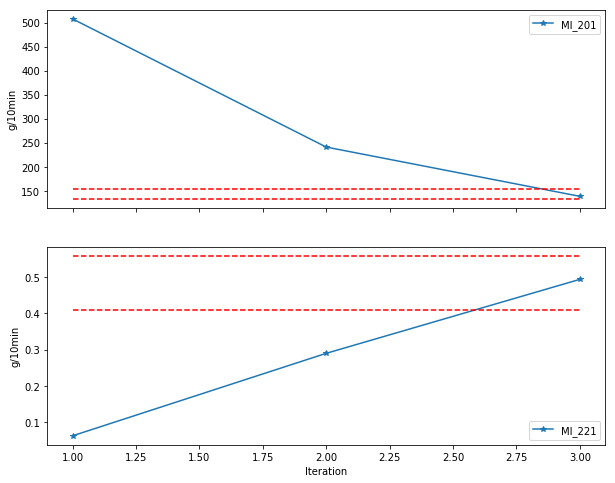

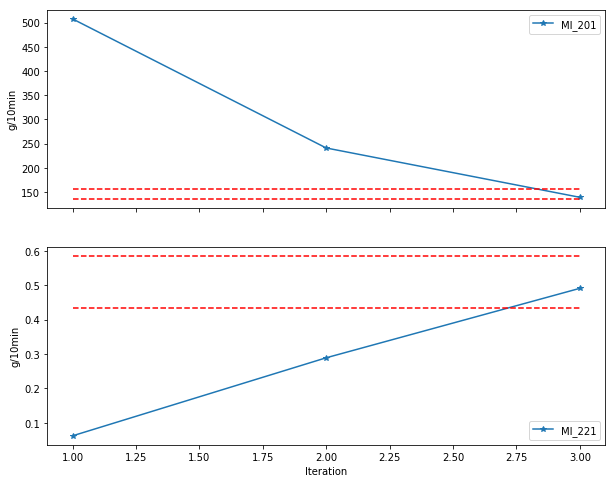

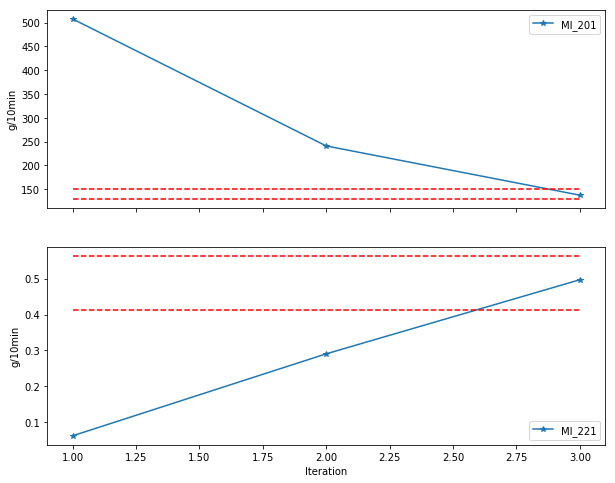

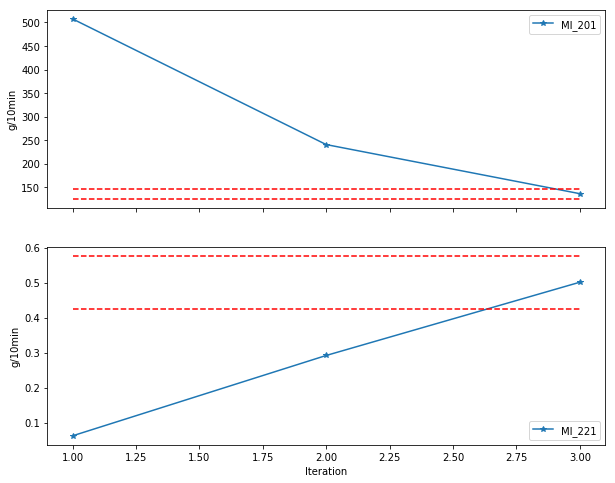

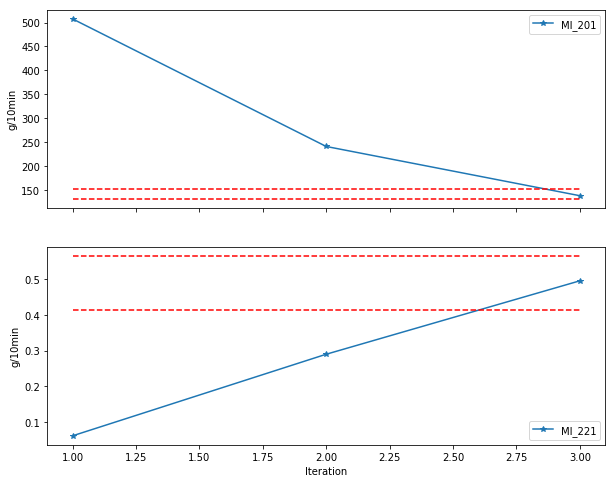

In [258]:
sessionindex = '616542713_10.244.36.191'
num_eps = len(assess_df[assess_df['SessionIndex'] == sessionindex]['EpisodeIndex'].unique())
for i in range(num_eps):
    plot_assess(assess_df, sessionindex, i+1)

## From ADE csv

In [167]:
assess_df = pd.read_csv('sac_bline.csv')

In [168]:
assess_df =  assess_df[assess_df['AssessmentName'] == 'custom_assessment_1']

In [114]:
assess_df['SessionIndex'].unique()

array(['616528460_10.244.36.191', '616524380_10.244.36.191',
       '170598625_10.244.10.43', '170593140_10.244.10.43',
       '1575440741_10.244.93.231', '1575440152_10.244.93.231',
       '1575436173_10.244.93.231', '1575422593_10.244.93.231',
       '1575420480_10.244.93.231', '1575420147_10.244.93.231',
       '1546532192_10.244.92.46', '1546525589_10.244.92.46',
       '149794370_10.244.8.237', '149768096_10.244.8.237',
       '1342356501_10.244.80.2', '1273669528_10.244.75.234'], dtype=object)

In [211]:
import pandas as pd
import ast
def format_csv_logs(df: pd.DataFrame) -> pd.DataFrame:
    ''' Function to format a dataframe obtained from KQL query.
        Output format: keeps only selected columns, and flatten nested columns [SimAction, SimState, SimConfig]

        Parameters
        ----------
        df : DataFrame
            dataframe obtained from running KQL query then exporting `_kql_raw_result_.to_dataframe()`
    '''
    selected_columns = ["Timestamp","EpisodeIndex", "IterationIndex", "Reward", "Terminal", "SimState", "SimAction", "SimConfig", "SessionIndex"]
    nested_columns =  [ "SimState", "SimAction", "SimConfig"]
    df_selected_columns = df[selected_columns]
    series_lst = []
    ordered_columns = ["Timestamp","EpisodeIndex", "IterationIndex", "Reward", "Terminal", "IterationSpeed_s", "SessionIndex"]
    for i in nested_columns:
        try:
            new_series = df_selected_columns[i].apply(ast.literal_eval).apply(pd.Series)
        except:
            df_selected_columns[i].fillna(value=str({key: str(np.nan) for key, value in ast.literal_eval(df_selected_columns[i][1]).items()}), inplace=True)
            new_series = df_selected_columns[i].apply(ast.literal_eval).apply(pd.Series)
        column_names = new_series.columns.values.tolist()
        series_lst.append(new_series)
        if len(column_names) > 0:
            ordered_columns.extend(column_names)
        del(df_selected_columns[i])

    series_lst.append(df_selected_columns)
    formated_df = pd.concat(series_lst, axis=1)
    formated_df = formated_df.sort_values(by='Timestamp',ascending=True) # reorder df based on Timestamp
    formated_df.index = range(len(formated_df)) # re-index
    formated_df['Timestamp']=pd.to_datetime(formated_df['Timestamp']) # convert Timestamp to datetime
    formated_df['IterationSpeed_s']=formated_df['Timestamp'].diff().dt.total_seconds() # convert Timestamp to datetime

    formated_df = formated_df[ordered_columns]
    
    return formated_df.sort_values(by=["EpisodeIndex", "IterationIndex"])

In [212]:
df_flattened = format_csv_logs(assess_df)

ValueError: malformed node or string: <_ast.Name object at 0x000001894D5D8208>

In [210]:
df_flattened.head()

Timestamp  EpisodeIndex  IterationIndex  Reward  Terminal  \
0 2021-10-07 19:44:42.675             1               1     0.0     False   
1 2021-10-07 19:44:43.022             1               1     0.0     False   
2 2021-10-07 19:44:45.149             1               1     0.0     False   
3 2021-10-07 19:44:46.294             1               1     0.0     False   
4 2021-10-07 19:44:50.478             1               1     0.0     False   

   IterationSpeed_s              SessionIndex  
0               NaN  1575420147_10.244.93.231  
1             0.347    149794370_10.244.8.237  
2             2.127   616524380_10.244.36.191  
3             1.145  1575440741_10.244.93.231  
4             4.184   616528460_10.244.36.191

In [172]:
def plot_assess(df, SessionIndex, ep):
    df = df[df['SessionIndex'] == SessionIndex]
    df = df[df['EpisodeIndex'] == ep]
    df_flattened = format_kql_logs(df)
    
    import matplotlib.pyplot as plt

    fig, ax = plt.subplots(2, 1, figsize=(10,8), sharex=True)
    ax[0].plot(df_flattened['IterationIndex'].values, df_flattened['MI_201'].values, marker='*')
    ax[0].plot(df_flattened['IterationIndex'].values, df_flattened['MI_201_target_range_low'].values, 'r--')
    ax[0].plot(df_flattened['IterationIndex'].values, df_flattened['MI_201_target_range_high'].values, 'r--')
    ax[0].legend(['MI_201'])
    ax[0].set_ylabel('g/10min')
    
    ax[1].plot(df_flattened['IterationIndex'].values, df_flattened['MI_221'].values, marker='*')
    ax[1].plot(df_flattened['IterationIndex'].values, df_flattened['MI_221_target_range_low'].values, 'r--')
    ax[1].plot(df_flattened['IterationIndex'].values, df_flattened['MI_221_target_range_high'].values, 'r--')
    ax[1].legend(['MI_221'])
    ax[1].set_ylabel('g/10min')
    ax[1].set_xlabel('Iteration')

    plt.show()

Index([       'Timestamp',     'EpisodeIndex',   'IterationIndex',
                 'Reward',         'Terminal', 'IterationSpeed_s',
           'SessionIndex',                  0,                  0,
                        0,                  0,                  0,
                        0,                  0,                  0,
                        0],
      dtype='object')


KeyError: 'MI_201'

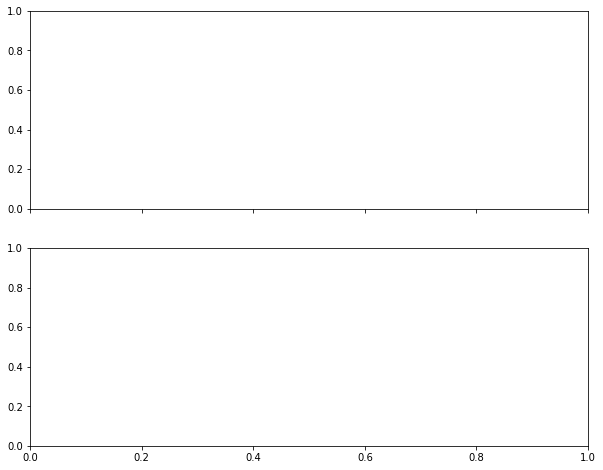

In [173]:
sessionindex = '616528460_10.244.36.191'
num_eps = len(assess_df[assess_df['SessionIndex'] == sessionindex]['EpisodeIndex'].unique())
for i in range(num_eps):
    plot_assess(assess_df, sessionindex, i+1)